## Tutorial 6 - Tiltrotor eVTOL Aircraft Simulation
Welcome to this tutorial on simulating a tiltrotor eVTOL aircraft using RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs.

---

## Header and Imports


The **Imports** section is divided into two parts: simulation-specific libraries and general-purpose Python libraries.

The **RCAIDE Imports** section includes the core modules needed for the simulation. These libraries provide specialized classes and tools for building, analyzing, and running aircraft models.


In [1]:
''' 
# Stopped_Rotor_EVTOL.py
# 
# Created: May 2019, M Clarke
#          Sep 2020, M. Clarke 

'''
#----------------------------------------------------------------------
#   Imports
# ---------------------------------------------------------------------
import RCAIDE
from RCAIDE.Framework.Core import Units 
from RCAIDE.Library.Methods.Geometry.Planform                                  import segment_properties,wing_segmented_planform   
from RCAIDE.Library.Methods.Weights.Correlation_Buildups.Propulsion            import compute_motor_weight
from RCAIDE.Library.Methods.Propulsors.Converters.DC_Motor                     import design_motor
from RCAIDE.Library.Methods.Propulsors.Converters.Rotor                        import design_prop_rotor  
from RCAIDE.Library.Methods.Weights.Physics_Based_Buildups.Electric            import converge_physics_based_weight_buildup 
from RCAIDE.Library.Methods.Weights.Moment_of_Inertia                          import compute_aircraft_moment_of_inertia
from RCAIDE.Library.Methods.Weights.Center_of_Gravity                          import compute_vehicle_center_of_gravity
from RCAIDE.Library.Plots                                                      import * 
from RCAIDE import  load 
from RCAIDE import  save  

import os
import numpy as np 
from copy import deepcopy
import matplotlib.pyplot as plt 
import  pickle


## Vehicle Setup

The **`vehicle_setup`** function defines the baseline configuration of the aircraft. This section builds the vehicle step-by-step by specifying its components, geometric properties, and high-level parameters.

---

### 1. Creating the Vehicle Instance

The setup begins by creating a vehicle instance and assigning it a **tag**. The tag is a unique string identifier used to reference the vehicle during analysis or in post-processing steps.

---

### 2. Defining High-Level Vehicle Parameters

The high-level parameters describe the aircraft’s key operational characteristics, such as:

- **Maximum Takeoff Weight**: The heaviest allowable weight of the aircraft for safe flight.
- **Operating Empty Weight**: The aircraft weight without fuel, passengers, or payload.
- **Payload**: The weight of cargo and passengers.
- **Max Zero Fuel Weight**: The maximum weight of the aircraft excluding fuel.

Units for these parameters can be converted automatically using the `Units` module to ensure consistency and reduce errors.

---

### 3. Defining the Landing Gear

Landing gear parameters, such as the number of main and nose wheels, are set for the aircraft. While not used in this tutorial, these values can be applied in advanced analyses, such as **ground loads** or **noise prediction**.

---

### 4. Main Wing Setup

The main wing is added using the **`Main_Wing`** class. This designation ensures that the primary lifting surface is recognized correctly by the analysis tools. Key properties of the wing include:

- **Area**: The total wing surface area.
- **Span**: The length of the wing from tip to tip.
- **Aspect Ratio**: A ratio of span to average chord, determining wing efficiency.
- **Segments**: Divisions of the wing geometry (e.g., root and tip sections).
- **Control Surfaces**: High-lift devices like flaps and ailerons, defined by span fractions and deflections.

---

### 5. Horizontal and Vertical Stabilizers

The stabilizers provide stability and control for the aircraft:

- **Horizontal Stabilizer**: Defined using the `Horizontal_Tail` class. It follows a similar setup to the main wing but acts as a stabilizing surface.
- **Vertical Stabilizer**: Defined using the `Vertical_Tail` class, with an additional option to designate the tail as a **T-tail** for weight calculations.

---

### 6. Fuselage Definition

The fuselage is modeled by specifying its geometric parameters, such as:

- **Length**: The overall length of the aircraft body.
- **Width**: The widest part of the fuselage cross-section.
- **Height**: The height of the fuselage.

These values influence drag calculations and overall structural weight.

---

### 7. Energy Network

The **energy network** models the propulsion system. The energy network determines the engine’s thrust, bypass ratio, and fuel type. These parameters are essential for performance and fuel efficiency analyses.


---

In [2]:

# ----------------------------------------------------------------------
#   Build the Vehicle
# ----------------------------------------------------------------------
def vehicle_setup() : 

    ospath                                = os.path.abspath(os.path.join('Notebook'))
    separator                             = os.path.sep
    rel_path = os.path.dirname(ospath) + separator + '..' + separator + '..' + separator + 'Regressions' + separator + 'Vehicles' + separator
    
    
    # ------------------------------------------------------------------
    #   Initialize the Vehicle
    # ------------------------------------------------------------------    
    vehicle                                   = RCAIDE.Vehicle()
    vehicle.tag                               = 'Tiltrotor'
    vehicle.configuration                     = 'eVTOL'

    # ------------------------------------------------------------------
    #   Vehicle-level Properties
    # ------------------------------------------------------------------    
    # mass properties
    vehicle.mass_properties.takeoff              = 2177
    vehicle.mass_properties.operating_empty      = 2177      
    vehicle.mass_properties.max_takeoff          = 2177             
    vehicle.mass_properties.center_of_gravity    = [[2.0144,   0.  ,  0. ]]      
    vehicle.reference_area                       = 10.39
    vehicle.flight_envelope.ultimate_load        = 5.7   
    vehicle.flight_envelope.positive_limit_load  = 3.  
    vehicle.passengers                           = 5

    # ------------------------------------------------------------------    
    # WINGS                                    
    # ------------------------------------------------------------------    
    # WING PROPERTIES           
    wing                                      = RCAIDE.Library.Components.Wings.Main_Wing()
    wing.tag                                  = 'main_wing'  
    wing.aspect_ratio                         = 9.11 
    wing.sweeps.quarter_chord                 = 0.0  
    wing.thickness_to_chord                   = 0.15
    wing.taper                                = 0.650 
    wing.spans.projected                      = 9.736 
    wing.chords.root                          = 1.57 
    wing.total_length                         = 1.57  
    wing.chords.tip                           = 0.66 
    wing.chords.mean_aerodynamic              = 1.069 
    wing.dihedral                             = 0   * Units.degrees  
    wing.areas.reference                      = 10.39 * 2  
    wing.areas.wetted                         = 10.39 * 2   
    wing.areas.exposed                        = 10.39 * 2   
    wing.twists.root                          = 0   * Units.degrees  
    wing.twists.tip                           = 0   * Units.degrees   
    wing.origin                               = [[ 1.778,0 , 1.0 ]]
    wing.aerodynamic_center                   = [ 1.8 ,0 , 1.0 ]    
    wing.winglet_fraction                     = 0.0  
    wing.symmetric                            = True
    wing.vertical                             = False
                                              
    # Segment                                              
    segment                                   = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                               = 'Section_1'   
    segment.percent_span_location             = 0.0
    segment.twist                             = 4.0  * Units.degrees
    segment.root_chord_percent                = 1 
    segment.dihedral_outboard                 = 8.  * Units.degrees
    segment.sweeps.quarter_chord              = 0. * Units.degrees 
    segment.thickness_to_chord                = 0.15 
    wing.append_segment(segment)                           
                                              
    # Segment                                               
    segment                                   = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                               = 'Section_2'    
    segment.percent_span_location             = 0.4875
    segment.twist                             = 4.0  * Units.degrees
    segment.root_chord_percent                = 0.6496
    segment.dihedral_outboard                 = 0. * Units.degrees
    segment.sweeps.quarter_chord              = 0. * Units.degrees
    segment.thickness_to_chord                = 0.135
    wing.append_segment(segment)                                 
                                              
    # Segment                                              
    segment                                   = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                               = 'Section_5'   
    segment.percent_span_location             = 1.0
    segment.twist                             = 0. 
    segment.root_chord_percent                = 0.42038
    segment.dihedral_outboard                 = 0.  * Units.degrees 
    segment.sweeps.quarter_chord              = 0.  * Units.degrees 
    segment.thickness_to_chord                = 0.12
    wing.append_segment(segment)   

    # compute reference properties 
    wing_segmented_planform(wing, overwrite_reference = True ) 
    wing = segment_properties(wing)
    vehicle.reference_area        = wing.areas.reference  
    wing.areas.wetted             = wing.areas.reference  * 2 
    wing.areas.exposed            = wing.areas.reference  * 2 

    # control surfaces ------------------------------------------- 
    flap                          = RCAIDE.Library.Components.Wings.Control_Surfaces.Flap()
    flap.tag                      = 'flap'
    flap.span_fraction_start      = 0.2
    flap.span_fraction_end        = 0.5
    flap.deflection               = 0.0 * Units.degrees 
    flap.chord_fraction           = 0.20
    wing.append_control_surface(flap)  
    

    aileron                       = RCAIDE.Library.Components.Wings.Control_Surfaces.Aileron()
    aileron.tag                   = 'aileron'
    aileron.span_fraction_start   = 0.7
    aileron.span_fraction_end     = 0.9 
    aileron.deflection            = 0.0 * Units.degrees
    aileron.chord_fraction        = 0.2
    wing.append_control_surface(aileron)     
    
        
    # add to vehicle 
    vehicle.append_component(wing)  
                  
                                              
    # WING PROPERTIES                         
    wing                                      = RCAIDE.Library.Components.Wings.Horizontal_Tail() 
    wing.aspect_ratio                         = 4.27172 
    wing.sweeps.quarter_chord                 = 22.46  * Units.degrees 
    wing.thickness_to_chord                   = 0.15 
    wing.spans.projected                      = 3.6
    wing.chords.root                          = 1.193 
    wing.total_length                         = 1.193 
    wing.chords.tip                           = 0.535 
    wing.taper                                = 0.44  
    wing.chords.mean_aerodynamic              = 0.864 
    wing.dihedral                             = 45.0 * Units.degrees 
    wing.areas.reference                      = 4.25 * 2 
    wing.areas.wetted                         = 4.25 * 2 
    wing.areas.exposed                        = 4.25 * 2 
    wing.twists.root                          = 0 * Units.degrees 
    wing.twists.tip                           = 0 * Units.degrees 
    wing.origin                               = [[ 5.167, 0.0 ,0.470 ]]
    wing.aerodynamic_center                   = [  5.267,  0., 0.470  ]  
    wing.winglet_fraction                     = 0.0 
    wing.symmetric                            = True    

    elevator                              = RCAIDE.Library.Components.Wings.Control_Surfaces.Elevator()
    elevator.tag                          = 'elevator'
    elevator.span_fraction_start          = 0.6
    elevator.span_fraction_end            = 0.9
    elevator.deflection                   = 0.0  * Units.deg
    elevator.chord_fraction               = 0.4
    wing.append_control_surface(elevator)       
    

    rudder                                = RCAIDE.Library.Components.Wings.Control_Surfaces.Rudder()
    rudder.tag                            = 'rudder'
    rudder.span_fraction_start            = 0.1
    rudder.span_fraction_end              = 0.5
    rudder.deflection                     = 0.0  * Units.deg
    rudder.chord_fraction                 = 0.4
    wing.append_control_surface(rudder) 

    # add to vehicle
    vehicle.append_component(wing)    
  
    # ---------------------------------------------------------------   
    # FUSELAGE                
    # ---------------------------------------------------------------   
    # FUSELAGE PROPERTIES
    fuselage                                    = RCAIDE.Library.Components.Fuselages.Fuselage()
    fuselage.tag                                = 'fuselage' 
    fuselage.seats_abreast                      = 2.  
    fuselage.seat_pitch                         = 3.  
    fuselage.fineness.nose                      = 0.88   
    fuselage.fineness.tail                      = 1.13   
    fuselage.lengths.nose                       = 0.5  
    fuselage.lengths.tail                       = 1.5
    fuselage.lengths.cabin                      = 4.46 
    fuselage.lengths.total                      = 6.46
    fuselage.width                              = 4.65 * Units.feet
    fuselage.heights.maximum                    = 4.65 * Units.feet      # change 
    fuselage.heights.at_quarter_length          = 3.75 * Units.feet      # change 
    fuselage.heights.at_wing_root_quarter_chord = 4.65 * Units.feet      # change 
    fuselage.heights.at_three_quarters_length   = 4.26 * Units.feet      # change 
    fuselage.areas.wetted                       = 236. * Units.feet**2   # change 
    fuselage.areas.front_projected              = 0.14 * Units.feet**2   # change 
    fuselage.effective_diameter                 = 1.276     # change 
    fuselage.differential_pressure              = 0. 
    
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_0'    
    segment.percent_x_location                  = 0.0 
    segment.percent_z_location                  = 0.     # change  
    segment.height                              = 0.049 
    segment.width                               = 0.032 
    fuselage.append_segment(segment)                     
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_1'   
    segment.percent_x_location                  = 0.026  
    segment.percent_z_location                  = 0.00849
    segment.height                              = 0.481 
    segment.width                               = 0.553 
    fuselage.append_segment(segment)           
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_2'   
    segment.percent_x_location                  = 0.074
    segment.percent_z_location                  = 0.02874
    segment.height                              = 1.00
    segment.width                               = 0.912 
    fuselage.append_segment(segment)                     
                                                
    # Segment                                            
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_3'   
    segment.percent_x_location                  = 0.161  
    segment.percent_z_location                  = 0.04348   
    segment.height                              = 1.41
    segment.width                               = 1.174  
    fuselage.append_segment(segment)                     
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_4'   
    segment.percent_x_location                  = 0.284 
    segment.percent_z_location                  = 0.05435 
    segment.height                              = 1.62
    segment.width                               = 1.276  
    fuselage.append_segment(segment)              
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_5'   
    segment.percent_x_location                  = 0.531 
    segment.percent_z_location                  = 0.0510 
    segment.height                              = 1.409
    segment.width                               = 1.121 
    fuselage.append_segment(segment)                     
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_6'   
    segment.percent_x_location                  = 0.651
    segment.percent_z_location                  = 0.05636 
    segment.height                              = 1.11
    segment.width                               = 0.833
    fuselage.append_segment(segment)                  
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_7'   
    segment.percent_x_location                  = 0.773
    segment.percent_z_location                  = 0.06149 
    segment.height                              = 0.78
    segment.width                               = 0.512 
    fuselage.append_segment(segment)                  
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_8'   
    segment.percent_x_location                  = 1.
    segment.percent_z_location                  = 0.07352  
    segment.height                              = 0.195  
    segment.width                               = 0.130 
    fuselage.append_segment(segment)                   
                                                
    vehicle.append_component(fuselage)  



    #------------------------------------------------------------------------------------------------------------------------------------
    # ########################################################  Energy Network  ######################################################### 
    #------------------------------------------------------------------------------------------------------------------------------------
    # define network
    network                                                = RCAIDE.Framework.Networks.Electric() 
    network.charging_power                                 = 1000
   
    #==================================================================================================================================== 
    # Tilt Rotor Bus 
    #====================================================================================================================================          
    bus                           = RCAIDE.Library.Components.Energy.Distributors.Electrical_Bus()
    bus.tag                       = 'bus'
    bus.number_of_battery_modules =  4

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Bus Battery
    #------------------------------------------------------------------------------------------------------------------------------------ 
    battery_module                                                    = RCAIDE.Library.Components.Energy.Sources.Battery_Modules.Lithium_Ion_NMC() 
    battery_module.tag                                                = 'bus_battery'
    battery_module.electrical_configuration.series                    = 35
    battery_module.electrical_configuration.parallel                  = 100                
    battery_module.geometrtic_configuration.normal_count              = 140
    battery_module.geometrtic_configuration.parallel_count            = 25
    battery_module.geometrtic_configuration.stacking_rows             = 2
    
                       # starboard   | port        | front  | rear 
    modules_origins = [[1.8, 2.0,1.0 ],[1.8, -2.0, 1.0  ],[0.5, 0.0, 0.0 ],[3.5, 0.0, 0.0]]  
    orientation     = [[0, 0.0, np.pi],[0, 0.0, np.pi ],[0, 0.0, 0 ],[0, 0.0,0 ]]   
    for m_i in range(bus.number_of_battery_modules):
        module =  deepcopy(battery_module)
        module.tag = 'nmc_module_' + str(m_i+1) 
        module.origin = [modules_origins[m_i]] 
        module.orientation_euler_angles  = orientation[m_i]  
        bus.battery_modules.append(module) 
    bus.initialize_bus_properties()    
    
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Lift Propulsors 
    #------------------------------------------------------------------------------------------------------------------------------------    
     
    # Define Lift Propulsor Container 
    propulsor                                = RCAIDE.Library.Components.Propulsors.Electric_Rotor()
    propulsor.tag                            = 'propulsor'       
              
    # Electronic Speed Controller           
    prop_rotor_esc                                = RCAIDE.Library.Components.Energy.Modulators.Electronic_Speed_Controller()
    prop_rotor_esc.efficiency                     = 0.95    
    prop_rotor_esc.tag                            = 'prop_rotor_esc_1'  
    propulsor.electronic_speed_controller         = prop_rotor_esc  
    
    # Lift Rotor Design
    g                                             = 9.81                                    # gravitational acceleration   
    Hover_Load                                    = vehicle.mass_properties.takeoff*g *1.1  # hover load   

    prop_rotor                                    = RCAIDE.Library.Components.Propulsors.Converters.Prop_Rotor()   
    prop_rotor.tag                                = 'prop_rotor'   
    prop_rotor.tip_radius                         = 3/2
    prop_rotor.hub_radius                         = 0.15 * prop_rotor.tip_radius
    prop_rotor.number_of_blades                   = 4

    prop_rotor.hover.design_altitude              = 40 * Units.feet  
    prop_rotor.hover.design_thrust                = Hover_Load/6
    prop_rotor.hover.design_freestream_velocity   = np.sqrt(prop_rotor.hover.design_thrust/(2*1.2*np.pi*(prop_rotor.tip_radius**2)))
    
    prop_rotor.oei.design_altitude                = 40 * Units.feet  
    prop_rotor.oei.design_thrust                  = Hover_Load/5  
    prop_rotor.oei.design_freestream_velocity     = np.sqrt(prop_rotor.oei.design_thrust/(2*1.2*np.pi*(prop_rotor.tip_radius**2)))
    
    prop_rotor.cruise.design_altitude             = 1500 * Units.feet
    prop_rotor.cruise.design_thrust               = 3150 / 6
    prop_rotor.cruise.design_freestream_velocity  = 130.* Units['mph']      
    
    airfoil                                       = RCAIDE.Library.Components.Airfoils.Airfoil()   
    airfoil.coordinate_file                       =  rel_path + 'Airfoils' + separator + 'NACA_4412.txt'
    airfoil.polar_files                           = [rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_50000.txt' ,
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_100000.txt' ,
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_200000.txt' ,
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_500000.txt' ,
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_1000000.txt',
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_3500000.txt',
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_5000000.txt',
                                                     rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_7500000.txt' ]
    prop_rotor.append_airfoil(airfoil)                
    prop_rotor.airfoil_polar_stations             = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]    
    prop_rotor.fidelity                           = "Momentum_Theory"   
    design_prop_rotor(prop_rotor) 
    propulsor.rotor =  prop_rotor 
    
    
    #------------------------------------------------------------------------------------------------------------------------------------               
    # Lift Rotor Motor  
    #------------------------------------------------------------------------------------------------------------------------------------    
    prop_rotor_motor                         = RCAIDE.Library.Components.Propulsors.Converters.DC_Motor()
    prop_rotor_motor.efficiency              = 0.95
    prop_rotor_motor.nominal_voltage         = bus.voltage * 0.75
    prop_rotor_motor.prop_rotor_radius       = prop_rotor.tip_radius 
    prop_rotor_motor.no_load_current         = 0.01 
    prop_rotor_motor.rotor_radius            = prop_rotor.tip_radius
    prop_rotor_motor.design_torque           = (prop_rotor.hover.design_thrust * np.sqrt(prop_rotor.hover.design_thrust/(2*1.2*np.pi*(prop_rotor.tip_radius**2)))) /prop_rotor.hover.design_angular_velocity 
    prop_rotor_motor.angular_velocity        = prop_rotor.hover.design_angular_velocity/prop_rotor_motor.gear_ratio  
    design_motor(prop_rotor_motor) 
    prop_rotor_motor.mass_properties.mass    = compute_motor_weight(prop_rotor_motor)     
    propulsor.motor                          = prop_rotor_motor
     

    #------------------------------------------------------------------------------------------------------------------------------------               
    # Lift Rotor Nacelle
    #------------------------------------------------------------------------------------------------------------------------------------     
    nacelle                           = RCAIDE.Library.Components.Nacelles.Nacelle() 
    nacelle.length                    = 0.45
    nacelle.diameter                  = 0.3 
    nacelle.flow_through              = False
    
    
    propulsor.nacelle            =  nacelle  

    # Front Rotors Locations 
    origins =[[0.208, -1.848,  1.195],[0.208, 1.848,  1.195],
              [1.505,5.000,1.320],[1.505,-5.000,1.320],
              [  5.318, 1.848,   2.282],[   5.318, -1.848,   2.282]] 
     
    assigned_propulsor_list = []    
    for i in range(len(origins)): 
        propulsor_i                                       = deepcopy(propulsor)
        propulsor_i.tag                                   = 'prop_rotor_propulsor_' + str(i + 1)
        propulsor_i.rotor.tag                             = 'prop_rotor_' + str(i + 1) 
        propulsor_i.rotor.origin                          = [origins[i]]  
        propulsor_i.motor.tag                             = 'prop_rotor_motor_' + str(i + 1)   
        propulsor_i.motor.origin                          = [origins[i]]  
        propulsor_i.electronic_speed_controller.tag       = 'prop_rotor_esc_' + str(i + 1)  
        propulsor_i.electronic_speed_controller.origin    = [origins[i]]  
        propulsor_i.nacelle.tag                           = 'prop_rotor_nacelle_' + str(i + 1)  
        propulsor_i.nacelle.origin                        = [origins[i]]   
        network.propulsors.append(propulsor_i)   
        assigned_propulsor_list.append(propulsor_i.tag) 
    bus.assigned_propulsors = [assigned_propulsor_list]

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Additional Bus Loads
    #------------------------------------------------------------------------------------------------------------------------------------            
    # Payload   
    payload                         = RCAIDE.Library.Components.Systems.Avionics()
    payload.power_draw              = 10. # Watts 
    payload.mass_properties.mass    = 1.0 * Units.kg
    bus.payload                     = payload 
                             
    # Avionics                            
    avionics                        = RCAIDE.Library.Components.Systems.Avionics()
    avionics.power_draw             = 10. # Watts  
    avionics.mass_properties.mass   = 1.0 * Units.kg
    bus.avionics                    = avionics    
   
    network.busses.append(bus)
     
    # append energy network 
    vehicle.append_energy_network(network)  
 
    #------------------------------------------------------------------------------------------------------------------------------------
    # ##################################   Determine Vehicle Mass Properties Using Physic Based Methods  ################################ 
    #------------------------------------------------------------------------------------------------------------------------------------   
    converged_vehicle, breakdown = converge_physics_based_weight_buildup(vehicle)  
    print(breakdown)

    # ------------------------------------------------------------------
    #   CG Location
    # ------------------------------------------------------------------    
    _ , _ =  compute_vehicle_center_of_gravity(converged_vehicle) 
    CG_location  = converged_vehicle.mass_properties.center_of_gravity
    
    # ------------------------------------------------------------------
    #   Operating Aircraft MOI
    # ------------------------------------------------------------------    
    _, _ = compute_aircraft_moment_of_inertia(converged_vehicle, CG_location)    

    return converged_vehicle 
 

## Configurations Setup

The **`configs_setup`** function defines the different vehicle configurations (referred to as **configs**) used during the simulation. Configurations allow for modifications to the baseline vehicle, such as altering control surface settings, without redefining the entire vehicle.

---

### 1. Base Configuration

The **base configuration** serves as the foundation for all other configurations. It is defined to match the baseline vehicle created in the `vehicle_setup` function. Configurations in RCAIDE are created as **containers** using **RCAIDE Data classes**. These classes provide additional functionality, such as the ability to **append** new configurations or modifications.

---

### 2. Cruise Configuration

The **cruise configuration** demonstrates that new configurations can inherit properties directly from existing configurations (e.g., the base config). This avoids redundancy and ensures consistency across configurations.

- The cruise configuration typically reflects the clean flight condition, with no high-lift devices like flaps or slats deployed.
  
---



## 3. Remaining Configurations

The remaining configurations, such as **climb**, **approach**, and **hover**, follow a similar pattern:

- Hover Climb
- Hover-to-Cruise
- Approach
- Hover

Each configuration is built upon the previous one or the base configuration, ensuring modularity and easy customization.



---

In [3]:
            
 
def configs_setup(vehicle):
    '''
    The configration set up below the scheduling of the nacelle angle and vehicle speed.
    Since one prop_rotor operates at varying flight conditions, one must perscribe  the 
    pitch command of the prop_rotor which us used in the variable pitch model in the analyses
    Note: low pitch at take off & low speeds, high pitch at cruise
    '''
    # ------------------------------------------------------------------
    #   Initialize Configurations
    # ------------------------------------------------------------------ 
    configs = RCAIDE.Library.Components.Configs.Config.Container() 
    base_config                                                       = RCAIDE.Library.Components.Configs.Config(vehicle)
    base_config.tag                                                   = 'base'     
    configs.append(base_config) 
 
    # ------------------------------------------------------------------
    #   Hover Climb Configuration
    # ------------------------------------------------------------------
    config                                                 = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                             = 'vertical_climb'
    vector_angle                                           = 90.0 * Units.degrees    
    for network in  config.networks:  
        for propulsor in  network.propulsors:
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0]
    configs.append(config)

    # ------------------------------------------------------------------
    #    
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    vector_angle                                      = 75.0  * Units.degrees   
    config.tag                                        = 'vertical_transition' 
    for network in  config.networks:  
        for propulsor in  network.propulsors:
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0]
            propulsor.rotor.pitch_command   = propulsor.rotor.hover.design_pitch_command * 0.5 
    configs.append(config) 

    # ------------------------------------------------------------------
    #   Hover-to-Cruise Configuration
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                        = 'low_speed_climb_transition'
    vector_angle                                      = 45.0  * Units.degrees   
    for network in  config.networks:  
        for propulsor in  network.propulsors:
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0]
            propulsor.rotor.pitch_command     = propulsor.rotor.cruise.design_pitch_command * 0.5  
    configs.append(config) 

    # ------------------------------------------------------------------
    #   Hover-to-Cruise Configuration
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                        = 'high_speed_climb_transition'
    vector_angle                                      = 5.0  * Units.degrees   
    for network in  config.networks:  
        for propulsor in  network.propulsors:
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0]
            propulsor.rotor.pitch_command     = propulsor.rotor.cruise.design_pitch_command  
    configs.append(config) 
 
    # ------------------------------------------------------------------
    #   Cruise Configuration
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                        = 'cruise'   
    vector_angle                                      = 0.0 * Units.degrees   
    for network in  config.networks:  
        for propulsor in  network.propulsors:
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0]
            propulsor.rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command  
    configs.append(config)
    
    # ------------------------------------------------------------------
    #   Approach Configuration
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                        = 'approach_transition'    
    vector_angle                                      = 85.0  * Units.degrees   
    for network in  config.networks:  
        for propulsor in  network.propulsors:
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0] 
            propulsor.rotor.pitch_command   = propulsor.rotor.cruise.design_pitch_command * 0.75
    configs.append(config)
    
    
    # ------------------------------------------------------------------
    #   Hover Configuration
    # ------------------------------------------------------------------
    config                                            = RCAIDE.Library.Components.Configs.Config(vehicle)
    config.tag                                        = 'vertical_descent'
    vector_angle                                      = 90.0  * Units.degrees 
    for network in  config.networks:  
        for propulsor in  network.propulsors:  
            propulsor.rotor.orientation_euler_angles =  [0, vector_angle, 0]
    configs.append(config)

    return configs



## Base Analysis

The **`base_analysis`** function defines the analyses required for evaluating the aircraft. Each analysis addresses a specific aspect of the vehicle’s performance or characteristics. Below are the key analyses, their purpose, and considerations for their use.

---

### 1. Weights Analysis

The **weights analysis** calculates the distribution of the aircraft's weight across various components. This method is based on **empirical correlations** designed for **tube-and-wing transport aircraft** configurations.

- Provides a breakdown of component weights (e.g., wings, fuselage, engines).
- While informative, the results of this analysis are **not directly used** in the performance evaluation.

---

### 2. Aerodynamics Analysis

The **aerodynamics analysis** evaluates the aerodynamic performance of the aircraft. It uses RCAIDE's **fidelity zero** method:

- **Fidelity Zero**: This is RCAIDE's baseline aerodynamic analysis method, suitable for **subsonic transport aircraft**.
- Similar to aerodynamic methods found in conceptual design texts.
- Provides estimates for lift, drag, and other aerodynamic coefficients.

> Note: Higher-fidelity aerodynamic methods are available for more detailed analyses if needed.

---

### 3. Stability Analysis

The **stability analysis** calculates stability derivatives for the aircraft. While it is **not used** in the current mission setup, it can be run post-mission for checks or additional analysis.

- Like the aerodynamic method, it uses **fidelity zero** for baseline stability analysis.
- Applicable for basic stability checks of subsonic transport aircraft.

---

### 4. Energy Analysis

The **energy analysis** runs the energy network attached to the vehicle. For this turboprop-powered aircraft:

- The analysis evaluates the **turboprop energy network**.
- Ensures the propulsion system behavior, such as thrust and fuel consumption, is accounted for.

---

### 5. Planet Analysis

The **planet analysis** defines the planetary environment the vehicle operates in. This setup allows for the attachment of an atmospheric model.

---

### 6. Atmosphere Analysis

The **atmosphere analysis** sets the atmospheric conditions for the simulation. A common choice is the **US 1976 Standard Atmosphere**, which provides:

- Standard temperature, pressure, and density profiles with altitude.
- Consistent atmospheric conditions for performance evaluations.

---


In [4]:

def base_analysis(vehicle):

    # ------------------------------------------------------------------
    #   Initialize the Analyses
    # ------------------------------------------------------------------     
    analyses = RCAIDE.Framework.Analyses.Vehicle() 
    
    # ------------------------------------------------------------------
    #  Weights
    weights         = RCAIDE.Framework.Analyses.Weights.Weights_EVTOL()
    weights.vehicle = vehicle
    analyses.append(weights)

    # ------------------------------------------------------------------
    #  Aerodynamics Analysis
    aerodynamics         = RCAIDE.Framework.Analyses.Aerodynamics.Vortex_Lattice_Method() 
    aerodynamics.vehicle = vehicle 
    analyses.append(aerodynamics)
     
    # ------------------------------------------------------------------
    #  Stability Analysis
    stability         = RCAIDE.Framework.Analyses.Stability.Vortex_Lattice_Method() 
    stability.vehicle = vehicle 
    analyses.append(stability)    

    # ------------------------------------------------------------------
    #  Energy
    energy          = RCAIDE.Framework.Analyses.Energy.Energy()
    energy.vehicle = vehicle 
    analyses.append(energy)

    # ------------------------------------------------------------------
    #  Planet Analysis
    planet = RCAIDE.Framework.Analyses.Planets.Earth()
    analyses.append(planet)

    # ------------------------------------------------------------------
    #  Atmosphere Analysis
    atmosphere = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
    atmosphere.features.planet = planet.features
    analyses.append(atmosphere)   

    # done!
    return analyses    




## Analyses Setup

The **`analyses_setup`** function assigns a set of analyses to each vehicle configuration. Analyses are used to evaluate the aircraft’s performance, aerodynamics, energy systems, and other characteristics for a given configuration.

---

## 1. Overview of Analyses Assignment

In this tutorial, **all configurations** share the same set of analyses. However, this function provides the flexibility to assign a unique set of analyses to any specific configuration.

---

### 2. Purpose of Analyses Assignment

The analyses ensure that the defined vehicle configurations (e.g., **cruise**, **takeoff**, **landing**) are evaluated correctly during the simulation. Each configuration can have:

- **Common Analyses**: Shared across multiple configurations for simplicity.
- **Custom Analyses**: Tailored to a specific phase of flight or performance evaluation.

---

### 3. Typical Analyses Included

The following analyses are typically assigned to each configuration:

- **Weights Analysis**: Computes weight distribution across components.
- **Aerodynamics Analysis**: Estimates lift, drag, and aerodynamic coefficients.
- **Stability Analysis**: Evaluates stability derivatives for flight control assessments.
- **Energy Analysis**: Runs the energy network (e.g., turboprop engine) for thrust and fuel performance.
- **Atmosphere Analysis**: Sets atmospheric conditions using standard atmospheric models.

By assigning these analyses, the vehicle's behavior under different configurations (e.g., **cruise**, **takeoff**, **landing**) can be comprehensively evaluated.

---

### 4. Customizing Analyses

To assign a **custom analysis set** for a specific configuration:

1. Define a new analysis function tailored to the desired evaluation.
2. Replace the default analyses for the target configuration by calling the custom function.

For example, the **takeoff configuration** might use a modified aerodynamic analysis to account for flap and slat deployment.

---

In [5]:


 
def analyses_setup(configs):

    analyses = RCAIDE.Framework.Analyses.Analysis.Container()

    # build a base analysis for each config
    for tag,config in configs.items():
        analysis = base_analysis(config)
        analyses[tag] = analysis

    return analyses


## Mission Setup

The **`mission_setup`** function defines the **mission profile** used to compute the aircraft's performance. A mission profile consists of sequential **segments** that represent different phases of flight, such as climb, cruise, and descent.

---

### 1. Mission Profile Overview

A mission profile is made up of individual flight segments. Each segment specifies the aircraft's flight conditions, such as:

- **Altitude**
- **Speed**
- **Range**
- **Time**

These segments are simulated sequentially, allowing for a detailed performance analysis of the vehicle across all phases of flight.

---

### 2. Segments in the Mission Profile

Common segments in a mission profile include:

- **Taxi**: Ground movement of the aircraft before takeoff and after landing.
- **Takeoff**: Acceleration and lift-off phase with high-lift devices deployed.
- **Climb**: Gradual ascent to cruise altitude, often with reduced flap/slat deployment.
- **Cruise**: Level flight at a constant altitude and speed for fuel-efficient operation.
- **Descent**: Controlled reduction in altitude as the aircraft prepares for landing.
- **Landing**: Final phase of flight with maximum flap and slat deployment for touchdown.

Each segment defines specific performance conditions and parameters, such as speed, altitude, and duration.


For more information on the mission solver and its implementation, refer to the relevant RCAIDE documentation.

---

In [6]:

# ----------------------------------------------------------------------
#   Define the Mission
# ----------------------------------------------------------------------
def mission_setup(analyses ):

    # ------------------------------------------------------------------
    #   Initialize the Mission
    # ------------------------------------------------------------------
    mission = RCAIDE.Framework.Mission.Sequential_Segments()
    mission.tag = 'mission'

    # unpack Segments module
    Segments = RCAIDE.Framework.Mission.Segments  
    base_segment = Segments.Segment()

    # ------------------------------------------------------------------
    #   First Climb Segment: Constant Speed, Constant Rate
    # ------------------------------------------------------------------ 
    segment                                            = Segments.Vertical_Flight.Climb(base_segment)
    segment.tag                                        = "Vertical_Climb"   
    segment.analyses.extend(analyses.vertical_climb) 
    segment.altitude_start                             = 0.0  * Units.ft  
    segment.altitude_end                               = 50.  * Units.ft   
    segment.climb_rate                                 = 500. * Units['ft/min'] 
    segment.initial_battery_state_of_charge            = 1.0 
    segment.true_course                                = 0   * Units.degree # this is the true couse of the starting value  

    # define flight dynamics to model  
    segment.flight_dynamics.force_z                    = True 

    # define flight controls  
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
    
    mission.append_segment(segment)    
    # ------------------------------------------------------------------
    #  First Transition Segment
    # ------------------------------------------------------------------ 
    segment                                               = Segments.Cruise.Constant_Acceleration_Constant_Altitude(base_segment)
    segment.tag                                           = "Vertical_Transition"  
    segment.analyses.extend( analyses.vertical_transition)   
    segment.air_speed_end                                 = 35 * Units['mph']     
    segment.acceleration                                  = 1.0
    segment.true_course                                   = 0 * Units.degree  

    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
    segment.assigned_control_variables.body_angle.active             = True 
    
    mission.append_segment(segment)
    
    # ------------------------------------------------------------------
    #   First Cruise Segment: Constant Acceleration, Constant Altitude
    # ------------------------------------------------------------------ 
    segment                          = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                      = "low_speed_climb_transition" 
    segment.analyses.extend(analyses.low_speed_climb_transition) 
    segment.climb_rate               = 822. * Units['ft/min'] 
    segment.air_speed_end            = 100 * Units['mph']   
    segment.altitude_end             = 500.0 * Units.ft
    segment.true_course              = 0 * Units.degree  

    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
    segment.assigned_control_variables.body_angle.active             = True 
                                                                             
    mission.append_segment(segment)   
    
 
    # ------------------------------------------------------------------
    #   First Cruise Segment: Constant Acceleration, Constant Altitude
    # ------------------------------------------------------------------ 
    segment                           = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                       = "Climb"  
    segment.analyses.extend(analyses.cruise) 
    segment.climb_rate                = 500. * Units['ft/min']
    segment.air_speed_start           = 90.   * Units.kts 
    segment.air_speed_end             = 125.  * Units['mph']   
    segment.altitude_end              = 1000.0 * Units.ft 
    segment.true_course               = 90 * Units.degree  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  =[['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]   
        
    segment.assigned_control_variables.body_angle.active             = True
    
    mission.append_segment(segment)

    # ------------------------------------------------------------------
    #   First Cruise Segment: Constant Acceleration, Constant Altitude
    # ------------------------------------------------------------------ 
    segment                          = Segments.Cruise.Constant_Speed_Constant_Altitude(base_segment)
    segment.tag                      = "Cruise"  
    segment.analyses.extend(analyses.cruise) 
    segment.altitude                 = 1000.0 * Units.ft
    segment.air_speed                = 125.  * Units['mph']   
    segment.distance                 = 90*Units.nmi
    segment.true_course              = 90 * Units.degree  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
    segment.assigned_control_variables.body_angle.active             = True
    mission.append_segment(segment)     
    
    # ------------------------------------------------------------------
    #    Descent Segment: Constant Acceleration, Constant Altitude
    # ------------------------------------------------------------------ 
    segment                          = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                      = "Descent"  
    segment.analyses.extend(analyses.cruise)
    segment.climb_rate               = -300. * Units['ft/min']
    segment.air_speed_start          = 125.  * Units['mph'] 
    segment.air_speed_end            = 90 * Units.kts 
    segment.altitude_start           = 1000.0 * Units.ft
    segment.altitude_end             = 500.0 * Units.ft
    segment.true_course              = 90 * Units.degree  

    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
    segment.assigned_control_variables.body_angle.active             = True
    
        
    mission.append_segment(segment) 
    
        
    # ------------------------------------------------------------------
    #  Forth Transition Segment
    # ------------------------------------------------------------------ 
    segment                          = Segments.Descent.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                      = "Approach_Transition"   
    segment.analyses.extend(analyses.approach_transition)  
    segment.descent_rate             = 200.  * Units['ft/min'] 
    segment.air_speed_end            = 10. * Units.kts 
    segment.altitude_end             = 50.0 * Units.ft
    segment.true_course              = 180 * Units.degree  

    # define flight dynamics to model 
    segment.flight_dynamics.force_x  = True  
    segment.flight_dynamics.force_z  = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
    segment.assigned_control_variables.body_angle.active             = True
        
    mission.append_segment(segment)
    
    #------------------------------------------------------------------------------------------------------------------------------------ 
    # Vertical Descent 
    #------------------------------------------------------------------------------------------------------------------------------------ 
    segment                                                         = Segments.Vertical_Flight.Descent(base_segment)
    segment.tag                                                     = "Vertical_Descent" 
    segment.analyses.extend( analyses.vertical_descent)                
    segment.altitude_end                                            = 0.   * Units.ft  
    segment.descent_rate                                            = 300. * Units['ft/min'] 
    segment.true_course                                             = 180 * Units.degree  
                  
    # define flight dynamics to model              
    segment.flight_dynamics.force_z                                  = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['prop_rotor_propulsor_1','prop_rotor_propulsor_2','prop_rotor_propulsor_3',
                                                                         'prop_rotor_propulsor_4','prop_rotor_propulsor_5','prop_rotor_propulsor_6']]  
            
    mission.append_segment(segment)      
    
    return mission


## Missions Setup

The `missions_setup` function is responsible for setting up a list of missions. This allows multiple missions to be incorporated if desired, but only one is used here.

1. **Initialize Missions Object**: It creates an empty `Missions` object from the `RCAIDE.Framework.Mission` module.
2. **Tag the Mission**: It assigns the tag `'base_mission'` to the provided `mission` object. This tag is used to identify the mission.
3. **Add Mission to List**: It adds the tagged `mission` to the `Missions` object.
4. **Return Missions Object**: Finally, it returns the `Missions` object, which now contains the tagged mission.

---

In [7]:
def missions_setup(mission): 
 
    missions         = RCAIDE.Framework.Mission.Missions()
    
    # base mission 
    mission.tag  = 'base_mission'
    missions.append(mission)
 
    return missions

## Plot Mission

The last function in this file is used to plot the performance results from the mission evaluation. The results shown are not an exhaustive list of RCAIDE outputs, and custom plotting routines can be created.

In [8]:

def plot_results(results):
    # Plots fligh conditions 
    plot_flight_conditions(results) 
    
    # Plot arcraft trajectory
    plot_flight_trajectory(results)
    
    # Plot Aerodynamic Coefficients
    plot_aerodynamic_coefficients(results)  
     
    # Plot Aircraft Stability
    plot_longitudinal_stability(results) 
    
    # Plot Aircraft Electronics 
    plot_battery_temperature(results)
    plot_battery_cell_conditions(results) 
    plot_battery_degradation(results) 
    plot_electric_propulsor_efficiencies(results) 
    
    # Plot Propeller Conditions 
    plot_rotor_conditions(results) 
    plot_disc_and_power_loading(results)  
    return

In [9]:
def save_aircraft_geometry(geometry,filename): 
    pickle_file  = filename + '.pkl'
    with open(pickle_file, 'wb') as file:
        pickle.dump(geometry, file) 
    return 

In [10]:
def load_aircraft_geometry(filename):  
    load_file = filename + '.pkl' 
    with open(load_file, 'rb') as file:
        results = pickle.load(file) 
    return results

In [11]:

def load_rotor(filename):
    rotor =  load(filename)
    return rotor

In [12]:
def save_rotor(rotor, filename):
    save(rotor, filename)
    return

Inputs
[ 0.15        2.          1.          0.075       0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08485043]
Inputs
[ 0.150001    2.          1.          0.075       0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08484908]
Inputs
[ 0.15        1.999999    1.          0.075       0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08485047]
Inputs
[ 0.15        2.          1.000001    0.075       0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08485048]
Inputs
[ 0.15        2.          1.          0.075001    0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.0848496]
Inputs
[ 0.15        2.          1.          0.075       0.52359978  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj


Obj
[0.08485053]
Inputs
[ 0.15        2.          1.          0.075       0.52359878  1.
  0.500001    0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08485018]
Inputs
[ 0.15        2.          1.          0.075       0.52359878  1.
  0.5         0.52359978  0.5         0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08485097]
Inputs
[ 0.15        2.          1.          0.075       0.52359878  1.
  0.5         0.52359878  0.500001    0.5         0.52359878  0.3
 -0.52359878]
Obj
[0.08485038]
Inputs
[ 0.15        2.          1.          0.075       0.52359878  1.
  0.5         0.52359878  0.5         0.500001    0.52359878  0.3
 -0.52359878]
Obj
[0.08485043]
Inputs
[ 0.15        2.          1.          0.075       0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359778  0.3
 -0.52359878]
Obj
[0.08485043]
Inputs
[ 0.15        2.          1.          0.075       0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.30

Obj
[0.08485073]
Inputs
[ 0.15        2.          1.          0.075       0.52359878  1.
  0.5         0.52359878  0.5         0.5         0.52359878  0.3
 -0.52359778]
Obj
[0.08485077]


Inputs
[ 0.075       0.25        0.87499988  0.03        0.78539816  2.
  0.25        0.67289977  0.3         0.85        0.32092697  0.3
 -0.52359878]
Obj
[0.18953908]
Inputs
[ 0.075001    0.25        0.87499988  0.03        0.78539816  2.
  0.25        0.67289977  0.3         0.85        0.32092697  0.3
 -0.52359878]
Obj
[0.18954073]
Inputs
[ 0.075       0.250001    0.87499988  0.03        0.78539816  2.
  0.25        0.67289977  0.3         0.85        0.32092697  0.3
 -0.52359878]
Obj
[0.18953946]
Inputs
[ 0.075       0.25        0.87500088  0.03        0.78539816  2.
  0.25        0.67289977  0.3         0.85        0.32092697  0.3
 -0.52359878]
Obj
[0.18953894]
Inputs
[ 0.075       0.25        0.87499988  0.030001    0.78539816  2.
  0.25        0.67289977  0.3         0.85        0.32092697  0.3
 -0.52359878]


Obj
[0.18953593]
Inputs
[ 0.075       0.25        0.87499988  0.03        0.78539716  2.
  0.25        0.67289977  0.3         0.85        0.32092697  0.3
 -0.52359878]
Obj
[0.18954192]
Inputs
[ 0.075       0.25        0.87499988  0.03        0.78539816  1.999999
  0.25        0.67289977  0.3         0.85        0.32092697  0.3
 -0.52359878]
Obj
[0.18953929]
Inputs
[ 0.075       0.25        0.87499988  0.03        0.78539816  2.
  0.250001    0.67289977  0.3         0.85        0.32092697  0.3
 -0.52359878]
Obj
[0.18954147]
Inputs
[ 0.075       0.25        0.87499988  0.03        0.78539816  2.
  0.25        0.67290077  0.3         0.85        0.32092697  0.3
 -0.52359878]
Obj
[0.18953614]
Inputs
[ 0.075       0.25        0.87499988  0.03        0.78539816  2.
  0.25        0.67289977  0.300001    0.85        0.32092697  0.3
 -0.52359878]


Obj
[0.18953906]
Inputs
[ 0.075       0.25        0.87499988  0.03        0.78539816  2.
  0.25        0.67289977  0.3         0.849999    0.32092697  0.3
 -0.52359878]
Obj
[0.18953908]
Inputs
[ 0.075       0.25        0.87499988  0.03        0.78539816  2.
  0.25        0.67289977  0.3         0.85        0.32092797  0.3
 -0.52359878]
Obj
[0.18953908]
Inputs
[ 0.075       0.25        0.87499988  0.03        0.78539816  2.
  0.25        0.67289977  0.3         0.85        0.32092697  0.300001
 -0.52359878]
Obj
[0.18953307]
Inputs
[ 0.075       0.25        0.87499988  0.03        0.78539816  2.
  0.25        0.67289977  0.3         0.85        0.32092697  0.3
 -0.52359778]
Obj
[0.18953527]


Inputs
[7.50000000e-02 6.79798533e-01 2.50000000e-01 8.23233962e-02
 4.71996602e-01 2.00000000e+00 4.14356851e-01 7.17879090e-11
 3.00000000e-01 8.50000000e-01 3.81838895e-01 3.00000000e-01
 4.54497319e-01]
Obj
[0.37092327]
Inputs
[7.50010000e-02 6.79798533e-01 2.50000000e-01 8.23233962e-02
 4.71996602e-01 2.00000000e+00 4.14356851e-01 7.17879090e-11
 3.00000000e-01 8.50000000e-01 3.81838895e-01 3.00000000e-01
 4.54497319e-01]
Obj
[0.37092319]
Inputs
[7.50000000e-02 6.79799533e-01 2.50000000e-01 8.23233962e-02
 4.71996602e-01 2.00000000e+00 4.14356851e-01 7.17879090e-11
 3.00000000e-01 8.50000000e-01 3.81838895e-01 3.00000000e-01
 4.54497319e-01]
Obj
[0.37092327]
Inputs
[7.50000000e-02 6.79798533e-01 2.50001000e-01 8.23233962e-02
 4.71996602e-01 2.00000000e+00 4.14356851e-01 7.17879090e-11
 3.00000000e-01 8.50000000e-01 3.81838895e-01 3.00000000e-01
 4.54497319e-01]
Obj
[0.37092328]
Inputs
[7.50000000e-02 6.79798533e-01 2.50000000e-01 8.23243962e-02
 4.71996602e-01 2.00000000e+00 4.143

Obj
[0.37092295]
Inputs
[7.50000000e-02 6.79798533e-01 2.50000000e-01 8.23233962e-02
 4.71996602e-01 1.99999900e+00 4.14356851e-01 7.17879090e-11
 3.00000000e-01 8.50000000e-01 3.81838895e-01 3.00000000e-01
 4.54497319e-01]
Obj
[0.37092328]
Inputs
[7.50000000e-02 6.79798533e-01 2.50000000e-01 8.23233962e-02
 4.71996602e-01 2.00000000e+00 4.14357851e-01 7.17879090e-11
 3.00000000e-01 8.50000000e-01 3.81838895e-01 3.00000000e-01
 4.54497319e-01]
Obj
[0.37092333]
Inputs
[7.50000000e-02 6.79798533e-01 2.50000000e-01 8.23233962e-02
 4.71996602e-01 2.00000000e+00 4.14356851e-01 1.00007179e-06
 3.00000000e-01 8.50000000e-01 3.81838895e-01 3.00000000e-01
 4.54497319e-01]
Obj
[0.37092307]
Inputs
[7.50000000e-02 6.79798533e-01 2.50000000e-01 8.23233962e-02
 4.71996602e-01 2.00000000e+00 4.14356851e-01 7.17879090e-11
 3.00001000e-01 8.50000000e-01 3.81838895e-01 3.00000000e-01
 4.54497319e-01]
Obj
[0.37092262]
Inputs
[7.50000000e-02 6.79798533e-01 2.50000000e-01 8.23233962e-02
 4.71996602e-01 2.0

Obj
[0.37092327]
Inputs
[7.50000000e-02 6.79798533e-01 2.50000000e-01 8.23233962e-02
 4.71996602e-01 2.00000000e+00 4.14356851e-01 7.17879090e-11
 3.00000000e-01 8.50000000e-01 3.81838895e-01 3.00001000e-01
 4.54497319e-01]
Obj
[0.3709233]
Inputs
[7.50000000e-02 6.79798533e-01 2.50000000e-01 8.23233962e-02
 4.71996602e-01 2.00000000e+00 4.14356851e-01 7.17879090e-11
 3.00000000e-01 8.50000000e-01 3.81838895e-01 3.00000000e-01
 4.54498319e-01]
Obj
[0.37092326]


Inputs
[ 1.41350429e-01  2.50000000e-01  2.50000001e-01  1.04086267e-01
  9.73968367e-02  2.00000000e+00  2.61632571e-01  1.04199045e-09
  7.00000000e-01  5.57950239e-01  1.70128865e-01  3.00000000e-01
 -5.23598776e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[-0.36524086]
Inputs
[9.88221585e-02 5.25485609e-01 2.50000000e-01 9.01370390e-02
 3.37501994e-01 2.00000000e+00 3.59523416e-01 4.20125047e-10
 4.43614194e-01 7.45143773e-01 3.05827482e-01 3.00000000e-01
 1.03326114e-01]
Obj
[0.12110882]
Inputs
[9.88231585e-02 5.25485609e-01 2.50000000e-01 9.01370390e-02
 3.37501994e-01 2.00000000e+00 3.59523416e-01 4.20125047e-10
 4.43614194e-01 7.45143773e-01 3.05827482e-01 3.00000000e-01
 1.03326114e-01]
Obj
[0.12110812]
Inputs
[9.88221585e-02 5.25486609e-01 2.50000000e-01 9.01370390e-02
 3.37501994e-01 2.00000000e+00 3.59523416e-01 4.20125047e-10
 4.43614194e-01 7.45143773e-01 3.05827482e-01 3.00000000e-01
 1.03326114e-01]
Obj
[0.12110879]
Inputs
[9.88221585e-02 5.25485609e-01 2.

Obj
[0.12110841]
Inputs
[9.88221585e-02 5.25485609e-01 2.50000000e-01 9.01370390e-02
 3.37502994e-01 2.00000000e+00 3.59523416e-01 4.20125047e-10
 4.43614194e-01 7.45143773e-01 3.05827482e-01 3.00000000e-01
 1.03326114e-01]
Obj
[0.1211087]
Inputs
[9.88221585e-02 5.25485609e-01 2.50000000e-01 9.01370390e-02
 3.37501994e-01 1.99999900e+00 3.59523416e-01 4.20125047e-10
 4.43614194e-01 7.45143773e-01 3.05827482e-01 3.00000000e-01
 1.03326114e-01]
Obj
[0.12110882]
Inputs
[9.88221585e-02 5.25485609e-01 2.50000000e-01 9.01370390e-02
 3.37501994e-01 2.00000000e+00 3.59524416e-01 4.20125047e-10
 4.43614194e-01 7.45143773e-01 3.05827482e-01 3.00000000e-01
 1.03326114e-01]
Obj
[0.12110886]
Inputs
[9.88221585e-02 5.25485609e-01 2.50000000e-01 9.01370390e-02
 3.37501994e-01 2.00000000e+00 3.59523416e-01 1.00042013e-06
 4.43614194e-01 7.45143773e-01 3.05827482e-01 3.00000000e-01
 1.03326114e-01]
Obj
[0.12110868]
Inputs
[9.88221585e-02 5.25485609e-01 2.50000000e-01 9.01370390e-02
 3.37501994e-01 2.00

Obj
[0.12110882]
Inputs
[9.88221585e-02 5.25485609e-01 2.50000000e-01 9.01370390e-02
 3.37501994e-01 2.00000000e+00 3.59523416e-01 4.20125047e-10
 4.43614194e-01 7.45143773e-01 3.05828482e-01 3.00000000e-01
 1.03326114e-01]
Obj
[0.12110882]
Inputs
[9.88221585e-02 5.25485609e-01 2.50000000e-01 9.01370390e-02
 3.37501994e-01 2.00000000e+00 3.59523416e-01 4.20125047e-10
 4.43614194e-01 7.45143773e-01 3.05827482e-01 3.00001000e-01
 1.03326114e-01]
Obj
[0.12110916]
Inputs
[9.88221585e-02 5.25485609e-01 2.50000000e-01 9.01370390e-02
 3.37501994e-01 2.00000000e+00 3.59523416e-01 4.20125047e-10
 4.43614194e-01 7.45143773e-01 3.05827482e-01 3.00000000e-01
 1.03327114e-01]
Obj
[0.12110908]


Inputs
[1.50636109e-01 2.50000000e-01 3.09469043e-01 3.00000023e-02
 2.36839189e-01 1.73850794e+00 3.27059011e-01 2.61346070e-09
 7.00000000e-01 4.19425177e-01 1.24826047e-01 3.00000000e-01
 5.10034103e-01]
Obj
[0.49707878]
Inputs
[1.50637109e-01 2.50000000e-01 3.09469043e-01 3.00000023e-02
 2.36839189e-01 1.73850794e+00 3.27059011e-01 2.61346070e-09
 7.00000000e-01 4.19425177e-01 1.24826047e-01 3.00000000e-01
 5.10034103e-01]
Obj
[0.49707963]
Inputs
[1.50636109e-01 2.50001000e-01 3.09469043e-01 3.00000023e-02
 2.36839189e-01 1.73850794e+00 3.27059011e-01 2.61346070e-09
 7.00000000e-01 4.19425177e-01 1.24826047e-01 3.00000000e-01
 5.10034103e-01]
Obj
[0.49707887]
Inputs
[1.50636109e-01 2.50000000e-01 3.09470043e-01 3.00000023e-02
 2.36839189e-01 1.73850794e+00 3.27059011e-01 2.61346070e-09
 7.00000000e-01 4.19425177e-01 1.24826047e-01 3.00000000e-01
 5.10034103e-01]
Obj
[0.49707913]
Inputs
[1.50636109e-01 2.50000000e-01 3.09469043e-01 3.00010023e-02
 2.36839189e-01 1.73850794e+00 3.270

Obj
[0.49707263]
Inputs
[1.50636109e-01 2.50000000e-01 3.09469043e-01 3.00000023e-02
 2.36839189e-01 1.73850894e+00 3.27059011e-01 2.61346070e-09
 7.00000000e-01 4.19425177e-01 1.24826047e-01 3.00000000e-01
 5.10034103e-01]
Obj
[0.49707862]
Inputs
[1.50636109e-01 2.50000000e-01 3.09469043e-01 3.00000023e-02
 2.36839189e-01 1.73850794e+00 3.27060011e-01 2.61346070e-09
 7.00000000e-01 4.19425177e-01 1.24826047e-01 3.00000000e-01
 5.10034103e-01]
Obj
[0.49707978]
Inputs
[1.50636109e-01 2.50000000e-01 3.09469043e-01 3.00000023e-02
 2.36839189e-01 1.73850794e+00 3.27059011e-01 1.00261346e-06
 7.00000000e-01 4.19425177e-01 1.24826047e-01 3.00000000e-01
 5.10034103e-01]
Obj
[0.49707392]
Inputs
[1.50636109e-01 2.50000000e-01 3.09469043e-01 3.00000023e-02
 2.36839189e-01 1.73850794e+00 3.27059011e-01 2.61346070e-09
 6.99999000e-01 4.19425177e-01 1.24826047e-01 3.00000000e-01
 5.10034103e-01]
Obj
[0.49707902]
Inputs
[1.50636109e-01 2.50000000e-01 3.09469043e-01 3.00000023e-02
 2.36839189e-01 1.7

Obj
[0.49707878]
Inputs
[1.50636109e-01 2.50000000e-01 3.09469043e-01 3.00000023e-02
 2.36839189e-01 1.73850794e+00 3.27059011e-01 2.61346070e-09
 7.00000000e-01 4.19425177e-01 1.24826047e-01 3.00001000e-01
 5.10034103e-01]
Obj
[0.49706647]
Inputs
[1.50636109e-01 2.50000000e-01 3.09469043e-01 3.00000023e-02
 2.36839189e-01 1.73850794e+00 3.27059011e-01 2.61346070e-09
 7.00000000e-01 4.19425177e-01 1.24826047e-01 3.00000000e-01
 5.10035103e-01]
Obj
[0.4970715]


Inputs
[0.15458586 0.25       0.43465373 0.03610263 0.26074961 1.62862375
 0.48433479 0.         0.7        0.36311566 0.14574602 0.3
 0.52359878]
Obj
[0.46019732]
Inputs
[1.51908471e-01 2.50000000e-01 3.49795657e-01 3.19658855e-02
 2.44541620e-01 1.70311018e+00 3.77723352e-01 1.77156842e-09
 7.00000000e-01 4.01285801e-01 1.31565144e-01 3.00000000e-01
 5.14403786e-01]
Obj
[0.48380001]
Inputs
[1.51033514e-01 2.50000000e-01 3.22064511e-01 3.06140191e-02
 2.39244938e-01 1.72745193e+00 3.42883327e-01 2.35050713e-09
 7.00000000e-01 4.13759590e-01 1.26930912e-01 3.00000000e-01
 5.11398914e-01]
Obj
[0.49279942]
Inputs
[1.50758812e-01 2.50000000e-01 3.13358043e-01 3.01895873e-02
 2.37581993e-01 1.73509427e+00 3.31944956e-01 2.53227068e-09
 7.00000000e-01 4.17675860e-01 1.25475949e-01 3.00000000e-01
 5.10455505e-01]
Obj
[0.49574881]
Inputs
[1.50673865e-01 2.50000000e-01 3.10665721e-01 3.00583392e-02
 2.37067756e-01 1.73745752e+00 3.28562457e-01 2.58847785e-09
 7.00000000e-01 4.18886898e-01 1.25

Obj
[0.4969527]
Inputs
[1.50639675e-01 2.50000000e-01 3.09582076e-01 3.00055126e-02
 2.36860779e-01 1.73840872e+00 3.27201021e-01 2.61110092e-09
 7.00000000e-01 4.19374333e-01 1.24844936e-01 3.00000000e-01
 5.10046351e-01]
Obj
[0.49704003]
Inputs
[1.50637204e-01 2.50000000e-01 3.09503773e-01 3.00016954e-02
 2.36845823e-01 1.73847745e+00 3.27102645e-01 2.61273564e-09
 7.00000000e-01 4.19409555e-01 1.24831850e-01 3.00000000e-01
 5.10037867e-01]
Obj
[0.49706687]
Inputs
[1.50636445e-01 2.50000000e-01 3.09479714e-01 3.00005225e-02
 2.36841227e-01 1.73849857e+00 3.27072417e-01 2.61323793e-09
 7.00000000e-01 4.19420377e-01 1.24827830e-01 3.00000000e-01
 5.10035260e-01]
Obj
[0.49707512]
Inputs
[1.50636212e-01 2.50000000e-01 3.09472322e-01 3.00001621e-02
 2.36839816e-01 1.73850506e+00 3.27063130e-01 2.61339226e-09
 7.00000000e-01 4.19423702e-01 1.24826594e-01 3.00000000e-01
 5.10034459e-01]
Obj
[0.49707766]
Inputs
[1.50636140e-01 2.50000000e-01 3.09470050e-01 3.00000514e-02
 2.36839382e-01 1.73

Obj
[0.49707929]
Inputs
[1.50636140e-01 2.50001000e-01 3.09470050e-01 3.00000514e-02
 2.36839382e-01 1.73850705e+00 3.27060277e-01 2.61343967e-09
 7.00000000e-01 4.19424724e-01 1.24826215e-01 3.00000000e-01
 5.10034213e-01]
Obj
[0.49707852]
Inputs
[1.50636140e-01 2.50000000e-01 3.09471050e-01 3.00000514e-02
 2.36839382e-01 1.73850705e+00 3.27060277e-01 2.61343967e-09
 7.00000000e-01 4.19424724e-01 1.24826215e-01 3.00000000e-01
 5.10034213e-01]
Obj
[0.49707878]
Inputs
[1.50636140e-01 2.50000000e-01 3.09470050e-01 3.00010514e-02
 2.36839382e-01 1.73850705e+00 3.27060277e-01 2.61343967e-09
 7.00000000e-01 4.19424724e-01 1.24826215e-01 3.00000000e-01
 5.10034213e-01]
Obj
[0.49707547]
Inputs
[1.50636140e-01 2.50000000e-01 3.09470050e-01 3.00000514e-02
 2.36840382e-01 1.73850705e+00 3.27060277e-01 2.61343967e-09
 7.00000000e-01 4.19424724e-01 1.24826215e-01 3.00000000e-01
 5.10034213e-01]
Obj
[0.49707229]
Inputs
[1.50636140e-01 2.50000000e-01 3.09470050e-01 3.00000514e-02
 2.36839382e-01 1.7

Obj
[0.49707943]
Inputs
[1.50636140e-01 2.50000000e-01 3.09470050e-01 3.00000514e-02
 2.36839382e-01 1.73850705e+00 3.27060277e-01 1.00261344e-06
 7.00000000e-01 4.19424724e-01 1.24826215e-01 3.00000000e-01
 5.10034213e-01]
Obj
[0.49707358]
Inputs
[1.50636140e-01 2.50000000e-01 3.09470050e-01 3.00000514e-02
 2.36839382e-01 1.73850705e+00 3.27060277e-01 2.61343967e-09
 6.99999000e-01 4.19424724e-01 1.24826215e-01 3.00000000e-01
 5.10034213e-01]
Obj
[0.49707868]
Inputs
[1.50636140e-01 2.50000000e-01 3.09470050e-01 3.00000514e-02
 2.36839382e-01 1.73850705e+00 3.27060277e-01 2.61343967e-09
 7.00000000e-01 4.19425724e-01 1.24826215e-01 3.00000000e-01
 5.10034213e-01]
Obj
[0.49707843]
Inputs
[1.50636140e-01 2.50000000e-01 3.09470050e-01 3.00000514e-02
 2.36839382e-01 1.73850705e+00 3.27060277e-01 2.61343967e-09
 7.00000000e-01 4.19424724e-01 1.24827215e-01 3.00000000e-01
 5.10034213e-01]
Obj
[0.49707843]
Inputs
[1.50636140e-01 2.50000000e-01 3.09470050e-01 3.00000514e-02
 2.36839382e-01 1.7

Obj
[0.49707116]


Inputs
[1.18301418e-01 2.78060713e-01 3.87242708e-01 8.73327659e-02
 3.09835000e-01 1.84330876e+00 4.96282653e-01 3.43471315e-04
 6.73579682e-01 6.03362521e-01 2.74248510e-01 3.00011462e-01
 4.57154826e-01]
Obj
[0.49728199]
Inputs
[1.18302418e-01 2.78060713e-01 3.87242708e-01 8.73327659e-02
 3.09835000e-01 1.84330876e+00 4.96282653e-01 3.43471315e-04
 6.73579682e-01 6.03362521e-01 2.74248510e-01 3.00011462e-01
 4.57154826e-01]
Obj
[0.49728387]
Inputs
[1.18301418e-01 2.78061713e-01 3.87242708e-01 8.73327659e-02
 3.09835000e-01 1.84330876e+00 4.96282653e-01 3.43471315e-04
 6.73579682e-01 6.03362521e-01 2.74248510e-01 3.00011462e-01
 4.57154826e-01]
Obj
[0.49728222]
Inputs
[1.18301418e-01 2.78060713e-01 3.87243708e-01 8.73327659e-02
 3.09835000e-01 1.84330876e+00 4.96282653e-01 3.43471315e-04
 6.73579682e-01 6.03362521e-01 2.74248510e-01 3.00011462e-01
 4.57154826e-01]
Obj
[0.49728197]
Inputs
[1.18301418e-01 2.78060713e-01 3.87242708e-01 8.73337659e-02
 3.09835000e-01 1.84330876e+00 4.962

Obj
[0.49727428]
Inputs
[1.18301418e-01 2.78060713e-01 3.87242708e-01 8.73327659e-02
 3.09835000e-01 1.84330976e+00 4.96282653e-01 3.43471315e-04
 6.73579682e-01 6.03362521e-01 2.74248510e-01 3.00011462e-01
 4.57154826e-01]
Obj
[0.49728161]
Inputs
[1.18301418e-01 2.78060713e-01 3.87242708e-01 8.73327659e-02
 3.09835000e-01 1.84330876e+00 4.96283653e-01 3.43471315e-04
 6.73579682e-01 6.03362521e-01 2.74248510e-01 3.00011462e-01
 4.57154826e-01]
Obj
[0.49728363]
Inputs
[1.18301418e-01 2.78060713e-01 3.87242708e-01 8.73327659e-02
 3.09835000e-01 1.84330876e+00 4.96282653e-01 3.44471315e-04
 6.73579682e-01 6.03362521e-01 2.74248510e-01 3.00011462e-01
 4.57154826e-01]
Obj
[0.49727453]
Inputs
[1.18301418e-01 2.78060713e-01 3.87242708e-01 8.73327659e-02
 3.09835000e-01 1.84330876e+00 4.96282653e-01 3.43471315e-04
 6.73580682e-01 6.03362521e-01 2.74248510e-01 3.00011462e-01
 4.57154826e-01]
Obj
[0.49728176]
Inputs
[1.18301418e-01 2.78060713e-01 3.87242708e-01 8.73327659e-02
 3.09835000e-01 1.8

Obj
[0.49728199]
Inputs
[1.18301418e-01 2.78060713e-01 3.87242708e-01 8.73327659e-02
 3.09835000e-01 1.84330876e+00 4.96282653e-01 3.43471315e-04
 6.73579682e-01 6.03362521e-01 2.74248510e-01 3.00012462e-01
 4.57154826e-01]
Obj
[0.49726392]
Inputs
[1.18301418e-01 2.78060713e-01 3.87242708e-01 8.73327659e-02
 3.09835000e-01 1.84330876e+00 4.96282653e-01 3.43471315e-04
 6.73579682e-01 6.03362521e-01 2.74248510e-01 3.00011462e-01
 4.57155826e-01]
Obj
[0.49727109]


Inputs
[ 1.27977995e-01  7.20833748e-01  2.50000000e-01  3.00000000e-02
  1.74790920e-01  1.83436972e+00  2.50000000e-01  6.55032907e-04
  6.49613109e-01  3.00000000e-01  1.90929225e-01  7.00000000e-01
 -2.24597844e-01]
Obj
[-0.14723557]
Inputs
[1.19269076e-01 3.22338016e-01 3.73518437e-01 8.15994893e-02
 2.96330592e-01 1.84241485e+00 4.71654387e-01 3.74627474e-04
 6.71183025e-01 5.73026269e-01 2.65916582e-01 3.40010316e-01
 3.88979559e-01]
Obj
[0.81968453]
Inputs
[1.18411927e-01 2.83117322e-01 3.85675353e-01 8.66780075e-02
 3.08292754e-01 1.84320667e+00 4.93470027e-01 3.47029447e-04
 6.73305976e-01 5.99898025e-01 2.73296977e-01 3.04579459e-01
 4.49368994e-01]
Obj
[0.51075077]
Inputs
[1.18412927e-01 2.83117322e-01 3.85675353e-01 8.66780075e-02
 3.08292754e-01 1.84320667e+00 4.93470027e-01 3.47029447e-04
 6.73305976e-01 5.99898025e-01 2.73296977e-01 3.04579459e-01
 4.49368994e-01]
Obj
[0.5107528]
Inputs
[1.18411927e-01 2.83118322e-01 3.85675353e-01 8.66780075e-02
 3.08292754e-01 1.84320

Obj
[0.51075076]
Inputs
[1.18411927e-01 2.83117322e-01 3.85675353e-01 8.66790075e-02
 3.08292754e-01 1.84320667e+00 4.93470027e-01 3.47029447e-04
 6.73305976e-01 5.99898025e-01 2.73296977e-01 3.04579459e-01
 4.49368994e-01]
Obj
[0.5107488]
Inputs
[1.18411927e-01 2.83117322e-01 3.85675353e-01 8.66780075e-02
 3.08293754e-01 1.84320667e+00 4.93470027e-01 3.47029447e-04
 6.73305976e-01 5.99898025e-01 2.73296977e-01 3.04579459e-01
 4.49368994e-01]
Obj
[0.51074238]
Inputs
[1.18411927e-01 2.83117322e-01 3.85675353e-01 8.66780075e-02
 3.08292754e-01 1.84320767e+00 4.93470027e-01 3.47029447e-04
 6.73305976e-01 5.99898025e-01 2.73296977e-01 3.04579459e-01
 4.49368994e-01]
Obj
[0.51075036]
Inputs
[1.18411927e-01 2.83117322e-01 3.85675353e-01 8.66780075e-02
 3.08292754e-01 1.84320667e+00 4.93471027e-01 3.47029447e-04
 6.73305976e-01 5.99898025e-01 2.73296977e-01 3.04579459e-01
 4.49368994e-01]
Obj
[0.51075257]
Inputs
[1.18411927e-01 2.83117322e-01 3.85675353e-01 8.66780075e-02
 3.08292754e-01 1.84

Obj
[0.51075054]
Inputs
[1.18411927e-01 2.83117322e-01 3.85675353e-01 8.66780075e-02
 3.08292754e-01 1.84320667e+00 4.93470027e-01 3.47029447e-04
 6.73305976e-01 5.99899025e-01 2.73296977e-01 3.04579459e-01
 4.49368994e-01]
Obj
[0.51075077]
Inputs
[1.18411927e-01 2.83117322e-01 3.85675353e-01 8.66780075e-02
 3.08292754e-01 1.84320667e+00 4.93470027e-01 3.47029447e-04
 6.73305976e-01 5.99898025e-01 2.73297977e-01 3.04579459e-01
 4.49368994e-01]
Obj
[0.51075077]
Inputs
[1.18411927e-01 2.83117322e-01 3.85675353e-01 8.66780075e-02
 3.08292754e-01 1.84320667e+00 4.93470027e-01 3.47029447e-04
 6.73305976e-01 5.99898025e-01 2.73296977e-01 3.04580459e-01
 4.49368994e-01]
Obj
[0.51073136]
Inputs
[1.18411927e-01 2.83117322e-01 3.85675353e-01 8.66780075e-02
 3.08292754e-01 1.84320667e+00 4.93470027e-01 3.47029447e-04
 6.73305976e-01 5.99898025e-01 2.73296977e-01 3.04579459e-01
 4.49369994e-01]
Obj
[0.51073886]


Inputs
[ 7.50008381e-02  1.54926741e+00  5.71660195e-01  6.55275729e-02
  3.70793368e-01  1.51889306e+00  7.06165593e-01  8.69406201e-10
  6.99999933e-01  3.00008070e-01  4.61502585e-01  6.99980212e-01
 -1.39506679e-01]
Obj
[0.01987136]
Inputs
[1.14070818e-01 4.09732331e-01 4.04273837e-01 8.45629641e-02
 3.14542815e-01 1.81077531e+00 5.14739583e-01 3.12326589e-04
 6.75975372e-01 5.69909029e-01 2.92117538e-01 3.44119534e-01
 3.90481427e-01]
Obj
[0.51655468]
Inputs
[1.14071818e-01 4.09732331e-01 4.04273837e-01 8.45629641e-02
 3.14542815e-01 1.81077531e+00 5.14739583e-01 3.12326589e-04
 6.75975372e-01 5.69909029e-01 2.92117538e-01 3.44119534e-01
 3.90481427e-01]
Obj
[0.51655677]
Inputs
[1.14070818e-01 4.09733331e-01 4.04273837e-01 8.45629641e-02
 3.14542815e-01 1.81077531e+00 5.14739583e-01 3.12326589e-04
 6.75975372e-01 5.69909029e-01 2.92117538e-01 3.44119534e-01
 3.90481427e-01]
Obj
[0.51655482]
Inputs
[1.14070818e-01 4.09732331e-01 4.04274837e-01 8.45629641e-02
 3.14542815e-01 1.81077

Obj
[0.51655258]
Inputs
[1.14070818e-01 4.09732331e-01 4.04273837e-01 8.45629641e-02
 3.14543815e-01 1.81077531e+00 5.14739583e-01 3.12326589e-04
 6.75975372e-01 5.69909029e-01 2.92117538e-01 3.44119534e-01
 3.90481427e-01]
Obj
[0.51654594]
Inputs
[1.14070818e-01 4.09732331e-01 4.04273837e-01 8.45629641e-02
 3.14542815e-01 1.81077631e+00 5.14739583e-01 3.12326589e-04
 6.75975372e-01 5.69909029e-01 2.92117538e-01 3.44119534e-01
 3.90481427e-01]
Obj
[0.51655421]
Inputs
[1.14070818e-01 4.09732331e-01 4.04273837e-01 8.45629641e-02
 3.14542815e-01 1.81077531e+00 5.14740583e-01 3.12326589e-04
 6.75975372e-01 5.69909029e-01 2.92117538e-01 3.44119534e-01
 3.90481427e-01]
Obj
[0.51655662]
Inputs
[1.14070818e-01 4.09732331e-01 4.04273837e-01 8.45629641e-02
 3.14542815e-01 1.81077531e+00 5.14739583e-01 3.13326589e-04
 6.75975372e-01 5.69909029e-01 2.92117538e-01 3.44119534e-01
 3.90481427e-01]
Obj
[0.51654593]
Inputs
[1.14070818e-01 4.09732331e-01 4.04273837e-01 8.45629641e-02
 3.14542815e-01 1.8

Obj
[0.51655468]
Inputs
[1.14070818e-01 4.09732331e-01 4.04273837e-01 8.45629641e-02
 3.14542815e-01 1.81077531e+00 5.14739583e-01 3.12326589e-04
 6.75975372e-01 5.69909029e-01 2.92118538e-01 3.44119534e-01
 3.90481427e-01]
Obj
[0.51655468]
Inputs
[1.14070818e-01 4.09732331e-01 4.04273837e-01 8.45629641e-02
 3.14542815e-01 1.81077531e+00 5.14739583e-01 3.12326589e-04
 6.75975372e-01 5.69909029e-01 2.92117538e-01 3.44120534e-01
 3.90481427e-01]
Obj
[0.5165367]
Inputs
[1.14070818e-01 4.09732331e-01 4.04273837e-01 8.45629641e-02
 3.14542815e-01 1.81077531e+00 5.14739583e-01 3.12326589e-04
 6.75975372e-01 5.69909029e-01 2.92117538e-01 3.44119534e-01
 3.90482427e-01]
Obj
[0.51654194]


Inputs
[0.11084475 2.         0.64341576 0.14981451 0.44618092 1.48901342
 0.86916163 0.         0.66401312 0.3        0.21151751 0.39019094
 0.42481731]
Obj
[0.28197366]
Inputs
[1.13707283e-01 5.88934840e-01 4.31222025e-01 9.19159655e-02
 3.29376720e-01 1.77451692e+00 5.54678344e-01 2.77131440e-04
 6.74627381e-01 5.39493788e-01 2.83034962e-01 3.49311183e-01
 3.94350635e-01]
Obj
[0.40669876]
Inputs
[1.14017755e-01 4.35889844e-01 4.08207362e-01 8.56362539e-02
 3.16708064e-01 1.80548281e+00 5.20569293e-01 3.07189286e-04
 6.75778611e-01 5.65469431e-01 2.90791789e-01 3.44877339e-01
 3.91046201e-01]
Obj
[0.49401268]
Inputs
[1.14018755e-01 4.35889844e-01 4.08207362e-01 8.56362539e-02
 3.16708064e-01 1.80548281e+00 5.20569293e-01 3.07189286e-04
 6.75778611e-01 5.65469431e-01 2.90791789e-01 3.44877339e-01
 3.91046201e-01]
Obj
[0.4940145]
Inputs
[1.14017755e-01 4.35890844e-01 4.08207362e-01 8.56362539e-02
 3.16708064e-01 1.80548281e+00 5.20569293e-01 3.07189286e-04
 6.75778611e-01 5.65469431e-0

Obj
[0.49401275]
Inputs
[1.14017755e-01 4.35889844e-01 4.08207362e-01 8.56372539e-02
 3.16708064e-01 1.80548281e+00 5.20569293e-01 3.07189286e-04
 6.75778611e-01 5.65469431e-01 2.90791789e-01 3.44877339e-01
 3.91046201e-01]
Obj
[0.49401088]
Inputs
[1.14017755e-01 4.35889844e-01 4.08207362e-01 8.56362539e-02
 3.16709064e-01 1.80548281e+00 5.20569293e-01 3.07189286e-04
 6.75778611e-01 5.65469431e-01 2.90791789e-01 3.44877339e-01
 3.91046201e-01]
Obj
[0.49400514]
Inputs
[1.14017755e-01 4.35889844e-01 4.08207362e-01 8.56362539e-02
 3.16708064e-01 1.80548381e+00 5.20569293e-01 3.07189286e-04
 6.75778611e-01 5.65469431e-01 2.90791789e-01 3.44877339e-01
 3.91046201e-01]
Obj
[0.49401226]
Inputs
[1.14017755e-01 4.35889844e-01 4.08207362e-01 8.56362539e-02
 3.16708064e-01 1.80548281e+00 5.20570293e-01 3.07189286e-04
 6.75778611e-01 5.65469431e-01 2.90791789e-01 3.44877339e-01
 3.91046201e-01]
Obj
[0.49401434]
Inputs
[1.14017755e-01 4.35889844e-01 4.08207362e-01 8.56362539e-02
 3.16708064e-01 1.8

Obj
[0.49401245]
Inputs
[1.14017755e-01 4.35889844e-01 4.08207362e-01 8.56362539e-02
 3.16708064e-01 1.80548281e+00 5.20569293e-01 3.07189286e-04
 6.75778611e-01 5.65470431e-01 2.90791789e-01 3.44877339e-01
 3.91046201e-01]
Obj
[0.49401268]
Inputs
[1.14017755e-01 4.35889844e-01 4.08207362e-01 8.56362539e-02
 3.16708064e-01 1.80548281e+00 5.20569293e-01 3.07189286e-04
 6.75778611e-01 5.65469431e-01 2.90792789e-01 3.44877339e-01
 3.91046201e-01]
Obj
[0.49401268]
Inputs
[1.14017755e-01 4.35889844e-01 4.08207362e-01 8.56362539e-02
 3.16708064e-01 1.80548281e+00 5.20569293e-01 3.07189286e-04
 6.75778611e-01 5.65469431e-01 2.90791789e-01 3.44878339e-01
 3.91046201e-01]
Obj
[0.49399728]
Inputs
[1.14017755e-01 4.35889844e-01 4.08207362e-01 8.56362539e-02
 3.16708064e-01 1.80548281e+00 5.20569293e-01 3.07189286e-04
 6.75778611e-01 5.65469431e-01 2.90791789e-01 3.44877339e-01
 3.91047201e-01]
Obj
[0.49400174]


Inputs
[0.075      2.         0.40060756 0.0345775  0.35205312 1.44979253
 0.8635833  0.06347726 0.7        0.3        0.4435496  0.41443363
 0.34590618]
Obj
[0.32560064]
Inputs
[0.10918677 0.62955006 0.40726639 0.07931442 0.32108431 1.76144303
 0.56303956 0.00812859 0.67877758 0.53260035 0.30970549 0.35348945
 0.38545719]
Obj
[0.44744753]
Inputs
[0.11206522 0.5141615  0.40782705 0.08308116 0.31847681 1.78768325
 0.5377345  0.00346836 0.6769907  0.55218473 0.29843614 0.3483581
 0.38878729]
Obj
[0.47407918]
Inputs
[1.13243077e-01 4.66944436e-01 4.08056472e-01 8.46225090e-02
 3.17409822e-01 1.79842076e+00 5.27379658e-01 1.56139813e-03
 6.76259514e-01 5.60198674e-01 2.93824715e-01 3.46258343e-01
 3.90149969e-01]
Obj
[0.48595929]
Inputs
[1.13244077e-01 4.66944436e-01 4.08056472e-01 8.46225090e-02
 3.17409822e-01 1.79842076e+00 5.27379658e-01 1.56139813e-03
 6.76259514e-01 5.60198674e-01 2.93824715e-01 3.46258343e-01
 3.90149969e-01]
Obj
[0.48596102]
Inputs
[1.13243077e-01 4.66945436e-01 4.

Obj
[0.48595939]
Inputs
[1.13243077e-01 4.66944436e-01 4.08057472e-01 8.46225090e-02
 3.17409822e-01 1.79842076e+00 5.27379658e-01 1.56139813e-03
 6.76259514e-01 5.60198674e-01 2.93824715e-01 3.46258343e-01
 3.90149969e-01]
Obj
[0.48595937]
Inputs
[1.13243077e-01 4.66944436e-01 4.08056472e-01 8.46235090e-02
 3.17409822e-01 1.79842076e+00 5.27379658e-01 1.56139813e-03
 6.76259514e-01 5.60198674e-01 2.93824715e-01 3.46258343e-01
 3.90149969e-01]
Obj
[0.48595758]
Inputs
[1.13243077e-01 4.66944436e-01 4.08056472e-01 8.46225090e-02
 3.17410822e-01 1.79842076e+00 5.27379658e-01 1.56139813e-03
 6.76259514e-01 5.60198674e-01 2.93824715e-01 3.46258343e-01
 3.90149969e-01]
Obj
[0.48595219]
Inputs
[1.13243077e-01 4.66944436e-01 4.08056472e-01 8.46225090e-02
 3.17409822e-01 1.79842176e+00 5.27379658e-01 1.56139813e-03
 6.76259514e-01 5.60198674e-01 2.93824715e-01 3.46258343e-01
 3.90149969e-01]
Obj
[0.4859589]
Inputs
[1.13243077e-01 4.66944436e-01 4.08056472e-01 8.46225090e-02
 3.17409822e-01 1.79

Obj
[0.48595221]
Inputs
[1.13243077e-01 4.66944436e-01 4.08056472e-01 8.46225090e-02
 3.17409822e-01 1.79842076e+00 5.27379658e-01 1.56139813e-03
 6.76260514e-01 5.60198674e-01 2.93824715e-01 3.46258343e-01
 3.90149969e-01]
Obj
[0.48595907]
Inputs
[1.13243077e-01 4.66944436e-01 4.08056472e-01 8.46225090e-02
 3.17409822e-01 1.79842076e+00 5.27379658e-01 1.56139813e-03
 6.76259514e-01 5.60199674e-01 2.93824715e-01 3.46258343e-01
 3.90149969e-01]
Obj
[0.48595929]
Inputs
[1.13243077e-01 4.66944436e-01 4.08056472e-01 8.46225090e-02
 3.17409822e-01 1.79842076e+00 5.27379658e-01 1.56139813e-03
 6.76259514e-01 5.60198674e-01 2.93825715e-01 3.46258343e-01
 3.90149969e-01]
Obj
[0.48595929]
Inputs
[1.13243077e-01 4.66944436e-01 4.08056472e-01 8.46225090e-02
 3.17409822e-01 1.79842076e+00 5.27379658e-01 1.56139813e-03
 6.76259514e-01 5.60198674e-01 2.93824715e-01 3.46259343e-01
 3.90149969e-01]
Obj
[0.48594484]
Inputs
[1.13243077e-01 4.66944436e-01 4.08056472e-01 8.46225090e-02
 3.17409822e-01 1.7

Inputs
[0.07500397 2.         0.25       0.08207477 0.22156406 2.
 0.68950739 0.08238846 0.61377116 0.36014775 0.29695268 0.41830325
 0.37405323]
Obj
[0.34434079]
Inputs
[0.10805646 0.67488262 0.38661826 0.08427694 0.30440964 1.82576225
 0.54937009 0.01252449 0.66778382 0.53306448 0.29424898 0.35603026
 0.38796667]
Obj
[0.42992481]
Inputs
[0.10805746 0.67488262 0.38661826 0.08427694 0.30440964 1.82576225
 0.54937009 0.01252449 0.66778382 0.53306448 0.29424898 0.35603026
 0.38796667]
Obj
[0.42992593]
Inputs
[0.10805646 0.67488362 0.38661826 0.08427694 0.30440964 1.82576225
 0.54937009 0.01252449 0.66778382 0.53306448 0.29424898 0.35603026
 0.38796667]
Obj
[0.42992484]
Inputs
[0.10805646 0.67488262 0.38661926 0.08427694 0.30440964 1.82576225
 0.54937009 0.01252449 0.66778382 0.53306448 0.29424898 0.35603026
 0.38796667]
Obj
[0.4299249]
Inputs
[0.10805646 0.67488262 0.38661826 0.08427794 0.30440964 1.82576225
 0.54937009 0.01252449 0.66778382 0.53306448 0.29424898 0.35603026
 0.38796667]


Obj
[0.42992383]
Inputs
[0.10805646 0.67488262 0.38661826 0.08427694 0.30441064 1.82576225
 0.54937009 0.01252449 0.66778382 0.53306448 0.29424898 0.35603026
 0.38796667]
Obj
[0.4299205]
Inputs
[0.10805646 0.67488262 0.38661826 0.08427694 0.30440964 1.82576325
 0.54937009 0.01252449 0.66778382 0.53306448 0.29424898 0.35603026
 0.38796667]
Obj
[0.42992459]
Inputs
[0.10805646 0.67488262 0.38661826 0.08427694 0.30440964 1.82576225
 0.54937109 0.01252449 0.66778382 0.53306448 0.29424898 0.35603026
 0.38796667]
Obj
[0.42992566]
Inputs
[0.10805646 0.67488262 0.38661826 0.08427694 0.30440964 1.82576225
 0.54937009 0.01252549 0.66778382 0.53306448 0.29424898 0.35603026
 0.38796667]
Obj
[0.42992066]
Inputs
[0.10805646 0.67488262 0.38661826 0.08427694 0.30440964 1.82576225
 0.54937009 0.01252449 0.66778482 0.53306448 0.29424898 0.35603026
 0.38796667]
Obj
[0.42992458]
Inputs
[0.10805646 0.67488262 0.38661826 0.08427694 0.30440964 1.82576225
 0.54937009 0.01252449 0.66778382 0.53306548 0.29424898

Obj
[0.42992481]
Inputs
[0.10805646 0.67488262 0.38661826 0.08427694 0.30440964 1.82576225
 0.54937009 0.01252449 0.66778382 0.53306448 0.29424998 0.35603026
 0.38796667]
Obj
[0.42992481]
Inputs
[0.10805646 0.67488262 0.38661826 0.08427694 0.30440964 1.82576225
 0.54937009 0.01252449 0.66778382 0.53306448 0.29424898 0.35603126
 0.38796667]
Obj
[0.42991664]
Inputs
[0.10805646 0.67488262 0.38661826 0.08427694 0.30440964 1.82576225
 0.54937009 0.01252449 0.66778382 0.53306448 0.29424898 0.35603026
 0.38796767]
Obj
[0.42991881]


Inputs
[0.10916596 2.         0.25000002 0.07933599 0.25815953 2.
 0.92544736 0.14236224 0.6515571  0.3        0.28964957 0.40390292
 0.3772544 ]
Obj
[0.30849055]
Inputs
[0.10816741 0.80739436 0.37295643 0.08378285 0.29978463 1.84318603
 0.58697781 0.02550827 0.66616115 0.50975803 0.29378904 0.36081752
 0.38689544]
Obj
[0.39865433]
Inputs
[0.1081079  0.73631257 0.38028489 0.08404789 0.30226558 1.83383959
 0.56680432 0.01854353 0.66703158 0.52226005 0.29403576 0.35824954
 0.38747006]
Obj
[0.41433772]
Inputs
[0.1081089  0.73631257 0.38028489 0.08404789 0.30226558 1.83383959
 0.56680432 0.01854353 0.66703158 0.52226005 0.29403576 0.35824954
 0.38747006]
Obj
[0.41433868]
Inputs
[0.1081079  0.73631357 0.38028489 0.08404789 0.30226558 1.83383959
 0.56680432 0.01854353 0.66703158 0.52226005 0.29403576 0.35824954
 0.38747006]
Obj
[0.41433773]
Inputs
[0.1081079  0.73631257 0.38028589 0.08404789 0.30226558 1.83383959
 0.56680432 0.01854353 0.66703158 0.52226005 0.29403576 0.35824954
 0.38747006]

Obj
[0.4143378]
Inputs
[0.1081079  0.73631257 0.38028489 0.08404889 0.30226558 1.83383959
 0.56680432 0.01854353 0.66703158 0.52226005 0.29403576 0.35824954
 0.38747006]
Obj
[0.41433689]
Inputs
[0.1081079  0.73631257 0.38028489 0.08404789 0.30226658 1.83383959
 0.56680432 0.01854353 0.66703158 0.52226005 0.29403576 0.35824954
 0.38747006]
Obj
[0.41433404]
Inputs
[0.1081079  0.73631257 0.38028489 0.08404789 0.30226558 1.83384059
 0.56680432 0.01854353 0.66703158 0.52226005 0.29403576 0.35824954
 0.38747006]
Obj
[0.41433752]
Inputs
[0.1081079  0.73631257 0.38028489 0.08404789 0.30226558 1.83383959
 0.56680532 0.01854353 0.66703158 0.52226005 0.29403576 0.35824954
 0.38747006]
Obj
[0.41433841]
Inputs
[0.1081079  0.73631257 0.38028489 0.08404789 0.30226558 1.83383959
 0.56680432 0.01854453 0.66703158 0.52226005 0.29403576 0.35824954
 0.38747006]
Obj
[0.4143342]
Inputs
[0.1081079  0.73631257 0.38028489 0.08404789 0.30226558 1.83383959
 0.56680432 0.01854353 0.66703258 0.52226005 0.29403576 

Obj
[0.41433748]
Inputs
[0.1081079  0.73631257 0.38028489 0.08404789 0.30226558 1.83383959
 0.56680432 0.01854353 0.66703158 0.52226105 0.29403576 0.35824954
 0.38747006]
Obj
[0.41433772]
Inputs
[0.1081079  0.73631257 0.38028489 0.08404789 0.30226558 1.83383959
 0.56680432 0.01854353 0.66703158 0.52226005 0.29403676 0.35824954
 0.38747006]
Obj
[0.41433772]
Inputs
[0.1081079  0.73631257 0.38028489 0.08404789 0.30226558 1.83383959
 0.56680432 0.01854353 0.66703158 0.52226005 0.29403576 0.35825054
 0.38747006]
Obj
[0.41433086]
Inputs
[0.1081079  0.73631257 0.38028489 0.08404789 0.30226558 1.83383959
 0.56680432 0.01854353 0.66703158 0.52226005 0.29403576 0.35824954
 0.38747106]
Obj
[0.41433265]


Inputs
[0.07500005 1.56018321 0.27026421 0.03388865 0.29505788 1.46941145
 0.81926847 0.09378037 0.7        0.38315105 0.39995841 0.4061182
 0.35024366]
Obj
[0.34348127]
Inputs
[0.10201348 0.88796889 0.36003252 0.07481469 0.3009388  1.76675645
 0.61327737 0.03239296 0.67310033 0.49665317 0.31353377 0.3670611
 0.38061751]
Obj
[0.39338635]
Inputs
[0.10201448 0.88796889 0.36003252 0.07481469 0.3009388  1.76675645
 0.61327737 0.03239296 0.67310033 0.49665317 0.31353377 0.3670611
 0.38061751]
Obj
[0.39338716]
Inputs
[0.10201348 0.88796989 0.36003252 0.07481469 0.3009388  1.76675645
 0.61327737 0.03239296 0.67310033 0.49665317 0.31353377 0.3670611
 0.38061751]
Obj
[0.39338635]
Inputs
[0.10201348 0.88796889 0.36003352 0.07481469 0.3009388  1.76675645
 0.61327737 0.03239296 0.67310033 0.49665317 0.31353377 0.3670611
 0.38061751]
Obj
[0.39338643]
Inputs
[0.10201348 0.88796889 0.36003252 0.07481569 0.3009388  1.76675645
 0.61327737 0.03239296 0.67310033 0.49665317 0.31353377 0.3670611
 0.3806175

Obj
[0.39338563]
Inputs
[0.10201348 0.88796889 0.36003252 0.07481469 0.3009398  1.76675645
 0.61327737 0.03239296 0.67310033 0.49665317 0.31353377 0.3670611
 0.38061751]
Obj
[0.39338345]
Inputs
[0.10201348 0.88796889 0.36003252 0.07481469 0.3009388  1.76675745
 0.61327737 0.03239296 0.67310033 0.49665317 0.31353377 0.3670611
 0.38061751]
Obj
[0.39338618]
Inputs
[0.10201348 0.88796889 0.36003252 0.07481469 0.3009388  1.76675645
 0.61327837 0.03239296 0.67310033 0.49665317 0.31353377 0.3670611
 0.38061751]
Obj
[0.39338688]
Inputs
[0.10201348 0.88796889 0.36003252 0.07481469 0.3009388  1.76675645
 0.61327737 0.03239396 0.67310033 0.49665317 0.31353377 0.3670611
 0.38061751]
Obj
[0.39338351]
Inputs
[0.10201348 0.88796889 0.36003252 0.07481469 0.3009388  1.76675645
 0.61327737 0.03239296 0.67310133 0.49665317 0.31353377 0.3670611
 0.38061751]
Obj
[0.39338612]
Inputs
[0.10201348 0.88796889 0.36003252 0.07481469 0.3009388  1.76675645
 0.61327737 0.03239296 0.67310033 0.49665417 0.31353377 0.3

Obj
[0.39338635]
Inputs
[0.10201348 0.88796889 0.36003252 0.07481469 0.3009388  1.76675645
 0.61327737 0.03239296 0.67310033 0.49665317 0.31353477 0.3670611
 0.38061751]
Obj
[0.39338635]
Inputs
[0.10201348 0.88796889 0.36003252 0.07481469 0.3009388  1.76675645
 0.61327737 0.03239296 0.67310033 0.49665317 0.31353377 0.3670621
 0.38061751]
Obj
[0.39338102]
Inputs
[0.10201348 0.88796889 0.36003252 0.07481469 0.3009388  1.76675645
 0.61327737 0.03239296 0.67310033 0.49665317 0.31353377 0.3670611
 0.38061851]
Obj
[0.3933823]


Inputs
[0.08043386 1.47292425 0.25000001 0.03987304 0.29104094 1.63353551
 0.83567636 0.09020379 0.7        0.39863645 0.33647261 0.38227996
 0.38954952]
Obj
[0.32226738]
Inputs
[0.09349503 1.11887715 0.31659773 0.06102164 0.29703167 1.71416813
 0.70106828 0.0552135  0.68371884 0.45796155 0.32258877 0.37306867
 0.38414338]
Obj
[0.3556651]
Inputs
[0.09349603 1.11887715 0.31659773 0.06102164 0.29703167 1.71416813
 0.70106828 0.0552135  0.68371884 0.45796155 0.32258877 0.37306867
 0.38414338]
Obj
[0.35566562]
Inputs
[0.09349503 1.11887815 0.31659773 0.06102164 0.29703167 1.71416813
 0.70106828 0.0552135  0.68371884 0.45796155 0.32258877 0.37306867
 0.38414338]
Obj
[0.35566509]
Inputs
[0.09349503 1.11887715 0.31659873 0.06102164 0.29703167 1.71416813
 0.70106828 0.0552135  0.68371884 0.45796155 0.32258877 0.37306867
 0.38414338]
Obj
[0.35566516]
Inputs
[0.09349503 1.11887715 0.31659773 0.06102264 0.29703167 1.71416813
 0.70106828 0.0552135  0.68371884 0.45796155 0.32258877 0.37306867
 0.38

Obj
[0.3556646]
Inputs
[0.09349503 1.11887715 0.31659773 0.06102164 0.29703267 1.71416813
 0.70106828 0.0552135  0.68371884 0.45796155 0.32258877 0.37306867
 0.38414338]
Obj
[0.35566336]
Inputs
[0.09349503 1.11887715 0.31659773 0.06102164 0.29703167 1.71416913
 0.70106828 0.0552135  0.68371884 0.45796155 0.32258877 0.37306867
 0.38414338]
Obj
[0.35566498]
Inputs
[0.09349503 1.11887715 0.31659773 0.06102164 0.29703167 1.71416813
 0.70106928 0.0552135  0.68371884 0.45796155 0.32258877 0.37306867
 0.38414338]
Obj
[0.35566539]
Inputs
[0.09349503 1.11887715 0.31659773 0.06102164 0.29703167 1.71416813
 0.70106828 0.0552145  0.68371884 0.45796155 0.32258877 0.37306867
 0.38414338]
Obj
[0.35566337]
Inputs
[0.09349503 1.11887715 0.31659773 0.06102164 0.29703167 1.71416813
 0.70106828 0.0552135  0.68371984 0.45796155 0.32258877 0.37306867
 0.38414338]
Obj
[0.35566487]
Inputs
[0.09349503 1.11887715 0.31659773 0.06102164 0.29703167 1.71416813
 0.70106828 0.0552135  0.68371884 0.45796255 0.32258877

Obj
[0.3556651]
Inputs
[0.09349503 1.11887715 0.31659773 0.06102164 0.29703167 1.71416813
 0.70106828 0.0552135  0.68371884 0.45796155 0.32258977 0.37306867
 0.38414338]
Obj
[0.3556651]
Inputs
[0.09349503 1.11887715 0.31659773 0.06102164 0.29703167 1.71416813
 0.70106828 0.0552135  0.68371884 0.45796155 0.32258877 0.37306967
 0.38414338]
Obj
[0.35566205]
Inputs
[0.09349503 1.11887715 0.31659773 0.06102164 0.29703167 1.71416813
 0.70106828 0.0552135  0.68371884 0.45796155 0.32258877 0.37306867
 0.38414438]
Obj
[0.35566273]


Inputs
[0.11107926 1.42533006 0.25000015 0.05763874 0.30073685 2.
 0.86370856 0.07759208 0.68333368 0.45915993 0.21795225 0.34916815
 0.44406543]
Obj
[0.30224112]
Inputs
[0.09671016 1.17490958 0.3044209  0.06040311 0.29770913 1.76643018
 0.73080574 0.05930524 0.68364842 0.45818066 0.30345683 0.36869865
 0.39509964]
Obj
[0.34073839]
Inputs
[0.09493206 1.14392139 0.31115518 0.06074518 0.29733447 1.73752716
 0.71435973 0.05704235 0.68368737 0.45805949 0.31403756 0.37111545
 0.38904038]
Obj
[0.34854236]
Inputs
[0.09493306 1.14392139 0.31115518 0.06074518 0.29733447 1.73752716
 0.71435973 0.05704235 0.68368737 0.45805949 0.31403756 0.37111545
 0.38904038]
Obj
[0.34854282]
Inputs
[0.09493206 1.14392239 0.31115518 0.06074518 0.29733447 1.73752716
 0.71435973 0.05704235 0.68368737 0.45805949 0.31403756 0.37111545
 0.38904038]
Obj
[0.34854236]
Inputs
[0.09493206 1.14392139 0.31115618 0.06074518 0.29733447 1.73752716
 0.71435973 0.05704235 0.68368737 0.45805949 0.31403756 0.37111545
 0.38904038]

Obj
[0.34854242]
Inputs
[0.09493206 1.14392139 0.31115518 0.06074618 0.29733447 1.73752716
 0.71435973 0.05704235 0.68368737 0.45805949 0.31403756 0.37111545
 0.38904038]
Obj
[0.34854192]
Inputs
[0.09493206 1.14392139 0.31115518 0.06074518 0.29733547 1.73752716
 0.71435973 0.05704235 0.68368737 0.45805949 0.31403756 0.37111545
 0.38904038]
Obj
[0.34854079]
Inputs
[0.09493206 1.14392139 0.31115518 0.06074518 0.29733447 1.73752816
 0.71435973 0.05704235 0.68368737 0.45805949 0.31403756 0.37111545
 0.38904038]
Obj
[0.34854226]
Inputs
[0.09493206 1.14392139 0.31115518 0.06074518 0.29733447 1.73752716
 0.71436073 0.05704235 0.68368737 0.45805949 0.31403756 0.37111545
 0.38904038]
Obj
[0.34854262]
Inputs
[0.09493206 1.14392139 0.31115518 0.06074518 0.29733447 1.73752716
 0.71435973 0.05704335 0.68368737 0.45805949 0.31403756 0.37111545
 0.38904038]
Obj
[0.34854083]
Inputs
[0.09493206 1.14392139 0.31115518 0.06074518 0.29733447 1.73752716
 0.71435973 0.05704235 0.68368837 0.45805949 0.3140375

Obj
[0.34854214]
Inputs
[0.09493206 1.14392139 0.31115518 0.06074518 0.29733447 1.73752716
 0.71435973 0.05704235 0.68368737 0.45806049 0.31403756 0.37111545
 0.38904038]
Obj
[0.34854236]
Inputs
[0.09493206 1.14392139 0.31115518 0.06074518 0.29733447 1.73752716
 0.71435973 0.05704235 0.68368737 0.45805949 0.31403856 0.37111545
 0.38904038]
Obj
[0.34854236]
Inputs
[0.09493206 1.14392139 0.31115518 0.06074518 0.29733447 1.73752716
 0.71435973 0.05704235 0.68368737 0.45805949 0.31403756 0.37111645
 0.38904038]
Obj
[0.34853966]
Inputs
[0.09493206 1.14392139 0.31115518 0.06074518 0.29733447 1.73752716
 0.71435973 0.05704235 0.68368737 0.45805949 0.31403756 0.37111545
 0.38904138]
Obj
[0.34854028]


Inputs
[0.09214892 1.58000796 0.41252088 0.06434872 0.32846286 1.7062435
 0.73363303 0.02698177 0.69999999 0.48405327 0.33780377 0.36719378
 0.41245426]
Obj
[0.31978457]
Inputs
[0.09214992 1.58000796 0.41252088 0.06434872 0.32846286 1.7062435
 0.73363303 0.02698177 0.69999999 0.48405327 0.33780377 0.36719378
 0.41245426]
Obj
[0.31978484]
Inputs
[0.09214892 1.58000896 0.41252088 0.06434872 0.32846286 1.7062435
 0.73363303 0.02698177 0.69999999 0.48405327 0.33780377 0.36719378
 0.41245426]
Obj
[0.31978457]
Inputs
[0.09214892 1.58000796 0.41252188 0.06434872 0.32846286 1.7062435
 0.73363303 0.02698177 0.69999999 0.48405327 0.33780377 0.36719378
 0.41245426]
Obj
[0.31978461]
Inputs
[0.09214892 1.58000796 0.41252088 0.06434972 0.32846286 1.7062435
 0.73363303 0.02698177 0.69999999 0.48405327 0.33780377 0.36719378
 0.41245426]
Obj
[0.31978427]
Inputs
[0.09214892 1.58000796 0.41252088 0.06434872 0.32846386 1.7062435
 0.73363303 0.02698177 0.69999999 0.48405327 0.33780377 0.36719378
 0.4124542

Obj
[0.31978347]
Inputs
[0.09214892 1.58000796 0.41252088 0.06434872 0.32846286 1.7062445
 0.73363303 0.02698177 0.69999999 0.48405327 0.33780377 0.36719378
 0.41245426]
Obj
[0.31978449]
Inputs
[0.09214892 1.58000796 0.41252088 0.06434872 0.32846286 1.7062435
 0.73363403 0.02698177 0.69999999 0.48405327 0.33780377 0.36719378
 0.41245426]
Obj
[0.31978477]
Inputs
[0.09214892 1.58000796 0.41252088 0.06434872 0.32846286 1.7062435
 0.73363303 0.02698277 0.69999999 0.48405327 0.33780377 0.36719378
 0.41245426]
Obj
[0.31978351]
Inputs
[0.09214892 1.58000796 0.41252088 0.06434872 0.32846286 1.7062435
 0.73363303 0.02698177 0.69999899 0.48405327 0.33780377 0.36719378
 0.41245426]
Obj
[0.3197848]
Inputs
[0.09214892 1.58000796 0.41252088 0.06434872 0.32846286 1.7062435
 0.73363303 0.02698177 0.69999999 0.48405427 0.33780377 0.36719378
 0.41245426]
Obj
[0.31978457]
Inputs
[0.09214892 1.58000796 0.41252088 0.06434872 0.32846286 1.7062435
 0.73363303 0.02698177 0.69999999 0.48405327 0.33780477 0.367

Obj
[0.31978457]
Inputs
[0.09214892 1.58000796 0.41252088 0.06434872 0.32846286 1.7062435
 0.73363303 0.02698177 0.69999999 0.48405327 0.33780377 0.36719478
 0.41245426]
Obj
[0.31978288]
Inputs
[0.09214892 1.58000796 0.41252088 0.06434872 0.32846286 1.7062435
 0.73363303 0.02698177 0.69999999 0.48405327 0.33780377 0.36719378
 0.41245526]
Obj
[0.31978328]


Inputs
[9.79502678e-02 1.54192274e+00 4.50079823e-01 7.01541247e-02
 3.44670577e-01 1.72605191e+00 6.94417624e-01 3.74503553e-12
 7.00000000e-01 4.66775953e-01 3.23270892e-01 3.55143552e-01
 4.29695528e-01]
Obj
[0.32067961]
Inputs
[9.79512678e-02 1.54192274e+00 4.50079823e-01 7.01541247e-02
 3.44670577e-01 1.72605191e+00 6.94417624e-01 3.74503553e-12
 7.00000000e-01 4.66775953e-01 3.23270892e-01 3.55143552e-01
 4.29695528e-01]
Obj
[0.32067987]
Inputs
[9.79502678e-02 1.54192374e+00 4.50079823e-01 7.01541247e-02
 3.44670577e-01 1.72605191e+00 6.94417624e-01 3.74503553e-12
 7.00000000e-01 4.66775953e-01 3.23270892e-01 3.55143552e-01
 4.29695528e-01]
Obj
[0.3206796]
Inputs
[9.79502678e-02 1.54192274e+00 4.50080823e-01 7.01541247e-02
 3.44670577e-01 1.72605191e+00 6.94417624e-01 3.74503553e-12
 7.00000000e-01 4.66775953e-01 3.23270892e-01 3.55143552e-01
 4.29695528e-01]
Obj
[0.32067964]
Inputs
[9.79502678e-02 1.54192274e+00 4.50079823e-01 7.01551247e-02
 3.44670577e-01 1.72605191e+00 6.9441

Obj
[0.3206784]
Inputs
[9.79502678e-02 1.54192274e+00 4.50079823e-01 7.01541247e-02
 3.44670577e-01 1.72605291e+00 6.94417624e-01 3.74503553e-12
 7.00000000e-01 4.66775953e-01 3.23270892e-01 3.55143552e-01
 4.29695528e-01]
Obj
[0.32067952]
Inputs
[9.79502678e-02 1.54192274e+00 4.50079823e-01 7.01541247e-02
 3.44670577e-01 1.72605191e+00 6.94418624e-01 3.74503553e-12
 7.00000000e-01 4.66775953e-01 3.23270892e-01 3.55143552e-01
 4.29695528e-01]
Obj
[0.32067984]
Inputs
[9.79502678e-02 1.54192274e+00 4.50079823e-01 7.01541247e-02
 3.44670577e-01 1.72605191e+00 6.94417624e-01 1.00000375e-06
 7.00000000e-01 4.66775953e-01 3.23270892e-01 3.55143552e-01
 4.29695528e-01]
Obj
[0.32067844]
Inputs
[9.79502678e-02 1.54192274e+00 4.50079823e-01 7.01541247e-02
 3.44670577e-01 1.72605191e+00 6.94417624e-01 3.74503553e-12
 6.99999000e-01 4.66775953e-01 3.23270892e-01 3.55143552e-01
 4.29695528e-01]
Obj
[0.32067983]
Inputs
[9.79502678e-02 1.54192274e+00 4.50079823e-01 7.01541247e-02
 3.44670577e-01 1.72

Obj
[0.32067961]
Inputs
[9.79502678e-02 1.54192274e+00 4.50079823e-01 7.01541247e-02
 3.44670577e-01 1.72605191e+00 6.94417624e-01 3.74503553e-12
 7.00000000e-01 4.66775953e-01 3.23270892e-01 3.55144552e-01
 4.29695528e-01]
Obj
[0.32067771]
Inputs
[9.79502678e-02 1.54192274e+00 4.50079823e-01 7.01541247e-02
 3.44670577e-01 1.72605191e+00 6.94417624e-01 3.74503553e-12
 7.00000000e-01 4.66775953e-01 3.23270892e-01 3.55143552e-01
 4.29696528e-01]
Obj
[0.32067821]


Inputs
[9.72620779e-02 1.57683365e+00 4.57268975e-01 7.00274513e-02
 3.46326914e-01 1.69296219e+00 6.93366110e-01 5.67523420e-09
 6.99999996e-01 4.76370329e-01 3.24388362e-01 3.47240757e-01
 4.42621207e-01]
Obj
[0.31858473]
Inputs
[9.72630779e-02 1.57683365e+00 4.57268975e-01 7.00274513e-02
 3.46326914e-01 1.69296219e+00 6.93366110e-01 5.67523420e-09
 6.99999996e-01 4.76370329e-01 3.24388362e-01 3.47240757e-01
 4.42621207e-01]
Obj
[0.31858498]
Inputs
[9.72620779e-02 1.57683465e+00 4.57268975e-01 7.00274513e-02
 3.46326914e-01 1.69296219e+00 6.93366110e-01 5.67523420e-09
 6.99999996e-01 4.76370329e-01 3.24388362e-01 3.47240757e-01
 4.42621207e-01]
Obj
[0.31858473]
Inputs
[9.72620779e-02 1.57683365e+00 4.57269975e-01 7.00274513e-02
 3.46326914e-01 1.69296219e+00 6.93366110e-01 5.67523420e-09
 6.99999996e-01 4.76370329e-01 3.24388362e-01 3.47240757e-01
 4.42621207e-01]
Obj
[0.31858476]
Inputs
[9.72620779e-02 1.57683365e+00 4.57268975e-01 7.00284513e-02
 3.46326914e-01 1.69296219e+00 6.933

Obj
[0.31858361]
Inputs
[9.72620779e-02 1.57683365e+00 4.57268975e-01 7.00274513e-02
 3.46326914e-01 1.69296319e+00 6.93366110e-01 5.67523420e-09
 6.99999996e-01 4.76370329e-01 3.24388362e-01 3.47240757e-01
 4.42621207e-01]
Obj
[0.31858464]
Inputs
[9.72620779e-02 1.57683365e+00 4.57268975e-01 7.00274513e-02
 3.46326914e-01 1.69296219e+00 6.93367110e-01 5.67523420e-09
 6.99999996e-01 4.76370329e-01 3.24388362e-01 3.47240757e-01
 4.42621207e-01]
Obj
[0.31858495]
Inputs
[9.72620779e-02 1.57683365e+00 4.57268975e-01 7.00274513e-02
 3.46326914e-01 1.69296219e+00 6.93366110e-01 1.00567523e-06
 6.99999996e-01 4.76370329e-01 3.24388362e-01 3.47240757e-01
 4.42621207e-01]
Obj
[0.31858364]
Inputs
[9.72620779e-02 1.57683365e+00 4.57268975e-01 7.00274513e-02
 3.46326914e-01 1.69296219e+00 6.93366110e-01 5.67523420e-09
 6.99998996e-01 4.76370329e-01 3.24388362e-01 3.47240757e-01
 4.42621207e-01]
Obj
[0.31858495]
Inputs
[9.72620779e-02 1.57683365e+00 4.57268975e-01 7.00274513e-02
 3.46326914e-01 1.6

Obj
[0.31858473]
Inputs
[9.72620779e-02 1.57683365e+00 4.57268975e-01 7.00274513e-02
 3.46326914e-01 1.69296219e+00 6.93366110e-01 5.67523420e-09
 6.99999996e-01 4.76370329e-01 3.24388362e-01 3.47241757e-01
 4.42621207e-01]
Obj
[0.31858295]
Inputs
[9.72620779e-02 1.57683365e+00 4.57268975e-01 7.00274513e-02
 3.46326914e-01 1.69296219e+00 6.93366110e-01 5.67523420e-09
 6.99999996e-01 4.76370329e-01 3.24388362e-01 3.47240757e-01
 4.42622207e-01]
Obj
[0.31858345]


Inputs
[9.75312742e-02 1.73470752e+00 4.93757601e-01 7.26314015e-02
 3.58529733e-01 1.58757264e+00 7.07685952e-01 8.72231422e-07
 6.99999414e-01 5.13151037e-01 3.12754240e-01 3.00002340e-01
 5.18752987e-01]
Obj
[0.31165438]
Inputs
[9.75322742e-02 1.73470752e+00 4.93757601e-01 7.26314015e-02
 3.58529733e-01 1.58757264e+00 7.07685952e-01 8.72231422e-07
 6.99999414e-01 5.13151037e-01 3.12754240e-01 3.00002340e-01
 5.18752987e-01]
Obj
[0.31165459]
Inputs
[9.75312742e-02 1.73470852e+00 4.93757601e-01 7.26314015e-02
 3.58529733e-01 1.58757264e+00 7.07685952e-01 8.72231422e-07
 6.99999414e-01 5.13151037e-01 3.12754240e-01 3.00002340e-01
 5.18752987e-01]
Obj
[0.31165438]
Inputs
[9.75312742e-02 1.73470752e+00 4.93758601e-01 7.26314015e-02
 3.58529733e-01 1.58757264e+00 7.07685952e-01 8.72231422e-07
 6.99999414e-01 5.13151037e-01 3.12754240e-01 3.00002340e-01
 5.18752987e-01]
Obj
[0.31165441]
Inputs
[9.75312742e-02 1.73470752e+00 4.93757601e-01 7.26324015e-02
 3.58529733e-01 1.58757264e+00 7.076

Obj
[0.31165338]
Inputs
[9.75312742e-02 1.73470752e+00 4.93757601e-01 7.26314015e-02
 3.58529733e-01 1.58757364e+00 7.07685952e-01 8.72231422e-07
 6.99999414e-01 5.13151037e-01 3.12754240e-01 3.00002340e-01
 5.18752987e-01]
Obj
[0.3116543]
Inputs
[9.75312742e-02 1.73470752e+00 4.93757601e-01 7.26314015e-02
 3.58529733e-01 1.58757264e+00 7.07686952e-01 8.72231422e-07
 6.99999414e-01 5.13151037e-01 3.12754240e-01 3.00002340e-01
 5.18752987e-01]
Obj
[0.31165459]
Inputs
[9.75312742e-02 1.73470752e+00 4.93757601e-01 7.26314015e-02
 3.58529733e-01 1.58757264e+00 7.07685952e-01 1.87223142e-06
 6.99999414e-01 5.13151037e-01 3.12754240e-01 3.00002340e-01
 5.18752987e-01]
Obj
[0.31165341]
Inputs
[9.75312742e-02 1.73470752e+00 4.93757601e-01 7.26314015e-02
 3.58529733e-01 1.58757264e+00 7.07685952e-01 8.72231422e-07
 6.99998414e-01 5.13151037e-01 3.12754240e-01 3.00002340e-01
 5.18752987e-01]
Obj
[0.31165461]
Inputs
[9.75312742e-02 1.73470752e+00 4.93757601e-01 7.26314015e-02
 3.58529733e-01 1.58

Obj
[0.31165438]
Inputs
[9.75312742e-02 1.73470752e+00 4.93757601e-01 7.26314015e-02
 3.58529733e-01 1.58757264e+00 7.07685952e-01 8.72231422e-07
 6.99999414e-01 5.13151037e-01 3.12754240e-01 3.00003340e-01
 5.18752987e-01]
Obj
[0.31165259]
Inputs
[9.75312742e-02 1.73470752e+00 4.93757601e-01 7.26314015e-02
 3.58529733e-01 1.58757264e+00 7.07685952e-01 8.72231422e-07
 6.99999414e-01 5.13151037e-01 3.12754240e-01 3.00002340e-01
 5.18753987e-01]
Obj
[0.31165328]


Inputs
[0.09785651 1.66926697 0.47643564 0.07166972 0.35392652 1.63263706
 0.70410869 0.         0.7        0.47682056 0.31661628 0.32285063
 0.48225267]
Obj
[0.31263543]
Inputs
[0.09785751 1.66926697 0.47643564 0.07166972 0.35392652 1.63263706
 0.70410869 0.         0.7        0.47682056 0.31661628 0.32285063
 0.48225267]
Obj
[0.31263564]
Inputs
[0.09785651 1.66926797 0.47643564 0.07166972 0.35392652 1.63263706
 0.70410869 0.         0.7        0.47682056 0.31661628 0.32285063
 0.48225267]
Obj
[0.31263543]
Inputs
[0.09785651 1.66926697 0.47643664 0.07166972 0.35392652 1.63263706
 0.70410869 0.         0.7        0.47682056 0.31661628 0.32285063
 0.48225267]
Obj
[0.31263545]
Inputs
[0.09785651 1.66926697 0.47643564 0.07167072 0.35392652 1.63263706
 0.70410869 0.         0.7        0.47682056 0.31661628 0.32285063
 0.48225267]
Obj
[0.31263517]
Inputs
[0.09785651 1.66926697 0.47643564 0.07166972 0.35392752 1.63263706
 0.70410869 0.         0.7        0.47682056 0.31661628 0.32285063
 0.4

Obj
[0.31263442]
Inputs
[0.09785651 1.66926697 0.47643564 0.07166972 0.35392652 1.63263806
 0.70410869 0.         0.7        0.47682056 0.31661628 0.32285063
 0.48225267]
Obj
[0.31263535]
Inputs
[0.09785651 1.66926697 0.47643564 0.07166972 0.35392652 1.63263706
 0.70410969 0.         0.7        0.47682056 0.31661628 0.32285063
 0.48225267]
Obj
[0.31263563]
Inputs
[9.78565093e-02 1.66926697e+00 4.76435643e-01 7.16697167e-02
 3.53926517e-01 1.63263706e+00 7.04108691e-01 1.00000000e-06
 7.00000000e-01 4.76820561e-01 3.16616281e-01 3.22850627e-01
 4.82252670e-01]
Obj
[0.31263444]
Inputs
[0.09785651 1.66926697 0.47643564 0.07166972 0.35392652 1.63263706
 0.70410869 0.         0.699999   0.47682056 0.31661628 0.32285063
 0.48225267]
Obj
[0.31263566]
Inputs
[0.09785651 1.66926697 0.47643564 0.07166972 0.35392652 1.63263706
 0.70410869 0.         0.7        0.47682156 0.31661628 0.32285063
 0.48225267]
Obj
[0.31263543]
Inputs
[0.09785651 1.66926697 0.47643564 0.07166972 0.35392652 1.63263706
 

Obj
[0.31263543]
Inputs
[0.09785651 1.66926697 0.47643564 0.07166972 0.35392652 1.63263706
 0.70410869 0.         0.7        0.47682056 0.31661628 0.32285163
 0.48225267]
Obj
[0.31263376]
Inputs
[0.09785651 1.66926697 0.47643564 0.07166972 0.35392652 1.63263706
 0.70410869 0.         0.7        0.47682056 0.31661628 0.32285063
 0.48225367]
Obj
[0.31263432]


Inputs
[0.09502101 1.68150631 0.4587682  0.06801721 0.34648675 1.61019192
 0.72550001 0.01529965 0.69999998 0.47868376 0.32526627 0.3276857
 0.47416887]
Obj
[0.31201419]
Inputs
[0.09502201 1.68150631 0.4587682  0.06801721 0.34648675 1.61019192
 0.72550001 0.01529965 0.69999998 0.47868376 0.32526627 0.3276857
 0.47416887]
Obj
[0.3120144]
Inputs
[0.09502101 1.68150731 0.4587682  0.06801721 0.34648675 1.61019192
 0.72550001 0.01529965 0.69999998 0.47868376 0.32526627 0.3276857
 0.47416887]
Obj
[0.31201419]
Inputs
[0.09502101 1.68150631 0.4587692  0.06801721 0.34648675 1.61019192
 0.72550001 0.01529965 0.69999998 0.47868376 0.32526627 0.3276857
 0.47416887]
Obj
[0.31201422]
Inputs
[0.09502101 1.68150631 0.4587682  0.06801821 0.34648675 1.61019192
 0.72550001 0.01529965 0.69999998 0.47868376 0.32526627 0.3276857
 0.47416887]
Obj
[0.31201392]
Inputs
[0.09502101 1.68150631 0.4587682  0.06801721 0.34648775 1.61019192
 0.72550001 0.01529965 0.69999998 0.47868376 0.32526627 0.3276857
 0.47416887

Obj
[0.31201323]
Inputs
[0.09502101 1.68150631 0.4587682  0.06801721 0.34648675 1.61019292
 0.72550001 0.01529965 0.69999998 0.47868376 0.32526627 0.3276857
 0.47416887]
Obj
[0.31201411]
Inputs
[0.09502101 1.68150631 0.4587682  0.06801721 0.34648675 1.61019192
 0.72550101 0.01529965 0.69999998 0.47868376 0.32526627 0.3276857
 0.47416887]
Obj
[0.31201437]
Inputs
[0.09502101 1.68150631 0.4587682  0.06801721 0.34648675 1.61019192
 0.72550001 0.01530065 0.69999998 0.47868376 0.32526627 0.3276857
 0.47416887]
Obj
[0.31201326]
Inputs
[0.09502101 1.68150631 0.4587682  0.06801721 0.34648675 1.61019192
 0.72550001 0.01529965 0.69999898 0.47868376 0.32526627 0.3276857
 0.47416887]
Obj
[0.31201442]
Inputs
[0.09502101 1.68150631 0.4587682  0.06801721 0.34648675 1.61019192
 0.72550001 0.01529965 0.69999998 0.47868476 0.32526627 0.3276857
 0.47416887]
Obj
[0.31201419]
Inputs
[0.09502101 1.68150631 0.4587682  0.06801721 0.34648675 1.61019192
 0.72550001 0.01529965 0.69999998 0.47868376 0.32526727 0.3

Obj
[0.31201419]
Inputs
[0.09502101 1.68150631 0.4587682  0.06801721 0.34648675 1.61019192
 0.72550001 0.01529965 0.69999998 0.47868376 0.32526627 0.3276867
 0.47416887]
Obj
[0.31201261]
Inputs
[0.09502101 1.68150631 0.4587682  0.06801721 0.34648675 1.61019192
 0.72550001 0.01529965 0.69999998 0.47868376 0.32526627 0.3276857
 0.47416987]
Obj
[0.31201313]


Inputs
[0.09223363 1.78805662 0.46148055 0.0657172  0.34335476 1.53772034
 0.74795047 0.03002691 0.69999988 0.48070986 0.33829818 0.32160867
 0.48517997]
Obj
[0.30931979]
Inputs
[0.09223463 1.78805662 0.46148055 0.0657172  0.34335476 1.53772034
 0.74795047 0.03002691 0.69999988 0.48070986 0.33829818 0.32160867
 0.48517997]
Obj
[0.30931998]
Inputs
[0.09223363 1.78805762 0.46148055 0.0657172  0.34335476 1.53772034
 0.74795047 0.03002691 0.69999988 0.48070986 0.33829818 0.32160867
 0.48517997]
Obj
[0.30931979]
Inputs
[0.09223363 1.78805662 0.46148155 0.0657172  0.34335476 1.53772034
 0.74795047 0.03002691 0.69999988 0.48070986 0.33829818 0.32160867
 0.48517997]
Obj
[0.30931981]
Inputs
[0.09223363 1.78805662 0.46148055 0.0657182  0.34335476 1.53772034
 0.74795047 0.03002691 0.69999988 0.48070986 0.33829818 0.32160867
 0.48517997]
Obj
[0.30931952]
Inputs
[0.09223363 1.78805662 0.46148055 0.0657172  0.34335576 1.53772034
 0.74795047 0.03002691 0.69999988 0.48070986 0.33829818 0.32160867
 0.4

Obj
[0.30931892]
Inputs
[0.09223363 1.78805662 0.46148055 0.0657172  0.34335476 1.53772134
 0.74795047 0.03002691 0.69999988 0.48070986 0.33829818 0.32160867
 0.48517997]
Obj
[0.30931971]
Inputs
[0.09223363 1.78805662 0.46148055 0.0657172  0.34335476 1.53772034
 0.74795147 0.03002691 0.69999988 0.48070986 0.33829818 0.32160867
 0.48517997]
Obj
[0.30931995]
Inputs
[0.09223363 1.78805662 0.46148055 0.0657172  0.34335476 1.53772034
 0.74795047 0.03002791 0.69999988 0.48070986 0.33829818 0.32160867
 0.48517997]
Obj
[0.30931894]
Inputs
[0.09223363 1.78805662 0.46148055 0.0657172  0.34335476 1.53772034
 0.74795047 0.03002691 0.69999888 0.48070986 0.33829818 0.32160867
 0.48517997]
Obj
[0.30932001]
Inputs
[0.09223363 1.78805662 0.46148055 0.0657172  0.34335476 1.53772034
 0.74795047 0.03002691 0.69999988 0.48071086 0.33829818 0.32160867
 0.48517997]
Obj
[0.30931979]
Inputs
[0.09223363 1.78805662 0.46148055 0.0657172  0.34335476 1.53772034
 0.74795047 0.03002691 0.69999988 0.48070986 0.3382991

Obj
[0.30931979]
Inputs
[0.09223363 1.78805662 0.46148055 0.0657172  0.34335476 1.53772034
 0.74795047 0.03002691 0.69999988 0.48070986 0.33829818 0.32160967
 0.48517997]
Obj
[0.30931834]
Inputs
[0.09223363 1.78805662 0.46148055 0.0657172  0.34335476 1.53772034
 0.74795047 0.03002691 0.69999988 0.48070986 0.33829818 0.32160867
 0.48518097]
Obj
[0.30931883]


Inputs
[0.0903304  1.99999991 0.49272611 0.06584788 0.3478469  1.43032393
 0.78371735 0.04575702 0.69999999 0.48118529 0.35020614 0.3
 0.52136508]
Obj
[0.30497003]
Inputs
[0.0903314  1.99999991 0.49272611 0.06584788 0.3478469  1.43032393
 0.78371735 0.04575702 0.69999999 0.48118529 0.35020614 0.3
 0.52136508]
Obj
[0.30497021]
Inputs
[0.0903304  1.99999891 0.49272611 0.06584788 0.3478469  1.43032393
 0.78371735 0.04575702 0.69999999 0.48118529 0.35020614 0.3
 0.52136508]
Obj
[0.30497003]
Inputs
[0.0903304  1.99999991 0.49272711 0.06584788 0.3478469  1.43032393
 0.78371735 0.04575702 0.69999999 0.48118529 0.35020614 0.3
 0.52136508]
Obj
[0.30497005]
Inputs
[0.0903304  1.99999991 0.49272611 0.06584888 0.3478469  1.43032393
 0.78371735 0.04575702 0.69999999 0.48118529 0.35020614 0.3
 0.52136508]
Obj
[0.30496978]
Inputs
[0.0903304  1.99999991 0.49272611 0.06584788 0.3478479  1.43032393
 0.78371735 0.04575702 0.69999999 0.48118529 0.35020614 0.3
 0.52136508]


Obj
[0.30496926]
Inputs
[0.0903304  1.99999991 0.49272611 0.06584788 0.3478469  1.43032493
 0.78371735 0.04575702 0.69999999 0.48118529 0.35020614 0.3
 0.52136508]
Obj
[0.30496995]
Inputs
[0.0903304  1.99999991 0.49272611 0.06584788 0.3478469  1.43032393
 0.78371835 0.04575702 0.69999999 0.48118529 0.35020614 0.3
 0.52136508]
Obj
[0.30497018]
Inputs
[0.0903304  1.99999991 0.49272611 0.06584788 0.3478469  1.43032393
 0.78371735 0.04575802 0.69999999 0.48118529 0.35020614 0.3
 0.52136508]
Obj
[0.30496927]
Inputs
[0.0903304  1.99999991 0.49272611 0.06584788 0.3478469  1.43032393
 0.78371735 0.04575702 0.69999899 0.48118529 0.35020614 0.3
 0.52136508]
Obj
[0.30497025]
Inputs
[0.0903304  1.99999991 0.49272611 0.06584788 0.3478469  1.43032393
 0.78371735 0.04575702 0.69999999 0.48118629 0.35020614 0.3
 0.52136508]
Obj
[0.30497003]
Inputs
[0.0903304  1.99999991 0.49272611 0.06584788 0.3478469  1.43032393
 0.78371735 0.04575702 0.69999999 0.48118529 0.35020714 0.3
 0.52136508]


Obj
[0.30497003]
Inputs
[0.0903304  1.99999991 0.49272611 0.06584788 0.3478469  1.43032393
 0.78371735 0.04575702 0.69999999 0.48118529 0.35020614 0.300001
 0.52136508]
Obj
[0.30496864]
Inputs
[0.0903304  1.99999991 0.49272611 0.06584788 0.3478469  1.43032393
 0.78371735 0.04575702 0.69999999 0.48118529 0.35020614 0.3
 0.52136608]
Obj
[0.30496918]


Inputs
[0.08911522 2.         0.47958571 0.06381223 0.34628044 1.43712696
 0.79304816 0.04819386 0.7        0.48590795 0.34530784 0.30460901
 0.51519375]
Obj
[0.30413151]
Inputs
[0.08911622 2.         0.47958571 0.06381223 0.34628044 1.43712696
 0.79304816 0.04819386 0.7        0.48590795 0.34530784 0.30460901
 0.51519375]
Obj
[0.30413167]
Inputs
[0.08911522 1.999999   0.47958571 0.06381223 0.34628044 1.43712696
 0.79304816 0.04819386 0.7        0.48590795 0.34530784 0.30460901
 0.51519375]
Obj
[0.30413151]
Inputs
[0.08911522 2.         0.47958671 0.06381223 0.34628044 1.43712696
 0.79304816 0.04819386 0.7        0.48590795 0.34530784 0.30460901
 0.51519375]
Obj
[0.30413153]
Inputs
[0.08911522 2.         0.47958571 0.06381323 0.34628044 1.43712696
 0.79304816 0.04819386 0.7        0.48590795 0.34530784 0.30460901
 0.51519375]
Obj
[0.30413126]
Inputs
[0.08911522 2.         0.47958571 0.06381223 0.34628144 1.43712696
 0.79304816 0.04819386 0.7        0.48590795 0.34530784 0.30460901
 0.5

Obj
[0.30413076]
Inputs
[0.08911522 2.         0.47958571 0.06381223 0.34628044 1.43712796
 0.79304816 0.04819386 0.7        0.48590795 0.34530784 0.30460901
 0.51519375]
Obj
[0.30413143]
Inputs
[0.08911522 2.         0.47958571 0.06381223 0.34628044 1.43712696
 0.79304916 0.04819386 0.7        0.48590795 0.34530784 0.30460901
 0.51519375]
Obj
[0.30413165]
Inputs
[0.08911522 2.         0.47958571 0.06381223 0.34628044 1.43712696
 0.79304816 0.04819486 0.7        0.48590795 0.34530784 0.30460901
 0.51519375]
Obj
[0.30413078]
Inputs
[0.08911522 2.         0.47958571 0.06381223 0.34628044 1.43712696
 0.79304816 0.04819386 0.699999   0.48590795 0.34530784 0.30460901
 0.51519375]
Obj
[0.30413173]
Inputs
[0.08911522 2.         0.47958571 0.06381223 0.34628044 1.43712696
 0.79304816 0.04819386 0.7        0.48590895 0.34530784 0.30460901
 0.51519375]
Obj
[0.30413151]
Inputs
[0.08911522 2.         0.47958571 0.06381223 0.34628044 1.43712696
 0.79304816 0.04819386 0.7        0.48590795 0.3453088

Obj
[0.30413151]
Inputs
[0.08911522 2.         0.47958571 0.06381223 0.34628044 1.43712696
 0.79304816 0.04819386 0.7        0.48590795 0.34530784 0.30461001
 0.51519375]
Obj
[0.30413021]
Inputs
[0.08911522 2.         0.47958571 0.06381223 0.34628044 1.43712696
 0.79304816 0.04819386 0.7        0.48590795 0.34530784 0.30460901
 0.51519475]
Obj
[0.3041307]


Inputs
[0.08865397 1.99999989 0.42251121 0.0589756  0.34039321 1.47105728
 0.83978767 0.05945146 0.69999997 0.48758863 0.29769182 0.30845781
 0.51470656]
Obj
[0.29989248]
Inputs
[0.08865497 1.99999989 0.42251121 0.0589756  0.34039321 1.47105728
 0.83978767 0.05945146 0.69999997 0.48758863 0.29769182 0.30845781
 0.51470656]
Obj
[0.2998926]
Inputs
[0.08865397 1.99999889 0.42251121 0.0589756  0.34039321 1.47105728
 0.83978767 0.05945146 0.69999997 0.48758863 0.29769182 0.30845781
 0.51470656]
Obj
[0.29989249]
Inputs
[0.08865397 1.99999989 0.42251221 0.0589756  0.34039321 1.47105728
 0.83978767 0.05945146 0.69999997 0.48758863 0.29769182 0.30845781
 0.51470656]
Obj
[0.2998925]
Inputs
[0.08865397 1.99999989 0.42251121 0.0589766  0.34039321 1.47105728
 0.83978767 0.05945146 0.69999997 0.48758863 0.29769182 0.30845781
 0.51470656]
Obj
[0.29989227]
Inputs
[0.08865397 1.99999989 0.42251121 0.0589756  0.34039421 1.47105728
 0.83978767 0.05945146 0.69999997 0.48758863 0.29769182 0.30845781
 0.514

Obj
[0.29989183]
Inputs
[0.08865397 1.99999989 0.42251121 0.0589756  0.34039321 1.47105828
 0.83978767 0.05945146 0.69999997 0.48758863 0.29769182 0.30845781
 0.51470656]
Obj
[0.29989242]
Inputs
[0.08865397 1.99999989 0.42251121 0.0589756  0.34039321 1.47105728
 0.83978867 0.05945146 0.69999997 0.48758863 0.29769182 0.30845781
 0.51470656]
Obj
[0.2998926]
Inputs
[0.08865397 1.99999989 0.42251121 0.0589756  0.34039321 1.47105728
 0.83978767 0.05945246 0.69999997 0.48758863 0.29769182 0.30845781
 0.51470656]
Obj
[0.29989185]
Inputs
[0.08865397 1.99999989 0.42251121 0.0589756  0.34039321 1.47105728
 0.83978767 0.05945146 0.69999897 0.48758863 0.29769182 0.30845781
 0.51470656]
Obj
[0.29989271]
Inputs
[0.08865397 1.99999989 0.42251121 0.0589756  0.34039321 1.47105728
 0.83978767 0.05945146 0.69999997 0.48758963 0.29769182 0.30845781
 0.51470656]
Obj
[0.29989248]
Inputs
[0.08865397 1.99999989 0.42251121 0.0589756  0.34039321 1.47105728
 0.83978767 0.05945146 0.69999997 0.48758863 0.29769282

Obj
[0.29989248]
Inputs
[0.08865397 1.99999989 0.42251121 0.0589756  0.34039321 1.47105728
 0.83978767 0.05945146 0.69999997 0.48758863 0.29769182 0.30845881
 0.51470656]
Obj
[0.29989144]
Inputs
[0.08865397 1.99999989 0.42251121 0.0589756  0.34039321 1.47105728
 0.83978767 0.05945146 0.69999997 0.48758863 0.29769182 0.30845781
 0.51470756]
Obj
[0.29989182]


Inputs
[0.09149828 1.99999995 0.48256774 0.06600999 0.35380553 1.47490561
 0.79342216 0.03701823 0.69999998 0.48222485 0.31772022 0.30052108
 0.52359877]
Obj
[0.30228872]
Inputs
[0.09149928 1.99999995 0.48256774 0.06600999 0.35380553 1.47490561
 0.79342216 0.03701823 0.69999998 0.48222485 0.31772022 0.30052108
 0.52359877]
Obj
[0.30228886]
Inputs
[0.09149828 1.99999895 0.48256774 0.06600999 0.35380553 1.47490561
 0.79342216 0.03701823 0.69999998 0.48222485 0.31772022 0.30052108
 0.52359877]
Obj
[0.30228872]
Inputs
[0.09149828 1.99999995 0.48256874 0.06600999 0.35380553 1.47490561
 0.79342216 0.03701823 0.69999998 0.48222485 0.31772022 0.30052108
 0.52359877]
Obj
[0.30228874]
Inputs
[0.09149828 1.99999995 0.48256774 0.06601099 0.35380553 1.47490561
 0.79342216 0.03701823 0.69999998 0.48222485 0.31772022 0.30052108
 0.52359877]
Obj
[0.30228848]
Inputs
[0.09149828 1.99999995 0.48256774 0.06600999 0.35380653 1.47490561
 0.79342216 0.03701823 0.69999998 0.48222485 0.31772022 0.30052108
 0.5

Obj
[0.30228797]
Inputs
[0.09149828 1.99999995 0.48256774 0.06600999 0.35380553 1.47490661
 0.79342216 0.03701823 0.69999998 0.48222485 0.31772022 0.30052108
 0.52359877]
Obj
[0.30228864]
Inputs
[0.09149828 1.99999995 0.48256774 0.06600999 0.35380553 1.47490561
 0.79342316 0.03701823 0.69999998 0.48222485 0.31772022 0.30052108
 0.52359877]
Obj
[0.30228886]
Inputs
[0.09149828 1.99999995 0.48256774 0.06600999 0.35380553 1.47490561
 0.79342216 0.03701923 0.69999998 0.48222485 0.31772022 0.30052108
 0.52359877]
Obj
[0.30228799]
Inputs
[0.09149828 1.99999995 0.48256774 0.06600999 0.35380553 1.47490561
 0.79342216 0.03701823 0.69999898 0.48222485 0.31772022 0.30052108
 0.52359877]
Obj
[0.30228894]
Inputs
[0.09149828 1.99999995 0.48256774 0.06600999 0.35380553 1.47490561
 0.79342216 0.03701823 0.69999998 0.48222585 0.31772022 0.30052108
 0.52359877]
Obj
[0.30228872]
Inputs
[0.09149828 1.99999995 0.48256774 0.06600999 0.35380553 1.47490561
 0.79342216 0.03701823 0.69999998 0.48222485 0.3177212

Obj
[0.30228872]
Inputs
[0.09149828 1.99999995 0.48256774 0.06600999 0.35380553 1.47490561
 0.79342216 0.03701823 0.69999998 0.48222485 0.31772022 0.30052208
 0.52359877]
Obj
[0.30228745]
Inputs
[0.09149828 1.99999995 0.48256774 0.06600999 0.35380553 1.47490561
 0.79342216 0.03701823 0.69999998 0.48222485 0.31772022 0.30052108
 0.52359777]
Obj
[0.3022895]


Inputs
[0.09048475 2.         0.471693   0.06415172 0.35059924 1.45882848
 0.8026452  0.04358238 0.7        0.48800466 0.31876042 0.30048001
 0.52359878]
Obj
[0.30254186]
Inputs
[0.09048575 2.         0.471693   0.06415172 0.35059924 1.45882848
 0.8026452  0.04358238 0.7        0.48800466 0.31876042 0.30048001
 0.52359878]
Obj
[0.302542]
Inputs
[0.09048475 1.999999   0.471693   0.06415172 0.35059924 1.45882848
 0.8026452  0.04358238 0.7        0.48800466 0.31876042 0.30048001
 0.52359878]
Obj
[0.30254186]
Inputs
[0.09048475 2.         0.471694   0.06415172 0.35059924 1.45882848
 0.8026452  0.04358238 0.7        0.48800466 0.31876042 0.30048001
 0.52359878]
Obj
[0.30254188]
Inputs
[0.09048475 2.         0.471693   0.06415272 0.35059924 1.45882848
 0.8026452  0.04358238 0.7        0.48800466 0.31876042 0.30048001
 0.52359878]
Obj
[0.30254162]
Inputs
[0.09048475 2.         0.471693   0.06415172 0.35060024 1.45882848
 0.8026452  0.04358238 0.7        0.48800466 0.31876042 0.30048001
 0.523

Obj
[0.30254112]
Inputs
[0.09048475 2.         0.471693   0.06415172 0.35059924 1.45882948
 0.8026452  0.04358238 0.7        0.48800466 0.31876042 0.30048001
 0.52359878]
Obj
[0.30254178]
Inputs
[0.09048475 2.         0.471693   0.06415172 0.35059924 1.45882848
 0.8026462  0.04358238 0.7        0.48800466 0.31876042 0.30048001
 0.52359878]
Obj
[0.302542]
Inputs
[0.09048475 2.         0.471693   0.06415172 0.35059924 1.45882848
 0.8026452  0.04358338 0.7        0.48800466 0.31876042 0.30048001
 0.52359878]
Obj
[0.30254113]
Inputs
[0.09048475 2.         0.471693   0.06415172 0.35059924 1.45882848
 0.8026452  0.04358238 0.699999   0.48800466 0.31876042 0.30048001
 0.52359878]
Obj
[0.30254208]
Inputs
[0.09048475 2.         0.471693   0.06415172 0.35059924 1.45882848
 0.8026452  0.04358238 0.7        0.48800566 0.31876042 0.30048001
 0.52359878]
Obj
[0.30254186]
Inputs
[0.09048475 2.         0.471693   0.06415172 0.35059924 1.45882848
 0.8026452  0.04358238 0.7        0.48800466 0.31876142 

Obj
[0.30254186]
Inputs
[0.09048475 2.         0.471693   0.06415172 0.35059924 1.45882848
 0.8026452  0.04358238 0.7        0.48800466 0.31876042 0.30048101
 0.52359878]
Obj
[0.30254059]
Inputs
[0.09048475 2.         0.471693   0.06415172 0.35059924 1.45882848
 0.8026452  0.04358238 0.7        0.48800466 0.31876042 0.30048001
 0.52359778]
Obj
[0.30254264]


Inputs
[0.09064891 1.99999973 0.46946581 0.06408656 0.35152366 1.45283975
 0.80634696 0.04400774 0.69999992 0.48323054 0.3172198  0.3004811
 0.52359877]
Obj
[0.30252574]
Inputs
[0.09064991 1.99999973 0.46946581 0.06408656 0.35152366 1.45283975
 0.80634696 0.04400774 0.69999992 0.48323054 0.3172198  0.3004811
 0.52359877]
Obj
[0.30252588]
Inputs
[0.09064891 1.99999873 0.46946581 0.06408656 0.35152366 1.45283975
 0.80634696 0.04400774 0.69999992 0.48323054 0.3172198  0.3004811
 0.52359877]
Obj
[0.30252574]
Inputs
[0.09064891 1.99999973 0.46946681 0.06408656 0.35152366 1.45283975
 0.80634696 0.04400774 0.69999992 0.48323054 0.3172198  0.3004811
 0.52359877]
Obj
[0.30252576]
Inputs
[0.09064891 1.99999973 0.46946581 0.06408756 0.35152366 1.45283975
 0.80634696 0.04400774 0.69999992 0.48323054 0.3172198  0.3004811
 0.52359877]
Obj
[0.3025255]
Inputs
[0.09064891 1.99999973 0.46946581 0.06408656 0.35152466 1.45283975
 0.80634696 0.04400774 0.69999992 0.48323054 0.3172198  0.3004811
 0.52359877

Obj
[0.302525]
Inputs
[0.09064891 1.99999973 0.46946581 0.06408656 0.35152366 1.45284075
 0.80634696 0.04400774 0.69999992 0.48323054 0.3172198  0.3004811
 0.52359877]
Obj
[0.30252566]
Inputs
[0.09064891 1.99999973 0.46946581 0.06408656 0.35152366 1.45283975
 0.80634796 0.04400774 0.69999992 0.48323054 0.3172198  0.3004811
 0.52359877]
Obj
[0.30252588]
Inputs
[0.09064891 1.99999973 0.46946581 0.06408656 0.35152366 1.45283975
 0.80634696 0.04400874 0.69999992 0.48323054 0.3172198  0.3004811
 0.52359877]
Obj
[0.30252501]
Inputs
[0.09064891 1.99999973 0.46946581 0.06408656 0.35152366 1.45283975
 0.80634696 0.04400774 0.69999892 0.48323054 0.3172198  0.3004811
 0.52359877]
Obj
[0.30252596]
Inputs
[0.09064891 1.99999973 0.46946581 0.06408656 0.35152366 1.45283975
 0.80634696 0.04400774 0.69999992 0.48323154 0.3172198  0.3004811
 0.52359877]
Obj
[0.30252574]
Inputs
[0.09064891 1.99999973 0.46946581 0.06408656 0.35152366 1.45283975
 0.80634696 0.04400774 0.69999992 0.48323054 0.3172208  0.300

Obj
[0.30252574]
Inputs
[0.09064891 1.99999973 0.46946581 0.06408656 0.35152366 1.45283975
 0.80634696 0.04400774 0.69999992 0.48323054 0.3172198  0.3004821
 0.52359877]
Obj
[0.30252447]
Inputs
[0.09064891 1.99999973 0.46946581 0.06408656 0.35152366 1.45283975
 0.80634696 0.04400774 0.69999992 0.48323054 0.3172198  0.3004811
 0.52359777]
Obj
[0.30252652]


Inputs
[0.09026989 1.99999987 0.45867064 0.06292808 0.35291914 1.43825778
 0.82033292 0.04690412 0.69999996 0.48731772 0.31075084 0.30064799
 0.52359877]
Obj
[0.30229351]
Inputs
[0.09027089 1.99999987 0.45867064 0.06292808 0.35291914 1.43825778
 0.82033292 0.04690412 0.69999996 0.48731772 0.31075084 0.30064799
 0.52359877]
Obj
[0.30229365]
Inputs
[0.09026989 1.99999887 0.45867064 0.06292808 0.35291914 1.43825778
 0.82033292 0.04690412 0.69999996 0.48731772 0.31075084 0.30064799
 0.52359877]
Obj
[0.30229351]
Inputs
[0.09026989 1.99999987 0.45867164 0.06292808 0.35291914 1.43825778
 0.82033292 0.04690412 0.69999996 0.48731772 0.31075084 0.30064799
 0.52359877]
Obj
[0.30229353]
Inputs
[0.09026989 1.99999987 0.45867064 0.06292908 0.35291914 1.43825778
 0.82033292 0.04690412 0.69999996 0.48731772 0.31075084 0.30064799
 0.52359877]
Obj
[0.30229328]
Inputs
[0.09026989 1.99999987 0.45867064 0.06292808 0.35292014 1.43825778
 0.82033292 0.04690412 0.69999996 0.48731772 0.31075084 0.30064799
 0.5

Obj
[0.30229279]
Inputs
[0.09026989 1.99999987 0.45867064 0.06292808 0.35291914 1.43825878
 0.82033292 0.04690412 0.69999996 0.48731772 0.31075084 0.30064799
 0.52359877]
Obj
[0.30229343]
Inputs
[0.09026989 1.99999987 0.45867064 0.06292808 0.35291914 1.43825778
 0.82033392 0.04690412 0.69999996 0.48731772 0.31075084 0.30064799
 0.52359877]
Obj
[0.30229365]
Inputs
[0.09026989 1.99999987 0.45867064 0.06292808 0.35291914 1.43825778
 0.82033292 0.04690512 0.69999996 0.48731772 0.31075084 0.30064799
 0.52359877]
Obj
[0.30229279]
Inputs
[0.09026989 1.99999987 0.45867064 0.06292808 0.35291914 1.43825778
 0.82033292 0.04690412 0.69999896 0.48731772 0.31075084 0.30064799
 0.52359877]
Obj
[0.30229374]
Inputs
[0.09026989 1.99999987 0.45867064 0.06292808 0.35291914 1.43825778
 0.82033292 0.04690412 0.69999996 0.48731872 0.31075084 0.30064799
 0.52359877]
Obj
[0.30229351]
Inputs
[0.09026989 1.99999987 0.45867064 0.06292808 0.35291914 1.43825778
 0.82033292 0.04690412 0.69999996 0.48731772 0.3107518

Obj
[0.30229351]
Inputs
[0.09026989 1.99999987 0.45867064 0.06292808 0.35291914 1.43825778
 0.82033292 0.04690412 0.69999996 0.48731772 0.31075084 0.30064899
 0.52359877]
Obj
[0.30229226]
Inputs
[0.09026989 1.99999987 0.45867064 0.06292808 0.35291914 1.43825778
 0.82033292 0.04690412 0.69999996 0.48731772 0.31075084 0.30064799
 0.52359777]
Obj
[0.30229429]


Inputs
[0.08813213 2.         0.38618707 0.05531239 0.35775115 1.3148172
 0.92703976 0.07928026 0.7        0.49910531 0.27990793 0.3000568
 0.52359878]
Obj
[0.30159978]
Inputs
[0.08813313 2.         0.38618707 0.05531239 0.35775115 1.3148172
 0.92703976 0.07928026 0.7        0.49910531 0.27990793 0.3000568
 0.52359878]
Obj
[0.30159989]
Inputs
[0.08813213 1.999999   0.38618707 0.05531239 0.35775115 1.3148172
 0.92703976 0.07928026 0.7        0.49910531 0.27990793 0.3000568
 0.52359878]
Obj
[0.30159978]
Inputs
[0.08813213 2.         0.38618807 0.05531239 0.35775115 1.3148172
 0.92703976 0.07928026 0.7        0.49910531 0.27990793 0.3000568
 0.52359878]
Obj
[0.3015998]
Inputs
[0.08813213 2.         0.38618707 0.05531339 0.35775115 1.3148172
 0.92703976 0.07928026 0.7        0.49910531 0.27990793 0.3000568
 0.52359878]
Obj
[0.30159954]
Inputs
[0.08813213 2.         0.38618707 0.05531239 0.35775215 1.3148172
 0.92703976 0.07928026 0.7        0.49910531 0.27990793 0.3000568
 0.52359878]


Obj
[0.30159914]
Inputs
[0.08813213 2.         0.38618707 0.05531239 0.35775115 1.3148182
 0.92703976 0.07928026 0.7        0.49910531 0.27990793 0.3000568
 0.52359878]
Obj
[0.30159969]
Inputs
[0.08813213 2.         0.38618707 0.05531239 0.35775115 1.3148172
 0.92704076 0.07928026 0.7        0.49910531 0.27990793 0.3000568
 0.52359878]
Obj
[0.3015999]
Inputs
[0.08813213 2.         0.38618707 0.05531239 0.35775115 1.3148172
 0.92703976 0.07928126 0.7        0.49910531 0.27990793 0.3000568
 0.52359878]
Obj
[0.3015991]
Inputs
[0.08813213 2.         0.38618707 0.05531239 0.35775115 1.3148172
 0.92703976 0.07928026 0.699999   0.49910531 0.27990793 0.3000568
 0.52359878]
Obj
[0.3016]
Inputs
[0.08813213 2.         0.38618707 0.05531239 0.35775115 1.3148172
 0.92703976 0.07928026 0.7        0.49910631 0.27990793 0.3000568
 0.52359878]
Obj
[0.30159978]
Inputs
[0.08813213 2.         0.38618707 0.05531239 0.35775115 1.3148172
 0.92703976 0.07928026 0.7        0.49910531 0.27990893 0.3000568
 0.52

Obj
[0.30159978]
Inputs
[0.08813213 2.         0.38618707 0.05531239 0.35775115 1.3148172
 0.92703976 0.07928026 0.7        0.49910531 0.27990793 0.3000578
 0.52359878]
Obj
[0.30159857]
Inputs
[0.08813213 2.         0.38618707 0.05531239 0.35775115 1.3148172
 0.92703976 0.07928026 0.7        0.49910531 0.27990793 0.3000568
 0.52359778]
Obj
[0.30160052]


Inputs
[0.08822049 1.99999982 0.38278659 0.05458038 0.36067423 1.31767228
 0.93848384 0.07993489 0.69999994 0.50196575 0.27600298 0.3
 0.52339854]
Obj
[0.30081486]
Inputs
[0.08822149 1.99999982 0.38278659 0.05458038 0.36067423 1.31767228
 0.93848384 0.07993489 0.69999994 0.50196575 0.27600298 0.3
 0.52339854]
Obj
[0.30081497]
Inputs
[0.08822049 1.99999882 0.38278659 0.05458038 0.36067423 1.31767228
 0.93848384 0.07993489 0.69999994 0.50196575 0.27600298 0.3
 0.52339854]
Obj
[0.30081486]
Inputs
[0.08822049 1.99999982 0.38278759 0.05458038 0.36067423 1.31767228
 0.93848384 0.07993489 0.69999994 0.50196575 0.27600298 0.3
 0.52339854]
Obj
[0.30081488]
Inputs
[0.08822049 1.99999982 0.38278659 0.05458138 0.36067423 1.31767228
 0.93848384 0.07993489 0.69999994 0.50196575 0.27600298 0.3
 0.52339854]
Obj
[0.30081462]
Inputs
[0.08822049 1.99999982 0.38278659 0.05458038 0.36067523 1.31767228
 0.93848384 0.07993489 0.69999994 0.50196575 0.27600298 0.3
 0.52339854]


Obj
[0.30081423]
Inputs
[0.08822049 1.99999982 0.38278659 0.05458038 0.36067423 1.31767328
 0.93848384 0.07993489 0.69999994 0.50196575 0.27600298 0.3
 0.52339854]
Obj
[0.30081477]
Inputs
[0.08822049 1.99999982 0.38278659 0.05458038 0.36067423 1.31767228
 0.93848484 0.07993489 0.69999994 0.50196575 0.27600298 0.3
 0.52339854]
Obj
[0.30081498]
Inputs
[0.08822049 1.99999982 0.38278659 0.05458038 0.36067423 1.31767228
 0.93848384 0.07993589 0.69999994 0.50196575 0.27600298 0.3
 0.52339854]
Obj
[0.30081419]
Inputs
[0.08822049 1.99999982 0.38278659 0.05458038 0.36067423 1.31767228
 0.93848384 0.07993489 0.69999894 0.50196575 0.27600298 0.3
 0.52339854]
Obj
[0.30081508]
Inputs
[0.08822049 1.99999982 0.38278659 0.05458038 0.36067423 1.31767228
 0.93848384 0.07993489 0.69999994 0.50196675 0.27600298 0.3
 0.52339854]
Obj
[0.30081486]
Inputs
[0.08822049 1.99999982 0.38278659 0.05458038 0.36067423 1.31767228
 0.93848384 0.07993489 0.69999994 0.50196575 0.27600398 0.3
 0.52339854]


Obj
[0.30081486]
Inputs
[0.08822049 1.99999982 0.38278659 0.05458038 0.36067423 1.31767228
 0.93848384 0.07993489 0.69999994 0.50196575 0.27600298 0.300001
 0.52339854]
Obj
[0.30081366]
Inputs
[0.08822049 1.99999982 0.38278659 0.05458038 0.36067423 1.31767228
 0.93848384 0.07993489 0.69999994 0.50196575 0.27600298 0.3
 0.52339954]
Obj
[0.30081412]


Inputs
[0.08950779 1.99999965 0.34751479 0.05183797 0.37637844 1.26059465
 1.00981755 0.08807009 0.69999989 0.51025307 0.24405068 0.3
 0.523141  ]
Obj
[0.30024946]
Inputs
[0.08950879 1.99999965 0.34751479 0.05183797 0.37637844 1.26059465
 1.00981755 0.08807009 0.69999989 0.51025307 0.24405068 0.3
 0.523141  ]
Obj
[0.30024955]
Inputs
[0.08950779 1.99999865 0.34751479 0.05183797 0.37637844 1.26059465
 1.00981755 0.08807009 0.69999989 0.51025307 0.24405068 0.3
 0.523141  ]
Obj
[0.30024946]
Inputs
[0.08950779 1.99999965 0.34751579 0.05183797 0.37637844 1.26059465
 1.00981755 0.08807009 0.69999989 0.51025307 0.24405068 0.3
 0.523141  ]
Obj
[0.30024948]
Inputs
[0.08950779 1.99999965 0.34751479 0.05183897 0.37637844 1.26059465
 1.00981755 0.08807009 0.69999989 0.51025307 0.24405068 0.3
 0.523141  ]
Obj
[0.30024923]
Inputs
[0.08950779 1.99999965 0.34751479 0.05183797 0.37637944 1.26059465
 1.00981755 0.08807009 0.69999989 0.51025307 0.24405068 0.3
 0.523141  ]


Obj
[0.30024887]
Inputs
[0.08950779 1.99999965 0.34751479 0.05183797 0.37637844 1.26059565
 1.00981755 0.08807009 0.69999989 0.51025307 0.24405068 0.3
 0.523141  ]
Obj
[0.30024936]
Inputs
[0.08950779 1.99999965 0.34751479 0.05183797 0.37637844 1.26059465
 1.00981855 0.08807009 0.69999989 0.51025307 0.24405068 0.3
 0.523141  ]
Obj
[0.30024958]
Inputs
[0.08950779 1.99999965 0.34751479 0.05183797 0.37637844 1.26059465
 1.00981755 0.08807109 0.69999989 0.51025307 0.24405068 0.3
 0.523141  ]
Obj
[0.30024879]
Inputs
[0.08950779 1.99999965 0.34751479 0.05183797 0.37637844 1.26059465
 1.00981755 0.08807009 0.69999889 0.51025307 0.24405068 0.3
 0.523141  ]
Obj
[0.30024968]
Inputs
[0.08950779 1.99999965 0.34751479 0.05183797 0.37637844 1.26059465
 1.00981755 0.08807009 0.69999989 0.51025407 0.24405068 0.3
 0.523141  ]
Obj
[0.30024946]
Inputs
[0.08950779 1.99999965 0.34751479 0.05183797 0.37637844 1.26059465
 1.00981755 0.08807009 0.69999989 0.51025307 0.24405168 0.3
 0.523141  ]


Obj
[0.30024946]
Inputs
[0.08950779 1.99999965 0.34751479 0.05183797 0.37637844 1.26059465
 1.00981755 0.08807009 0.69999989 0.51025307 0.24405068 0.300001
 0.523141  ]
Obj
[0.30024826]
Inputs
[0.08950779 1.99999965 0.34751479 0.05183797 0.37637844 1.26059465
 1.00981755 0.08807009 0.69999989 0.51025307 0.24405068 0.3
 0.523142  ]
Obj
[0.30024872]


Inputs
[ 1.33154256e-01  2.00000000e+00  2.50000000e-01  6.60257225e-02
  6.16535601e-01  1.13517812e+00  1.50000000e+00  1.34570481e-05
  7.00000000e-01  5.91304841e-01 -1.14533893e-01  3.02325413e-01
  5.23598776e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.37976463]
Inputs
[0.09387244 1.99999968 0.33776331 0.05325674 0.40039416 1.248053
 1.0588358  0.07926443 0.6999999  0.51835824 0.20819222 0.30023254
 0.52318678]
Obj
[0.29937481]
Inputs
[0.09387344 1.99999968 0.33776331 0.05325674 0.40039416 1.248053
 1.0588358  0.07926443 0.6999999  0.51835824 0.20819222 0.30023254
 0.52318678]
Obj
[0.2993749]
Inputs
[0.09387244 1.99999868 0.33776331 0.05325674 0.40039416 1.248053
 1.0588358  0.07926443 0.6999999  0.51835824 0.20819222 0.30023254
 0.52318678]
Obj
[0.29937482]
Inputs
[0.09387244 1.99999968 0.33776431 0.05325674 0.40039416 1.248053
 1.0588358  0.07926443 0.6999999  0.51835824 0.20819222 0.30023254
 0.52318678]
Obj
[0.29937484]
Inputs
[0.09387244 1.99999968 0.337763

Obj
[0.29937461]
Inputs
[0.09387244 1.99999968 0.33776331 0.05325674 0.40039516 1.248053
 1.0588358  0.07926443 0.6999999  0.51835824 0.20819222 0.30023254
 0.52318678]
Obj
[0.29937422]
Inputs
[0.09387244 1.99999968 0.33776331 0.05325674 0.40039416 1.248054
 1.0588358  0.07926443 0.6999999  0.51835824 0.20819222 0.30023254
 0.52318678]
Obj
[0.2993747]
Inputs
[0.09387244 1.99999968 0.33776331 0.05325674 0.40039416 1.248053
 1.0588368  0.07926443 0.6999999  0.51835824 0.20819222 0.30023254
 0.52318678]
Obj
[0.29937495]
Inputs
[0.09387244 1.99999968 0.33776331 0.05325674 0.40039416 1.248053
 1.0588358  0.07926543 0.6999999  0.51835824 0.20819222 0.30023254
 0.52318678]
Obj
[0.29937409]
Inputs
[0.09387244 1.99999968 0.33776331 0.05325674 0.40039416 1.248053
 1.0588358  0.07926443 0.6999989  0.51835824 0.20819222 0.30023254
 0.52318678]
Obj
[0.29937504]
Inputs
[0.09387244 1.99999968 0.33776331 0.05325674 0.40039416 1.248053
 1.0588358  0.07926443 0.6999999  0.51835924 0.20819222 0.30023254


Obj
[0.29937481]
Inputs
[0.09387244 1.99999968 0.33776331 0.05325674 0.40039416 1.248053
 1.0588358  0.07926443 0.6999999  0.51835824 0.20819322 0.30023254
 0.52318678]
Obj
[0.29937481]
Inputs
[0.09387244 1.99999968 0.33776331 0.05325674 0.40039416 1.248053
 1.0588358  0.07926443 0.6999999  0.51835824 0.20819222 0.30023354
 0.52318678]
Obj
[0.29937357]
Inputs
[0.09387244 1.99999968 0.33776331 0.05325674 0.40039416 1.248053
 1.0588358  0.07926443 0.6999999  0.51835824 0.20819222 0.30023254
 0.52318778]
Obj
[0.29937404]


Inputs
[0.09627046 1.99998675 0.26739318 0.04095895 0.4148811  1.19440909
 1.16731658 0.10010559 0.69999598 0.54717136 0.17000025 0.3
 0.52359814]
Obj
[0.29803262]
Inputs
[0.09627146 1.99998675 0.26739318 0.04095895 0.4148811  1.19440909
 1.16731658 0.10010559 0.69999598 0.54717136 0.17000025 0.3
 0.52359814]
Obj
[0.29803267]
Inputs
[0.09627046 1.99998775 0.26739318 0.04095895 0.4148811  1.19440909
 1.16731658 0.10010559 0.69999598 0.54717136 0.17000025 0.3
 0.52359814]
Obj
[0.29803262]
Inputs
[0.09627046 1.99998675 0.26739418 0.04095895 0.4148811  1.19440909
 1.16731658 0.10010559 0.69999598 0.54717136 0.17000025 0.3
 0.52359814]
Obj
[0.29803264]
Inputs
[0.09627046 1.99998675 0.26739318 0.04095995 0.4148811  1.19440909
 1.16731658 0.10010559 0.69999598 0.54717136 0.17000025 0.3
 0.52359814]
Obj
[0.29803241]
Inputs
[0.09627046 1.99998675 0.26739318 0.04095895 0.4148821  1.19440909
 1.16731658 0.10010559 0.69999598 0.54717136 0.17000025 0.3
 0.52359814]


Obj
[0.29803209]
Inputs
[0.09627046 1.99998675 0.26739318 0.04095895 0.4148811  1.19441009
 1.16731658 0.10010559 0.69999598 0.54717136 0.17000025 0.3
 0.52359814]
Obj
[0.2980325]
Inputs
[0.09627046 1.99998675 0.26739318 0.04095895 0.4148811  1.19440909
 1.16731758 0.10010559 0.69999598 0.54717136 0.17000025 0.3
 0.52359814]
Obj
[0.29803274]
Inputs
[0.09627046 1.99998675 0.26739318 0.04095895 0.4148811  1.19440909
 1.16731658 0.10010659 0.69999598 0.54717136 0.17000025 0.3
 0.52359814]
Obj
[0.29803194]
Inputs
[0.09627046 1.99998675 0.26739318 0.04095895 0.4148811  1.19440909
 1.16731658 0.10010559 0.69999698 0.54717136 0.17000025 0.3
 0.52359814]
Obj
[0.29803239]
Inputs
[0.09627046 1.99998675 0.26739318 0.04095895 0.4148811  1.19440909
 1.16731658 0.10010559 0.69999598 0.54717236 0.17000025 0.3
 0.52359814]
Obj
[0.29803262]
Inputs
[0.09627046 1.99998675 0.26739318 0.04095895 0.4148811  1.19440909
 1.16731658 0.10010559 0.69999598 0.54717136 0.17000125 0.3
 0.52359814]


Obj
[0.29803262]
Inputs
[0.09627046 1.99998675 0.26739318 0.04095895 0.4148811  1.19440909
 1.16731658 0.10010559 0.69999598 0.54717136 0.17000025 0.300001
 0.52359814]
Obj
[0.29803143]
Inputs
[0.09627046 1.99998675 0.26739318 0.04095895 0.4148811  1.19440909
 1.16731658 0.10010559 0.69999598 0.54717136 0.17000025 0.3
 0.52359714]
Obj
[0.29803336]


Inputs
[0.09735292 1.99999885 0.25001399 0.03896605 0.42666257 1.18319139
 1.21207536 0.10243627 0.69999965 0.56108601 0.15145425 0.3
 0.52337339]
Obj
[0.29738506]
Inputs
[0.09735392 1.99999885 0.25001399 0.03896605 0.42666257 1.18319139
 1.21207536 0.10243627 0.69999965 0.56108601 0.15145425 0.3
 0.52337339]
Obj
[0.2973851]
Inputs
[0.09735292 1.99999985 0.25001399 0.03896605 0.42666257 1.18319139
 1.21207536 0.10243627 0.69999965 0.56108601 0.15145425 0.3
 0.52337339]
Obj
[0.29738506]
Inputs
[0.09735292 1.99999885 0.25001499 0.03896605 0.42666257 1.18319139
 1.21207536 0.10243627 0.69999965 0.56108601 0.15145425 0.3
 0.52337339]
Obj
[0.29738508]
Inputs
[0.09735292 1.99999885 0.25001399 0.03896705 0.42666257 1.18319139
 1.21207536 0.10243627 0.69999965 0.56108601 0.15145425 0.3
 0.52337339]
Obj
[0.29738486]
Inputs
[0.09735292 1.99999885 0.25001399 0.03896605 0.42666357 1.18319139
 1.21207536 0.10243627 0.69999965 0.56108601 0.15145425 0.3
 0.52337339]


Obj
[0.29738455]
Inputs
[0.09735292 1.99999885 0.25001399 0.03896605 0.42666257 1.18319239
 1.21207536 0.10243627 0.69999965 0.56108601 0.15145425 0.3
 0.52337339]
Obj
[0.29738493]
Inputs
[0.09735292 1.99999885 0.25001399 0.03896605 0.42666257 1.18319139
 1.21207636 0.10243627 0.69999965 0.56108601 0.15145425 0.3
 0.52337339]
Obj
[0.29738518]
Inputs
[0.09735292 1.99999885 0.25001399 0.03896605 0.42666257 1.18319139
 1.21207536 0.10243727 0.69999965 0.56108601 0.15145425 0.3
 0.52337339]
Obj
[0.29738439]
Inputs
[0.09735292 1.99999885 0.25001399 0.03896605 0.42666257 1.18319139
 1.21207536 0.10243627 0.69999865 0.56108601 0.15145425 0.3
 0.52337339]
Obj
[0.29738529]
Inputs
[0.09735292 1.99999885 0.25001399 0.03896605 0.42666257 1.18319139
 1.21207536 0.10243627 0.69999965 0.56108701 0.15145425 0.3
 0.52337339]
Obj
[0.29738506]
Inputs
[0.09735292 1.99999885 0.25001399 0.03896605 0.42666257 1.18319139
 1.21207536 0.10243627 0.69999965 0.56108601 0.15145525 0.3
 0.52337339]


Obj
[0.29738506]
Inputs
[0.09735292 1.99999885 0.25001399 0.03896605 0.42666257 1.18319139
 1.21207536 0.10243627 0.69999965 0.56108601 0.15145425 0.300001
 0.52337339]
Obj
[0.29738388]
Inputs
[0.09735292 1.99999885 0.25001399 0.03896605 0.42666257 1.18319139
 1.21207536 0.10243627 0.69999965 0.56108601 0.15145425 0.3
 0.52337439]
Obj
[0.29738432]


Inputs
[0.10334067 1.99996195 0.25025613 0.03914913 0.44529799 1.18881149
 1.23833113 0.09231843 0.69998847 0.60387219 0.13316477 0.30033303
 0.52359478]
Obj
[0.29687355]
Inputs
[0.10334167 1.99996195 0.25025613 0.03914913 0.44529799 1.18881149
 1.23833113 0.09231843 0.69998847 0.60387219 0.13316477 0.30033303
 0.52359478]
Obj
[0.29687358]
Inputs
[0.10334067 1.99996295 0.25025613 0.03914913 0.44529799 1.18881149
 1.23833113 0.09231843 0.69998847 0.60387219 0.13316477 0.30033303
 0.52359478]
Obj
[0.29687355]
Inputs
[0.10334067 1.99996195 0.25025713 0.03914913 0.44529799 1.18881149
 1.23833113 0.09231843 0.69998847 0.60387219 0.13316477 0.30033303
 0.52359478]
Obj
[0.29687358]
Inputs
[0.10334067 1.99996195 0.25025613 0.03915013 0.44529799 1.18881149
 1.23833113 0.09231843 0.69998847 0.60387219 0.13316477 0.30033303
 0.52359478]
Obj
[0.29687336]
Inputs
[0.10334067 1.99996195 0.25025613 0.03914913 0.44529899 1.18881149
 1.23833113 0.09231843 0.69998847 0.60387219 0.13316477 0.30033303
 0.5

Obj
[0.29687302]
Inputs
[0.10334067 1.99996195 0.25025613 0.03914913 0.44529799 1.18881249
 1.23833113 0.09231843 0.69998847 0.60387219 0.13316477 0.30033303
 0.52359478]
Obj
[0.29687341]
Inputs
[0.10334067 1.99996195 0.25025613 0.03914913 0.44529799 1.18881149
 1.23833213 0.09231843 0.69998847 0.60387219 0.13316477 0.30033303
 0.52359478]
Obj
[0.29687368]
Inputs
[0.10334067 1.99996195 0.25025613 0.03914913 0.44529799 1.18881149
 1.23833113 0.09231943 0.69998847 0.60387219 0.13316477 0.30033303
 0.52359478]
Obj
[0.29687283]
Inputs
[0.10334067 1.99996195 0.25025613 0.03914913 0.44529799 1.18881149
 1.23833113 0.09231843 0.69998947 0.60387219 0.13316477 0.30033303
 0.52359478]
Obj
[0.29687333]
Inputs
[0.10334067 1.99996195 0.25025613 0.03914913 0.44529799 1.18881149
 1.23833113 0.09231843 0.69998847 0.60387319 0.13316477 0.30033303
 0.52359478]
Obj
[0.29687355]
Inputs
[0.10334067 1.99996195 0.25025613 0.03914913 0.44529799 1.18881149
 1.23833113 0.09231843 0.69998847 0.60387219 0.1331657

Obj
[0.29687355]
Inputs
[0.10334067 1.99996195 0.25025613 0.03914913 0.44529799 1.18881149
 1.23833113 0.09231843 0.69998847 0.60387219 0.13316477 0.30033403
 0.52359478]
Obj
[0.2968723]
Inputs
[0.10334067 1.99996195 0.25025613 0.03914913 0.44529799 1.18881149
 1.23833113 0.09231843 0.69998847 0.60387219 0.13316477 0.30033303
 0.52359578]
Obj
[0.29687277]


Inputs
[0.10611391 1.99984592 0.2510372  0.03644007 0.44261037 1.19776325
 1.22645297 0.09242053 0.69995333 0.57074375 0.13608112 0.30027161
 0.52357782]
Obj
[0.29617855]
Inputs
[0.10611491 1.99984592 0.2510372  0.03644007 0.44261037 1.19776325
 1.22645297 0.09242053 0.69995333 0.57074375 0.13608112 0.30027161
 0.52357782]
Obj
[0.29617858]
Inputs
[0.10611391 1.99984692 0.2510372  0.03644007 0.44261037 1.19776325
 1.22645297 0.09242053 0.69995333 0.57074375 0.13608112 0.30027161
 0.52357782]
Obj
[0.29617855]
Inputs
[0.10611391 1.99984592 0.2510382  0.03644007 0.44261037 1.19776325
 1.22645297 0.09242053 0.69995333 0.57074375 0.13608112 0.30027161
 0.52357782]
Obj
[0.29617857]
Inputs
[0.10611391 1.99984592 0.2510372  0.03644107 0.44261037 1.19776325
 1.22645297 0.09242053 0.69995333 0.57074375 0.13608112 0.30027161
 0.52357782]
Obj
[0.29617835]
Inputs
[0.10611391 1.99984592 0.2510372  0.03644007 0.44261137 1.19776325
 1.22645297 0.09242053 0.69995333 0.57074375 0.13608112 0.30027161
 0.5

Obj
[0.29617801]
Inputs
[0.10611391 1.99984592 0.2510372  0.03644007 0.44261037 1.19776425
 1.22645297 0.09242053 0.69995333 0.57074375 0.13608112 0.30027161
 0.52357782]
Obj
[0.29617841]
Inputs
[0.10611391 1.99984592 0.2510372  0.03644007 0.44261037 1.19776325
 1.22645397 0.09242053 0.69995333 0.57074375 0.13608112 0.30027161
 0.52357782]
Obj
[0.29617868]
Inputs
[0.10611391 1.99984592 0.2510372  0.03644007 0.44261037 1.19776325
 1.22645297 0.09242153 0.69995333 0.57074375 0.13608112 0.30027161
 0.52357782]
Obj
[0.29617783]
Inputs
[0.10611391 1.99984592 0.2510372  0.03644007 0.44261037 1.19776325
 1.22645297 0.09242053 0.69995433 0.57074375 0.13608112 0.30027161
 0.52357782]
Obj
[0.29617832]
Inputs
[0.10611391 1.99984592 0.2510372  0.03644007 0.44261037 1.19776325
 1.22645297 0.09242053 0.69995333 0.57074475 0.13608112 0.30027161
 0.52357782]
Obj
[0.29617855]
Inputs
[0.10611391 1.99984592 0.2510372  0.03644007 0.44261037 1.19776325
 1.22645297 0.09242053 0.69995333 0.57074375 0.1360821

Obj
[0.29617855]
Inputs
[0.10611391 1.99984592 0.2510372  0.03644007 0.44261037 1.19776325
 1.22645297 0.09242053 0.69995333 0.57074375 0.13608112 0.30027261
 0.52357782]
Obj
[0.2961773]
Inputs
[0.10611391 1.99984592 0.2510372  0.03644007 0.44261037 1.19776325
 1.22645297 0.09242053 0.69995333 0.57074375 0.13608112 0.30027161
 0.52357882]
Obj
[0.29617777]


Inputs
[0.10265373 2.         0.25       0.03914411 0.4429311  1.18676906
 1.23629094 0.09388247 0.7        0.57858129 0.13011603 0.30031658
 0.52359878]
Obj
[0.29701255]
Inputs
[0.10265473 2.         0.25       0.03914411 0.4429311  1.18676906
 1.23629094 0.09388247 0.7        0.57858129 0.13011603 0.30031658
 0.52359878]
Obj
[0.29701258]
Inputs
[0.10265373 1.999999   0.25       0.03914411 0.4429311  1.18676906
 1.23629094 0.09388247 0.7        0.57858129 0.13011603 0.30031658
 0.52359878]
Obj
[0.29701255]
Inputs
[0.10265373 2.         0.250001   0.03914411 0.4429311  1.18676906
 1.23629094 0.09388247 0.7        0.57858129 0.13011603 0.30031658
 0.52359878]
Obj
[0.29701257]
Inputs
[0.10265373 2.         0.25       0.03914511 0.4429311  1.18676906
 1.23629094 0.09388247 0.7        0.57858129 0.13011603 0.30031658
 0.52359878]
Obj
[0.29701236]
Inputs
[0.10265373 2.         0.25       0.03914411 0.4429321  1.18676906
 1.23629094 0.09388247 0.7        0.57858129 0.13011603 0.30031658
 0.5

Obj
[0.29701202]
Inputs
[0.10265373 2.         0.25       0.03914411 0.4429311  1.18677006
 1.23629094 0.09388247 0.7        0.57858129 0.13011603 0.30031658
 0.52359878]
Obj
[0.29701241]
Inputs
[0.10265373 2.         0.25       0.03914411 0.4429311  1.18676906
 1.23629194 0.09388247 0.7        0.57858129 0.13011603 0.30031658
 0.52359878]
Obj
[0.29701268]
Inputs
[0.10265373 2.         0.25       0.03914411 0.4429311  1.18676906
 1.23629094 0.09388347 0.7        0.57858129 0.13011603 0.30031658
 0.52359878]
Obj
[0.29701183]
Inputs
[0.10265373 2.         0.25       0.03914411 0.4429311  1.18676906
 1.23629094 0.09388247 0.699999   0.57858129 0.13011603 0.30031658
 0.52359878]
Obj
[0.29701278]
Inputs
[0.10265373 2.         0.25       0.03914411 0.4429311  1.18676906
 1.23629094 0.09388247 0.7        0.57858229 0.13011603 0.30031658
 0.52359878]
Obj
[0.29701255]
Inputs
[0.10265373 2.         0.25       0.03914411 0.4429311  1.18676906
 1.23629094 0.09388247 0.7        0.57858129 0.1301170

Obj
[0.29701255]
Inputs
[0.10265373 2.         0.25       0.03914411 0.4429311  1.18676906
 1.23629094 0.09388247 0.7        0.57858129 0.13011603 0.30031758
 0.52359878]
Obj
[0.29701131]
Inputs
[0.10265373 2.         0.25       0.03914411 0.4429311  1.18676906
 1.23629094 0.09388247 0.7        0.57858129 0.13011603 0.30031658
 0.52359778]
Obj
[0.29701333]


Inputs
[0.10329524 1.99985387 0.2509837  0.03940915 0.4468597  1.18984546
 1.2460496  0.09289955 0.69995573 0.58218764 0.12216835 0.30029636
 0.52357885]
Obj
[0.29651672]
Inputs
[0.10329624 1.99985387 0.2509837  0.03940915 0.4468597  1.18984546
 1.2460496  0.09289955 0.69995573 0.58218764 0.12216835 0.30029636
 0.52357885]
Obj
[0.29651675]
Inputs
[0.10329524 1.99985487 0.2509837  0.03940915 0.4468597  1.18984546
 1.2460496  0.09289955 0.69995573 0.58218764 0.12216835 0.30029636
 0.52357885]
Obj
[0.29651672]
Inputs
[0.10329524 1.99985387 0.2509847  0.03940915 0.4468597  1.18984546
 1.2460496  0.09289955 0.69995573 0.58218764 0.12216835 0.30029636
 0.52357885]
Obj
[0.29651674]
Inputs
[0.10329524 1.99985387 0.2509837  0.03941015 0.4468597  1.18984546
 1.2460496  0.09289955 0.69995573 0.58218764 0.12216835 0.30029636
 0.52357885]
Obj
[0.29651653]
Inputs
[0.10329524 1.99985387 0.2509837  0.03940915 0.4468607  1.18984546
 1.2460496  0.09289955 0.69995573 0.58218764 0.12216835 0.30029636
 0.5

Obj
[0.29651619]
Inputs
[0.10329524 1.99985387 0.2509837  0.03940915 0.4468597  1.18984646
 1.2460496  0.09289955 0.69995573 0.58218764 0.12216835 0.30029636
 0.52357885]
Obj
[0.29651658]
Inputs
[0.10329524 1.99985387 0.2509837  0.03940915 0.4468597  1.18984546
 1.2460506  0.09289955 0.69995573 0.58218764 0.12216835 0.30029636
 0.52357885]
Obj
[0.29651685]
Inputs
[0.10329524 1.99985387 0.2509837  0.03940915 0.4468597  1.18984546
 1.2460496  0.09290055 0.69995573 0.58218764 0.12216835 0.30029636
 0.52357885]
Obj
[0.296516]
Inputs
[0.10329524 1.99985387 0.2509837  0.03940915 0.4468597  1.18984546
 1.2460496  0.09289955 0.69995673 0.58218764 0.12216835 0.30029636
 0.52357885]
Obj
[0.29651649]
Inputs
[0.10329524 1.99985387 0.2509837  0.03940915 0.4468597  1.18984546
 1.2460496  0.09289955 0.69995573 0.58218864 0.12216835 0.30029636
 0.52357885]
Obj
[0.29651672]
Inputs
[0.10329524 1.99985387 0.2509837  0.03940915 0.4468597  1.18984546
 1.2460496  0.09289955 0.69995573 0.58218764 0.12216935 

Obj
[0.29651672]
Inputs
[0.10329524 1.99985387 0.2509837  0.03940915 0.4468597  1.18984546
 1.2460496  0.09289955 0.69995573 0.58218764 0.12216835 0.30029736
 0.52357885]
Obj
[0.29651548]
Inputs
[0.10329524 1.99985387 0.2509837  0.03940915 0.4468597  1.18984546
 1.2460496  0.09289955 0.69995573 0.58218764 0.12216835 0.30029636
 0.52357985]
Obj
[0.29651594]


Inputs
[0.1026017  1.99999873 0.25000852 0.04001    0.44738613 1.18256653
 1.25340037 0.09465533 0.69999962 0.59462889 0.11869098 0.30027044
 0.5235986 ]
Obj
[0.29679702]
Inputs
[0.1026027  1.99999873 0.25000852 0.04001    0.44738613 1.18256653
 1.25340037 0.09465533 0.69999962 0.59462889 0.11869098 0.30027044
 0.5235986 ]
Obj
[0.29679705]
Inputs
[0.1026017  1.99999973 0.25000852 0.04001    0.44738613 1.18256653
 1.25340037 0.09465533 0.69999962 0.59462889 0.11869098 0.30027044
 0.5235986 ]
Obj
[0.29679702]
Inputs
[0.1026017  1.99999873 0.25000952 0.04001    0.44738613 1.18256653
 1.25340037 0.09465533 0.69999962 0.59462889 0.11869098 0.30027044
 0.5235986 ]
Obj
[0.29679704]
Inputs
[0.1026017  1.99999873 0.25000852 0.040011   0.44738613 1.18256653
 1.25340037 0.09465533 0.69999962 0.59462889 0.11869098 0.30027044
 0.5235986 ]
Obj
[0.29679683]
Inputs
[0.1026017  1.99999873 0.25000852 0.04001    0.44738713 1.18256653
 1.25340037 0.09465533 0.69999962 0.59462889 0.11869098 0.30027044
 0.5

Obj
[0.29679649]
Inputs
[0.1026017  1.99999873 0.25000852 0.04001    0.44738613 1.18256753
 1.25340037 0.09465533 0.69999962 0.59462889 0.11869098 0.30027044
 0.5235986 ]
Obj
[0.29679688]
Inputs
[0.1026017  1.99999873 0.25000852 0.04001    0.44738613 1.18256653
 1.25340137 0.09465533 0.69999962 0.59462889 0.11869098 0.30027044
 0.5235986 ]
Obj
[0.29679715]
Inputs
[0.1026017  1.99999873 0.25000852 0.04001    0.44738613 1.18256653
 1.25340037 0.09465633 0.69999962 0.59462889 0.11869098 0.30027044
 0.5235986 ]
Obj
[0.2967963]
Inputs
[0.1026017  1.99999873 0.25000852 0.04001    0.44738613 1.18256653
 1.25340037 0.09465533 0.69999862 0.59462889 0.11869098 0.30027044
 0.5235986 ]
Obj
[0.29679724]
Inputs
[0.1026017  1.99999873 0.25000852 0.04001    0.44738613 1.18256653
 1.25340037 0.09465533 0.69999962 0.59462989 0.11869098 0.30027044
 0.5235986 ]
Obj
[0.29679702]
Inputs
[0.1026017  1.99999873 0.25000852 0.04001    0.44738613 1.18256653
 1.25340037 0.09465533 0.69999962 0.59462889 0.11869198

Obj
[0.29679702]
Inputs
[0.1026017  1.99999873 0.25000852 0.04001    0.44738613 1.18256653
 1.25340037 0.09465533 0.69999962 0.59462889 0.11869098 0.30027144
 0.5235986 ]
Obj
[0.29679577]
Inputs
[0.1026017  1.99999873 0.25000852 0.04001    0.44738613 1.18256653
 1.25340037 0.09465533 0.69999962 0.59462889 0.11869098 0.30027044
 0.5235976 ]
Obj
[0.2967978]


Inputs
[0.09986038 1.99995332 0.25031423 0.04169624 0.4488487  1.17299943
 1.27549167 0.09965912 0.69998586 0.60522556 0.10371122 0.3
 0.52359241]
Obj
[0.29658603]
Inputs
[0.09986138 1.99995332 0.25031423 0.04169624 0.4488487  1.17299943
 1.27549167 0.09965912 0.69998586 0.60522556 0.10371122 0.3
 0.52359241]
Obj
[0.29658606]
Inputs
[0.09986038 1.99995432 0.25031423 0.04169624 0.4488487  1.17299943
 1.27549167 0.09965912 0.69998586 0.60522556 0.10371122 0.3
 0.52359241]
Obj
[0.29658603]
Inputs
[0.09986038 1.99995332 0.25031523 0.04169624 0.4488487  1.17299943
 1.27549167 0.09965912 0.69998586 0.60522556 0.10371122 0.3
 0.52359241]
Obj
[0.29658605]
Inputs
[0.09986038 1.99995332 0.25031423 0.04169724 0.4488487  1.17299943
 1.27549167 0.09965912 0.69998586 0.60522556 0.10371122 0.3
 0.52359241]
Obj
[0.29658584]
Inputs
[0.09986038 1.99995332 0.25031423 0.04169624 0.4488497  1.17299943
 1.27549167 0.09965912 0.69998586 0.60522556 0.10371122 0.3
 0.52359241]


Obj
[0.29658552]
Inputs
[0.09986038 1.99995332 0.25031423 0.04169624 0.4488487  1.17300043
 1.27549167 0.09965912 0.69998586 0.60522556 0.10371122 0.3
 0.52359241]
Obj
[0.29658589]
Inputs
[0.09986038 1.99995332 0.25031423 0.04169624 0.4488487  1.17299943
 1.27549267 0.09965912 0.69998586 0.60522556 0.10371122 0.3
 0.52359241]
Obj
[0.29658615]
Inputs
[0.09986038 1.99995332 0.25031423 0.04169624 0.4488487  1.17299943
 1.27549167 0.09966012 0.69998586 0.60522556 0.10371122 0.3
 0.52359241]
Obj
[0.29658532]
Inputs
[0.09986038 1.99995332 0.25031423 0.04169624 0.4488487  1.17299943
 1.27549167 0.09965912 0.69998686 0.60522556 0.10371122 0.3
 0.52359241]
Obj
[0.2965858]
Inputs
[0.09986038 1.99995332 0.25031423 0.04169624 0.4488487  1.17299943
 1.27549167 0.09965912 0.69998586 0.60522656 0.10371122 0.3
 0.52359241]
Obj
[0.29658603]
Inputs
[0.09986038 1.99995332 0.25031423 0.04169624 0.4488487  1.17299943
 1.27549167 0.09965912 0.69998586 0.60522556 0.10371222 0.3
 0.52359241]


Obj
[0.29658603]
Inputs
[0.09986038 1.99995332 0.25031423 0.04169624 0.4488487  1.17299943
 1.27549167 0.09965912 0.69998586 0.60522556 0.10371122 0.300001
 0.52359241]
Obj
[0.29658481]
Inputs
[0.09986038 1.99995332 0.25031423 0.04169624 0.4488487  1.17299943
 1.27549167 0.09965912 0.69998586 0.60522556 0.10371122 0.3
 0.52359341]
Obj
[0.29658526]


Inputs
[0.09755792 2.         0.25       0.04258119 0.45381441 1.15546837
 1.31364195 0.10665794 0.7        0.61172966 0.07417198 0.30000787
 0.52307954]
Obj
[0.29658228]
Inputs
[0.09755892 2.         0.25       0.04258119 0.45381441 1.15546837
 1.31364195 0.10665794 0.7        0.61172966 0.07417198 0.30000787
 0.52307954]
Obj
[0.29658232]
Inputs
[0.09755792 1.999999   0.25       0.04258119 0.45381441 1.15546837
 1.31364195 0.10665794 0.7        0.61172966 0.07417198 0.30000787
 0.52307954]
Obj
[0.29658228]
Inputs
[0.09755792 2.         0.250001   0.04258119 0.45381441 1.15546837
 1.31364195 0.10665794 0.7        0.61172966 0.07417198 0.30000787
 0.52307954]
Obj
[0.2965823]
Inputs
[0.09755792 2.         0.25       0.04258219 0.45381441 1.15546837
 1.31364195 0.10665794 0.7        0.61172966 0.07417198 0.30000787
 0.52307954]
Obj
[0.2965821]
Inputs
[0.09755792 2.         0.25       0.04258119 0.45381541 1.15546837
 1.31364195 0.10665794 0.7        0.61172966 0.07417198 0.30000787
 0.523

Obj
[0.2965818]
Inputs
[0.09755792 2.         0.25       0.04258119 0.45381441 1.15546937
 1.31364195 0.10665794 0.7        0.61172966 0.07417198 0.30000787
 0.52307954]
Obj
[0.29658214]
Inputs
[0.09755792 2.         0.25       0.04258119 0.45381441 1.15546837
 1.31364295 0.10665794 0.7        0.61172966 0.07417198 0.30000787
 0.52307954]
Obj
[0.2965824]
Inputs
[0.09755792 2.         0.25       0.04258119 0.45381441 1.15546837
 1.31364195 0.10665894 0.7        0.61172966 0.07417198 0.30000787
 0.52307954]
Obj
[0.2965816]
Inputs
[0.09755792 2.         0.25       0.04258119 0.45381441 1.15546837
 1.31364195 0.10665794 0.699999   0.61172966 0.07417198 0.30000787
 0.52307954]
Obj
[0.29658251]
Inputs
[0.09755792 2.         0.25       0.04258119 0.45381441 1.15546837
 1.31364195 0.10665794 0.7        0.61173066 0.07417198 0.30000787
 0.52307954]
Obj
[0.29658228]
Inputs
[0.09755792 2.         0.25       0.04258119 0.45381441 1.15546837
 1.31364195 0.10665794 0.7        0.61172966 0.07417298 0

Obj
[0.29658228]
Inputs
[0.09755792 2.         0.25       0.04258119 0.45381441 1.15546837
 1.31364195 0.10665794 0.7        0.61172966 0.07417198 0.30000887
 0.52307954]
Obj
[0.2965811]
Inputs
[0.09755792 2.         0.25       0.04258119 0.45381441 1.15546837
 1.31364195 0.10665794 0.7        0.61172966 0.07417198 0.30000787
 0.52308054]
Obj
[0.29658155]


Inputs
[0.09847969 2.         0.2626225  0.04357626 0.45962785 1.15128368
 1.33073448 0.10668094 0.7        0.66602462 0.05444054 0.30000898
 0.52335193]
Obj
[0.29635313]
Inputs
[0.09848069 2.         0.2626225  0.04357626 0.45962785 1.15128368
 1.33073448 0.10668094 0.7        0.66602462 0.05444054 0.30000898
 0.52335193]
Obj
[0.29635317]
Inputs
[0.09847969 1.999999   0.2626225  0.04357626 0.45962785 1.15128368
 1.33073448 0.10668094 0.7        0.66602462 0.05444054 0.30000898
 0.52335193]
Obj
[0.29635314]
Inputs
[0.09847969 2.         0.2626235  0.04357626 0.45962785 1.15128368
 1.33073448 0.10668094 0.7        0.66602462 0.05444054 0.30000898
 0.52335193]
Obj
[0.29635315]
Inputs
[0.09847969 2.         0.2626225  0.04357726 0.45962785 1.15128368
 1.33073448 0.10668094 0.7        0.66602462 0.05444054 0.30000898
 0.52335193]
Obj
[0.29635296]
Inputs
[0.09847969 2.         0.2626225  0.04357626 0.45962885 1.15128368
 1.33073448 0.10668094 0.7        0.66602462 0.05444054 0.30000898
 0.5

Obj
[0.29635265]
Inputs
[0.09847969 2.         0.2626225  0.04357626 0.45962785 1.15128468
 1.33073448 0.10668094 0.7        0.66602462 0.05444054 0.30000898
 0.52335193]
Obj
[0.29635299]
Inputs
[0.09847969 2.         0.2626225  0.04357626 0.45962785 1.15128368
 1.33073548 0.10668094 0.7        0.66602462 0.05444054 0.30000898
 0.52335193]
Obj
[0.29635326]
Inputs
[0.09847969 2.         0.2626225  0.04357626 0.45962785 1.15128368
 1.33073448 0.10668194 0.7        0.66602462 0.05444054 0.30000898
 0.52335193]
Obj
[0.29635243]
Inputs
[0.09847969 2.         0.2626225  0.04357626 0.45962785 1.15128368
 1.33073448 0.10668094 0.699999   0.66602462 0.05444054 0.30000898
 0.52335193]
Obj
[0.29635336]
Inputs
[0.09847969 2.         0.2626225  0.04357626 0.45962785 1.15128368
 1.33073448 0.10668094 0.7        0.66602562 0.05444054 0.30000898
 0.52335193]
Obj
[0.29635313]
Inputs
[0.09847969 2.         0.2626225  0.04357626 0.45962785 1.15128368
 1.33073448 0.10668094 0.7        0.66602462 0.0544415

Obj
[0.29635313]
Inputs
[0.09847969 2.         0.2626225  0.04357626 0.45962785 1.15128368
 1.33073448 0.10668094 0.7        0.66602462 0.05444054 0.30000998
 0.52335193]
Obj
[0.29635192]
Inputs
[0.09847969 2.         0.2626225  0.04357626 0.45962785 1.15128368
 1.33073448 0.10668094 0.7        0.66602462 0.05444054 0.30000898
 0.52335293]
Obj
[0.29635237]


Inputs
[ 0.11112148  2.          0.29142101  0.03657127  0.49012607  1.13827033
  1.40673343  0.10413546  0.7         0.84877677 -0.02976627  0.30122972
  0.52359877]
Obj
[0.29553628]
Inputs
[ 0.11112248  2.          0.29142101  0.03657127  0.49012607  1.13827033
  1.40673343  0.10413546  0.7         0.84877677 -0.02976627  0.30122972
  0.52359877]
Obj
[0.29553629]
Inputs
[ 0.11112148  1.999999    0.29142101  0.03657127  0.49012607  1.13827033
  1.40673343  0.10413546  0.7         0.84877677 -0.02976627  0.30122972
  0.52359877]
Obj
[0.29553628]
Inputs
[ 0.11112148  2.          0.29142201  0.03657127  0.49012607  1.13827033
  1.40673343  0.10413546  0.7         0.84877677 -0.02976627  0.30122972
  0.52359877]
Obj
[0.2955363]
Inputs
[ 0.11112148  2.          0.29142101  0.03657227  0.49012607  1.13827033
  1.40673343  0.10413546  0.7         0.84877677 -0.02976627  0.30122972
  0.52359877]
Obj
[0.29553609]
Inputs
[ 0.11112148  2.          0.29142101  0.03657127  0.49012707  1.13827033
 

Obj
[0.29553579]
Inputs
[ 0.11112148  2.          0.29142101  0.03657127  0.49012607  1.13827133
  1.40673343  0.10413546  0.7         0.84877677 -0.02976627  0.30122972
  0.52359877]
Obj
[0.29553611]
Inputs
[ 0.11112148  2.          0.29142101  0.03657127  0.49012607  1.13827033
  1.40673443  0.10413546  0.7         0.84877677 -0.02976627  0.30122972
  0.52359877]
Obj
[0.29553641]
Inputs
[ 0.11112148  2.          0.29142101  0.03657127  0.49012607  1.13827033
  1.40673343  0.10413646  0.7         0.84877677 -0.02976627  0.30122972
  0.52359877]
Obj
[0.29553554]
Inputs
[ 0.11112148  2.          0.29142101  0.03657127  0.49012607  1.13827033
  1.40673343  0.10413546  0.699999    0.84877677 -0.02976627  0.30122972
  0.52359877]
Obj
[0.29553651]
Inputs
[ 0.11112148  2.          0.29142101  0.03657127  0.49012607  1.13827033
  1.40673343  0.10413546  0.7         0.84877777 -0.02976627  0.30122972
  0.52359877]
Obj
[0.29553628]
Inputs
[ 0.11112148  2.          0.29142101  0.03657127  0.4901

Obj
[0.29553628]
Inputs
[ 0.11112148  2.          0.29142101  0.03657127  0.49012607  1.13827033
  1.40673343  0.10413546  0.7         0.84877677 -0.02976627  0.30123072
  0.52359877]
Obj
[0.295535]
Inputs
[ 0.11112148  2.          0.29142101  0.03657127  0.49012607  1.13827033
  1.40673343  0.10413546  0.7         0.84877677 -0.02976627  0.30122972
  0.52359777]
Obj
[0.29553709]


Inputs
[ 0.12110622  1.99998773  0.30654135  0.03        0.50975726  1.13942864
  1.45303358  0.10145949  0.69999628  0.85       -0.09828585  0.3021719
  0.52359878]
Obj
[0.29427353]
Inputs
[ 0.12110722  1.99998773  0.30654135  0.03        0.50975726  1.13942864
  1.45303358  0.10145949  0.69999628  0.85       -0.09828585  0.3021719
  0.52359878]
Obj
[0.29427352]
Inputs
[ 0.12110622  1.99998873  0.30654135  0.03        0.50975726  1.13942864
  1.45303358  0.10145949  0.69999628  0.85       -0.09828585  0.3021719
  0.52359878]
Obj
[0.29427352]
Inputs
[ 0.12110622  1.99998773  0.30654235  0.03        0.50975726  1.13942864
  1.45303358  0.10145949  0.69999628  0.85       -0.09828585  0.3021719
  0.52359878]
Obj
[0.29427355]
Inputs
[ 0.12110622  1.99998773  0.30654135  0.030001    0.50975726  1.13942864
  1.45303358  0.10145949  0.69999628  0.85       -0.09828585  0.3021719
  0.52359878]
Obj
[0.29427334]
Inputs
[ 0.12110622  1.99998773  0.30654135  0.03        0.50975826  1.13942864
  1.4

Obj
[0.29427304]
Inputs
[ 0.12110622  1.99998773  0.30654135  0.03        0.50975726  1.13942964
  1.45303358  0.10145949  0.69999628  0.85       -0.09828585  0.3021719
  0.52359878]
Obj
[0.29427335]
Inputs
[ 0.12110622  1.99998773  0.30654135  0.03        0.50975726  1.13942864
  1.45303458  0.10145949  0.69999628  0.85       -0.09828585  0.3021719
  0.52359878]
Obj
[0.29427366]
Inputs
[ 0.12110622  1.99998773  0.30654135  0.03        0.50975726  1.13942864
  1.45303358  0.10146049  0.69999628  0.85       -0.09828585  0.3021719
  0.52359878]
Obj
[0.29427277]
Inputs
[ 0.12110622  1.99998773  0.30654135  0.03        0.50975726  1.13942864
  1.45303358  0.10145949  0.69999728  0.85       -0.09828585  0.3021719
  0.52359878]
Obj
[0.2942733]
Inputs
[ 0.12110622  1.99998773  0.30654135  0.03        0.50975726  1.13942864
  1.45303358  0.10145949  0.69999628  0.849999   -0.09828585  0.3021719
  0.52359878]
Obj
[0.29427353]
Inputs
[ 0.12110622  1.99998773  0.30654135  0.03        0.50975726  

Obj
[0.29427353]
Inputs
[ 0.12110622  1.99998773  0.30654135  0.03        0.50975726  1.13942864
  1.45303358  0.10145949  0.69999628  0.85       -0.09828585  0.3021729
  0.52359878]
Obj
[0.29427223]
Inputs
[ 0.12110622  1.99998773  0.30654135  0.03        0.50975726  1.13942864
  1.45303358  0.10145949  0.69999628  0.85       -0.09828585  0.3021719
  0.52359778]
Obj
[0.29427435]


Inputs
[ 0.12316411  2.          0.30692753  0.03        0.49825732  1.15862222
  1.38684634  0.09218929  0.7         0.84988437 -0.02883245  0.30262197
  0.5235985 ]
Obj
[0.2943046]
Inputs
[ 0.12316511  2.          0.30692753  0.03        0.49825732  1.15862222
  1.38684634  0.09218929  0.7         0.84988437 -0.02883245  0.30262197
  0.5235985 ]
Obj
[0.29430459]
Inputs
[ 0.12316411  1.999999    0.30692753  0.03        0.49825732  1.15862222
  1.38684634  0.09218929  0.7         0.84988437 -0.02883245  0.30262197
  0.5235985 ]
Obj
[0.29430461]
Inputs
[ 0.12316411  2.          0.30692853  0.03        0.49825732  1.15862222
  1.38684634  0.09218929  0.7         0.84988437 -0.02883245  0.30262197
  0.5235985 ]
Obj
[0.29430463]
Inputs
[ 0.12316411  2.          0.30692753  0.030001    0.49825732  1.15862222
  1.38684634  0.09218929  0.7         0.84988437 -0.02883245  0.30262197
  0.5235985 ]
Obj
[0.29430441]
Inputs
[ 0.12316411  2.          0.30692753  0.03        0.49825832  1.15862222
 

Obj
[0.2943041]
Inputs
[ 0.12316411  2.          0.30692753  0.03        0.49825732  1.15862322
  1.38684634  0.09218929  0.7         0.84988437 -0.02883245  0.30262197
  0.5235985 ]
Obj
[0.29430443]
Inputs
[ 0.12316411  2.          0.30692753  0.03        0.49825732  1.15862222
  1.38684734  0.09218929  0.7         0.84988437 -0.02883245  0.30262197
  0.5235985 ]
Obj
[0.29430474]
Inputs
[ 0.12316411  2.          0.30692753  0.03        0.49825732  1.15862222
  1.38684634  0.09219029  0.7         0.84988437 -0.02883245  0.30262197
  0.5235985 ]
Obj
[0.29430384]
Inputs
[ 0.12316411  2.          0.30692753  0.03        0.49825732  1.15862222
  1.38684634  0.09218929  0.699999    0.84988437 -0.02883245  0.30262197
  0.5235985 ]
Obj
[0.29430483]
Inputs
[ 0.12316411  2.          0.30692753  0.03        0.49825732  1.15862222
  1.38684634  0.09218929  0.7         0.84988537 -0.02883245  0.30262197
  0.5235985 ]
Obj
[0.2943046]
Inputs
[ 0.12316411  2.          0.30692753  0.03        0.498257

Obj
[0.2943046]
Inputs
[ 0.12316411  2.          0.30692753  0.03        0.49825732  1.15862222
  1.38684634  0.09218929  0.7         0.84988437 -0.02883245  0.30262297
  0.5235985 ]
Obj
[0.29430332]
Inputs
[ 0.12316411  2.          0.30692753  0.03        0.49825732  1.15862222
  1.38684634  0.09218929  0.7         0.84988437 -0.02883245  0.30262197
  0.5235975 ]
Obj
[0.29430542]


Inputs
[ 0.12038985  1.99999935  0.30337562  0.03000332  0.50214317  1.14266938
  1.42742589  0.10162864  0.6999998   0.85       -0.045099    0.30183227
  0.52359878]
Obj
[0.29428353]
Inputs
[ 0.12039085  1.99999935  0.30337562  0.03000332  0.50214317  1.14266938
  1.42742589  0.10162864  0.6999998   0.85       -0.045099    0.30183227
  0.52359878]
Obj
[0.29428352]
Inputs
[ 0.12038985  1.99999835  0.30337562  0.03000332  0.50214317  1.14266938
  1.42742589  0.10162864  0.6999998   0.85       -0.045099    0.30183227
  0.52359878]
Obj
[0.29428353]
Inputs
[ 0.12038985  1.99999935  0.30337662  0.03000332  0.50214317  1.14266938
  1.42742589  0.10162864  0.6999998   0.85       -0.045099    0.30183227
  0.52359878]
Obj
[0.29428355]
Inputs
[ 0.12038985  1.99999935  0.30337562  0.03000432  0.50214317  1.14266938
  1.42742589  0.10162864  0.6999998   0.85       -0.045099    0.30183227
  0.52359878]
Obj
[0.29428334]
Inputs
[ 0.12038985  1.99999935  0.30337562  0.03000332  0.50214417  1.14266938


Obj
[0.29428304]
Inputs
[ 0.12038985  1.99999935  0.30337562  0.03000332  0.50214317  1.14267038
  1.42742589  0.10162864  0.6999998   0.85       -0.045099    0.30183227
  0.52359878]
Obj
[0.29428336]
Inputs
[ 0.12038985  1.99999935  0.30337562  0.03000332  0.50214317  1.14266938
  1.42742689  0.10162864  0.6999998   0.85       -0.045099    0.30183227
  0.52359878]
Obj
[0.29428366]
Inputs
[ 0.12038985  1.99999935  0.30337562  0.03000332  0.50214317  1.14266938
  1.42742589  0.10162964  0.6999998   0.85       -0.045099    0.30183227
  0.52359878]
Obj
[0.29428278]
Inputs
[ 0.12038985  1.99999935  0.30337562  0.03000332  0.50214317  1.14266938
  1.42742589  0.10162864  0.6999988   0.85       -0.045099    0.30183227
  0.52359878]
Obj
[0.29428376]
Inputs
[ 0.12038985  1.99999935  0.30337562  0.03000332  0.50214317  1.14266938
  1.42742589  0.10162864  0.6999998   0.849999   -0.045099    0.30183227
  0.52359878]
Obj
[0.29428353]
Inputs
[ 0.12038985  1.99999935  0.30337562  0.03000332  0.5021

Obj
[0.29428353]
Inputs
[ 0.12038985  1.99999935  0.30337562  0.03000332  0.50214317  1.14266938
  1.42742589  0.10162864  0.6999998   0.85       -0.045099    0.30183327
  0.52359878]
Obj
[0.29428224]
Inputs
[ 0.12038985  1.99999935  0.30337562  0.03000332  0.50214317  1.14266938
  1.42742589  0.10162864  0.6999998   0.85       -0.045099    0.30183227
  0.52359778]
Obj
[0.29428435]


Inputs
[ 0.11990053  2.          0.30290637  0.03        0.50146251  1.14308697
  1.42519914  0.10119597  0.7         0.84997569 -0.03386333  0.30198728
  0.52359872]
Obj
[0.2943701]
Inputs
[ 0.11990153  2.          0.30290637  0.03        0.50146251  1.14308697
  1.42519914  0.10119597  0.7         0.84997569 -0.03386333  0.30198728
  0.52359872]
Obj
[0.29437009]
Inputs
[ 0.11990053  1.999999    0.30290637  0.03        0.50146251  1.14308697
  1.42519914  0.10119597  0.7         0.84997569 -0.03386333  0.30198728
  0.52359872]
Obj
[0.2943701]
Inputs
[ 0.11990053  2.          0.30290737  0.03        0.50146251  1.14308697
  1.42519914  0.10119597  0.7         0.84997569 -0.03386333  0.30198728
  0.52359872]
Obj
[0.29437013]
Inputs
[ 0.11990053  2.          0.30290637  0.030001    0.50146251  1.14308697
  1.42519914  0.10119597  0.7         0.84997569 -0.03386333  0.30198728
  0.52359872]
Obj
[0.29436991]
Inputs
[ 0.11990053  2.          0.30290637  0.03        0.50146351  1.14308697
  

Obj
[0.29436961]
Inputs
[ 0.11990053  2.          0.30290637  0.03        0.50146251  1.14308797
  1.42519914  0.10119597  0.7         0.84997569 -0.03386333  0.30198728
  0.52359872]
Obj
[0.29436993]
Inputs
[ 0.11990053  2.          0.30290637  0.03        0.50146251  1.14308697
  1.42520014  0.10119597  0.7         0.84997569 -0.03386333  0.30198728
  0.52359872]
Obj
[0.29437023]
Inputs
[ 0.11990053  2.          0.30290637  0.03        0.50146251  1.14308697
  1.42519914  0.10119697  0.7         0.84997569 -0.03386333  0.30198728
  0.52359872]
Obj
[0.29436935]
Inputs
[ 0.11990053  2.          0.30290637  0.03        0.50146251  1.14308697
  1.42519914  0.10119597  0.699999    0.84997569 -0.03386333  0.30198728
  0.52359872]
Obj
[0.29437033]
Inputs
[ 0.11990053  2.          0.30290637  0.03        0.50146251  1.14308697
  1.42519914  0.10119597  0.7         0.84997669 -0.03386333  0.30198728
  0.52359872]
Obj
[0.2943701]
Inputs
[ 0.11990053  2.          0.30290637  0.03        0.50146

Obj
[0.2943701]
Inputs
[ 0.11990053  2.          0.30290637  0.03        0.50146251  1.14308697
  1.42519914  0.10119597  0.7         0.84997569 -0.03386333  0.30198828
  0.52359872]
Obj
[0.29436881]
Inputs
[ 0.11990053  2.          0.30290637  0.03        0.50146251  1.14308697
  1.42519914  0.10119597  0.7         0.84997569 -0.03386333  0.30198728
  0.52359772]
Obj
[0.29437092]


Inputs
[ 0.12280449  2.          0.32429266  0.03        0.50736512  1.14303452
  1.43702417  0.10010827  0.7         0.84995607 -0.03387245  0.30230967
  0.52359867]
Obj
[0.29396409]
Inputs
[ 0.12280549  2.          0.32429266  0.03        0.50736512  1.14303452
  1.43702417  0.10010827  0.7         0.84995607 -0.03387245  0.30230967
  0.52359867]
Obj
[0.29396408]
Inputs
[ 0.12280449  1.999999    0.32429266  0.03        0.50736512  1.14303452
  1.43702417  0.10010827  0.7         0.84995607 -0.03387245  0.30230967
  0.52359867]
Obj
[0.29396409]
Inputs
[ 0.12280449  2.          0.32429366  0.03        0.50736512  1.14303452
  1.43702417  0.10010827  0.7         0.84995607 -0.03387245  0.30230967
  0.52359867]
Obj
[0.29396411]
Inputs
[ 0.12280449  2.          0.32429266  0.030001    0.50736512  1.14303452
  1.43702417  0.10010827  0.7         0.84995607 -0.03387245  0.30230967
  0.52359867]
Obj
[0.29396389]
Inputs
[ 0.12280449  2.          0.32429266  0.03        0.50736612  1.14303452


Obj
[0.2939636]
Inputs
[ 0.12280449  2.          0.32429266  0.03        0.50736512  1.14303552
  1.43702417  0.10010827  0.7         0.84995607 -0.03387245  0.30230967
  0.52359867]
Obj
[0.29396391]
Inputs
[ 0.12280449  2.          0.32429266  0.03        0.50736512  1.14303452
  1.43702517  0.10010827  0.7         0.84995607 -0.03387245  0.30230967
  0.52359867]
Obj
[0.29396422]
Inputs
[ 0.12280449  2.          0.32429266  0.03        0.50736512  1.14303452
  1.43702417  0.10010927  0.7         0.84995607 -0.03387245  0.30230967
  0.52359867]
Obj
[0.29396333]
Inputs
[ 0.12280449  2.          0.32429266  0.03        0.50736512  1.14303452
  1.43702417  0.10010827  0.699999    0.84995607 -0.03387245  0.30230967
  0.52359867]
Obj
[0.29396431]
Inputs
[ 0.12280449  2.          0.32429266  0.03        0.50736512  1.14303452
  1.43702417  0.10010827  0.7         0.84995707 -0.03387245  0.30230967
  0.52359867]
Obj
[0.29396409]
Inputs
[ 0.12280449  2.          0.32429266  0.03        0.50736

Obj
[0.29396409]
Inputs
[ 0.12280449  2.          0.32429266  0.03        0.50736512  1.14303452
  1.43702417  0.10010827  0.7         0.84995607 -0.03387245  0.30231067
  0.52359867]
Obj
[0.29396279]
Inputs
[ 0.12280449  2.          0.32429266  0.03        0.50736512  1.14303452
  1.43702417  0.10010827  0.7         0.84995607 -0.03387245  0.30230967
  0.52359767]
Obj
[0.29396491]


Inputs
[ 0.13767404  2.          0.43262687  0.03        0.53749675  1.14297898
  1.49780365  0.09472869  0.7         0.8499995  -0.03357186  0.30390827
  0.52359877]
Obj
[0.29212105]
Inputs
[ 0.13767504  2.          0.43262687  0.03        0.53749675  1.14297898
  1.49780365  0.09472869  0.7         0.8499995  -0.03357186  0.30390827
  0.52359877]
Obj
[0.29212103]
Inputs
[ 0.13767404  1.999999    0.43262687  0.03        0.53749675  1.14297898
  1.49780365  0.09472869  0.7         0.8499995  -0.03357186  0.30390827
  0.52359877]
Obj
[0.29212105]
Inputs
[ 0.13767404  2.          0.43262787  0.03        0.53749675  1.14297898
  1.49780365  0.09472869  0.7         0.8499995  -0.03357186  0.30390827
  0.52359877]
Obj
[0.29212107]
Inputs
[ 0.13767404  2.          0.43262687  0.030001    0.53749675  1.14297898
  1.49780365  0.09472869  0.7         0.8499995  -0.03357186  0.30390827
  0.52359877]
Obj
[0.29212084]
Inputs
[ 0.13767404  2.          0.43262687  0.03        0.53749775  1.14297898


Obj
[0.29212058]
Inputs
[ 0.13767404  2.          0.43262687  0.03        0.53749675  1.14297998
  1.49780365  0.09472869  0.7         0.8499995  -0.03357186  0.30390827
  0.52359877]
Obj
[0.29212086]
Inputs
[ 0.13767404  2.          0.43262687  0.03        0.53749675  1.14297898
  1.49780465  0.09472869  0.7         0.8499995  -0.03357186  0.30390827
  0.52359877]
Obj
[0.29212118]
Inputs
[ 0.13767404  2.          0.43262687  0.03        0.53749675  1.14297898
  1.49780365  0.09472969  0.7         0.8499995  -0.03357186  0.30390827
  0.52359877]
Obj
[0.29212027]
Inputs
[ 0.13767404  2.          0.43262687  0.03        0.53749675  1.14297898
  1.49780365  0.09472869  0.699999    0.8499995  -0.03357186  0.30390827
  0.52359877]
Obj
[0.29212127]
Inputs
[ 0.13767404  2.          0.43262687  0.03        0.53749675  1.14297898
  1.49780365  0.09472869  0.7         0.8499985  -0.03357186  0.30390827
  0.52359877]
Obj
[0.29212105]
Inputs
[ 0.13767404  2.          0.43262687  0.03        0.5374

Obj
[0.29212105]
Inputs
[ 0.13767404  2.          0.43262687  0.03        0.53749675  1.14297898
  1.49780365  0.09472869  0.7         0.8499995  -0.03357186  0.30390927
  0.52359877]
Obj
[0.29211978]
Inputs
[ 0.13767404  2.          0.43262687  0.03        0.53749675  1.14297898
  1.49780365  0.09472869  0.7         0.8499995  -0.03357186  0.30390827
  0.52359777]
Obj
[0.29212186]


Inputs
[0.17394057 2.         0.66333121 0.03       0.57266644 1.16388362
 1.5        0.07174789 0.7        0.48031118 0.09634209 0.3085195
 0.52359123]
Obj
[0.28908043]
Inputs
[0.17394157 2.         0.66333121 0.03       0.57266644 1.16388362
 1.5        0.07174789 0.7        0.48031118 0.09634209 0.3085195
 0.52359123]
Obj
[0.2890804]
Inputs
[0.17394057 1.999999   0.66333121 0.03       0.57266644 1.16388362
 1.5        0.07174789 0.7        0.48031118 0.09634209 0.3085195
 0.52359123]
Obj
[0.28908044]
Inputs
[0.17394057 2.         0.66333221 0.03       0.57266644 1.16388362
 1.5        0.07174789 0.7        0.48031118 0.09634209 0.3085195
 0.52359123]
Obj
[0.28908046]
Inputs
[0.17394057 2.         0.66333121 0.030001   0.57266644 1.16388362
 1.5        0.07174789 0.7        0.48031118 0.09634209 0.3085195
 0.52359123]
Obj
[0.28908021]
Inputs
[0.17394057 2.         0.66333121 0.03       0.57266744 1.16388362
 1.5        0.07174789 0.7        0.48031118 0.09634209 0.3085195
 0.52359123

Obj
[0.28907997]
Inputs
[0.17394057 2.         0.66333121 0.03       0.57266644 1.16388462
 1.5        0.07174789 0.7        0.48031118 0.09634209 0.3085195
 0.52359123]
Obj
[0.28908025]
Inputs
[0.17394057 2.         0.66333121 0.03       0.57266644 1.16388362
 1.499999   0.07174789 0.7        0.48031118 0.09634209 0.3085195
 0.52359123]
Obj
[0.2890803]
Inputs
[0.17394057 2.         0.66333121 0.03       0.57266644 1.16388362
 1.5        0.07174889 0.7        0.48031118 0.09634209 0.3085195
 0.52359123]
Obj
[0.28907964]
Inputs
[0.17394057 2.         0.66333121 0.03       0.57266644 1.16388362
 1.5        0.07174789 0.699999   0.48031118 0.09634209 0.3085195
 0.52359123]
Obj
[0.28908066]
Inputs
[0.17394057 2.         0.66333121 0.03       0.57266644 1.16388362
 1.5        0.07174789 0.7        0.48031218 0.09634209 0.3085195
 0.52359123]
Obj
[0.28908043]
Inputs
[0.17394057 2.         0.66333121 0.03       0.57266644 1.16388362
 1.5        0.07174789 0.7        0.48031118 0.09634309 0.30

Obj
[0.28908043]
Inputs
[0.17394057 2.         0.66333121 0.03       0.57266644 1.16388362
 1.5        0.07174789 0.7        0.48031118 0.09634209 0.3085205
 0.52359123]
Obj
[0.28907928]
Inputs
[0.17394057 2.         0.66333121 0.03       0.57266644 1.16388362
 1.5        0.07174789 0.7        0.48031118 0.09634209 0.3085195
 0.52359223]
Obj
[0.28907967]


Inputs
[0.15621566 1.98932267 0.55643361 0.03       0.55267639 1.14602726
 1.5        0.08941137 0.7        0.63588311 0.08791452 0.30474878
 0.52359877]
Obj
[0.29053193]
Inputs
[0.15621666 1.98932267 0.55643361 0.03       0.55267639 1.14602726
 1.5        0.08941137 0.7        0.63588311 0.08791452 0.30474878
 0.52359877]
Obj
[0.2905319]
Inputs
[0.15621566 1.98932367 0.55643361 0.03       0.55267639 1.14602726
 1.5        0.08941137 0.7        0.63588311 0.08791452 0.30474878
 0.52359877]
Obj
[0.29053192]
Inputs
[0.15621566 1.98932267 0.55643461 0.03       0.55267639 1.14602726
 1.5        0.08941137 0.7        0.63588311 0.08791452 0.30474878
 0.52359877]
Obj
[0.29053195]
Inputs
[0.15621566 1.98932267 0.55643361 0.030001   0.55267639 1.14602726
 1.5        0.08941137 0.7        0.63588311 0.08791452 0.30474878
 0.52359877]
Obj
[0.2905317]
Inputs
[0.15621566 1.98932267 0.55643361 0.03       0.55267739 1.14602726
 1.5        0.08941137 0.7        0.63588311 0.08791452 0.30474878
 0.523

Obj
[0.29053143]
Inputs
[0.15621566 1.98932267 0.55643361 0.03       0.55267639 1.14602826
 1.5        0.08941137 0.7        0.63588311 0.08791452 0.30474878
 0.52359877]
Obj
[0.29053173]
Inputs
[0.15621566 1.98932267 0.55643361 0.03       0.55267639 1.14602726
 1.499999   0.08941137 0.7        0.63588311 0.08791452 0.30474878
 0.52359877]
Obj
[0.29053179]
Inputs
[0.15621566 1.98932267 0.55643361 0.03       0.55267639 1.14602726
 1.5        0.08941237 0.7        0.63588311 0.08791452 0.30474878
 0.52359877]
Obj
[0.29053113]
Inputs
[0.15621566 1.98932267 0.55643361 0.03       0.55267639 1.14602726
 1.5        0.08941137 0.699999   0.63588311 0.08791452 0.30474878
 0.52359877]
Obj
[0.29053215]
Inputs
[0.15621566 1.98932267 0.55643361 0.03       0.55267639 1.14602726
 1.5        0.08941137 0.7        0.63588411 0.08791452 0.30474878
 0.52359877]
Obj
[0.29053193]
Inputs
[0.15621566 1.98932267 0.55643361 0.03       0.55267639 1.14602726
 1.5        0.08941137 0.7        0.63588311 0.0879155

Obj
[0.29053193]
Inputs
[0.15621566 1.98932267 0.55643361 0.03       0.55267639 1.14602726
 1.5        0.08941137 0.7        0.63588311 0.08791452 0.30474978
 0.52359877]
Obj
[0.2905306]
Inputs
[0.15621566 1.98932267 0.55643361 0.03       0.55267639 1.14602726
 1.5        0.08941137 0.7        0.63588311 0.08791452 0.30474878
 0.52359777]
Obj
[0.29053279]


Inputs
[0.1621191  1.99887832 0.59141936 0.03000057 0.56113115 1.14714491
 1.49999729 0.08233239 0.69999997 0.64463543 0.06876202 0.30591064
 0.52359878]
Obj
[0.29108531]
Inputs
[0.1621201  1.99887832 0.59141936 0.03000057 0.56113115 1.14714491
 1.49999729 0.08233239 0.69999997 0.64463543 0.06876202 0.30591064
 0.52359878]
Obj
[0.29108528]
Inputs
[0.1621191  1.99887932 0.59141936 0.03000057 0.56113115 1.14714491
 1.49999729 0.08233239 0.69999997 0.64463543 0.06876202 0.30591064
 0.52359878]
Obj
[0.2910853]
Inputs
[0.1621191  1.99887832 0.59142036 0.03000057 0.56113115 1.14714491
 1.49999729 0.08233239 0.69999997 0.64463543 0.06876202 0.30591064
 0.52359878]
Obj
[0.29108534]
Inputs
[0.1621191  1.99887832 0.59141936 0.03000157 0.56113115 1.14714491
 1.49999729 0.08233239 0.69999997 0.64463543 0.06876202 0.30591064
 0.52359878]
Obj
[0.29108507]
Inputs
[0.1621191  1.99887832 0.59141936 0.03000057 0.56113215 1.14714491
 1.49999729 0.08233239 0.69999997 0.64463543 0.06876202 0.30591064
 0.52

Obj
[0.29108481]
Inputs
[0.1621191  1.99887832 0.59141936 0.03000057 0.56113115 1.14714591
 1.49999729 0.08233239 0.69999997 0.64463543 0.06876202 0.30591064
 0.52359878]
Obj
[0.29108511]
Inputs
[0.1621191  1.99887832 0.59141936 0.03000057 0.56113115 1.14714491
 1.49999829 0.08233239 0.69999997 0.64463543 0.06876202 0.30591064
 0.52359878]
Obj
[0.29108545]
Inputs
[0.1621191  1.99887832 0.59141936 0.03000057 0.56113115 1.14714491
 1.49999729 0.08233339 0.69999997 0.64463543 0.06876202 0.30591064
 0.52359878]
Obj
[0.29108448]
Inputs
[0.1621191  1.99887832 0.59141936 0.03000057 0.56113115 1.14714491
 1.49999729 0.08233239 0.69999897 0.64463543 0.06876202 0.30591064
 0.52359878]
Obj
[0.29108553]
Inputs
[0.1621191  1.99887832 0.59141936 0.03000057 0.56113115 1.14714491
 1.49999729 0.08233239 0.69999997 0.64463643 0.06876202 0.30591064
 0.52359878]
Obj
[0.29108531]
Inputs
[0.1621191  1.99887832 0.59141936 0.03000057 0.56113115 1.14714491
 1.49999729 0.08233239 0.69999997 0.64463543 0.0687630

Obj
[0.29108531]
Inputs
[0.1621191  1.99887832 0.59141936 0.03000057 0.56113115 1.14714491
 1.49999729 0.08233239 0.69999997 0.64463543 0.06876202 0.30591164
 0.52359878]
Obj
[0.29108396]
Inputs
[0.1621191  1.99887832 0.59141936 0.03000057 0.56113115 1.14714491
 1.49999729 0.08233239 0.69999997 0.64463543 0.06876202 0.30591064
 0.52359778]
Obj
[0.29108618]


Inputs
[0.1677995  2.         0.64886889 0.03       0.56581704 1.14637705
 1.5        0.08134313 0.7        0.61374269 0.11350377 0.30641426
 0.52359875]
Obj
[0.29049614]
Inputs
[0.1678005  2.         0.64886889 0.03       0.56581704 1.14637705
 1.5        0.08134313 0.7        0.61374269 0.11350377 0.30641426
 0.52359875]
Obj
[0.29049611]
Inputs
[0.1677995  1.999999   0.64886889 0.03       0.56581704 1.14637705
 1.5        0.08134313 0.7        0.61374269 0.11350377 0.30641426
 0.52359875]
Obj
[0.29049615]
Inputs
[0.1677995  2.         0.64886989 0.03       0.56581704 1.14637705
 1.5        0.08134313 0.7        0.61374269 0.11350377 0.30641426
 0.52359875]
Obj
[0.29049617]
Inputs
[0.1677995  2.         0.64886889 0.030001   0.56581704 1.14637705
 1.5        0.08134313 0.7        0.61374269 0.11350377 0.30641426
 0.52359875]
Obj
[0.29049589]
Inputs
[0.1677995  2.         0.64886889 0.03       0.56581804 1.14637705
 1.5        0.08134313 0.7        0.61374269 0.11350377 0.30641426
 0.5

Obj
[0.29049564]
Inputs
[0.1677995  2.         0.64886889 0.03       0.56581704 1.14637805
 1.5        0.08134313 0.7        0.61374269 0.11350377 0.30641426
 0.52359875]
Obj
[0.29049594]
Inputs
[0.1677995  2.         0.64886889 0.03       0.56581704 1.14637705
 1.499999   0.08134313 0.7        0.61374269 0.11350377 0.30641426
 0.52359875]
Obj
[0.290496]
Inputs
[0.1677995  2.         0.64886889 0.03       0.56581704 1.14637705
 1.5        0.08134413 0.7        0.61374269 0.11350377 0.30641426
 0.52359875]
Obj
[0.29049532]
Inputs
[0.1677995  2.         0.64886889 0.03       0.56581704 1.14637705
 1.5        0.08134313 0.699999   0.61374269 0.11350377 0.30641426
 0.52359875]
Obj
[0.29049637]
Inputs
[0.1677995  2.         0.64886889 0.03       0.56581704 1.14637705
 1.5        0.08134313 0.7        0.61374369 0.11350377 0.30641426
 0.52359875]
Obj
[0.29049614]
Inputs
[0.1677995  2.         0.64886889 0.03       0.56581704 1.14637705
 1.5        0.08134313 0.7        0.61374269 0.11350477 

Obj
[0.29049614]
Inputs
[0.1677995  2.         0.64886889 0.03       0.56581704 1.14637705
 1.5        0.08134313 0.7        0.61374269 0.11350377 0.30641526
 0.52359875]
Obj
[0.2904948]
Inputs
[0.1677995  2.         0.64886889 0.03       0.56581704 1.14637705
 1.5        0.08134313 0.7        0.61374269 0.11350377 0.30641426
 0.52359775]
Obj
[0.29049701]


Inputs
[0.17918075 2.         0.7618415  0.03       0.57488204 1.14525177
 1.5        0.07939846 0.7        0.50070548 0.19643562 0.30735355
 0.52359878]
Obj
[0.28941252]
Inputs
[0.17918175 2.         0.7618415  0.03       0.57488204 1.14525177
 1.5        0.07939846 0.7        0.50070548 0.19643562 0.30735355
 0.52359878]
Obj
[0.28941249]
Inputs
[0.17918075 1.999999   0.7618415  0.03       0.57488204 1.14525177
 1.5        0.07939846 0.7        0.50070548 0.19643562 0.30735355
 0.52359878]
Obj
[0.28941253]
Inputs
[0.17918075 2.         0.7618425  0.03       0.57488204 1.14525177
 1.5        0.07939846 0.7        0.50070548 0.19643562 0.30735355
 0.52359878]
Obj
[0.28941255]
Inputs
[0.17918075 2.         0.7618415  0.030001   0.57488204 1.14525177
 1.5        0.07939846 0.7        0.50070548 0.19643562 0.30735355
 0.52359878]
Obj
[0.28941224]
Inputs
[0.17918075 2.         0.7618415  0.03       0.57488304 1.14525177
 1.5        0.07939846 0.7        0.50070548 0.19643562 0.30735355
 0.5

Obj
[0.28941202]
Inputs
[0.17918075 2.         0.7618415  0.03       0.57488204 1.14525277
 1.5        0.07939846 0.7        0.50070548 0.19643562 0.30735355
 0.52359878]
Obj
[0.28941232]
Inputs
[0.17918075 2.         0.7618415  0.03       0.57488204 1.14525177
 1.499999   0.07939846 0.7        0.50070548 0.19643562 0.30735355
 0.52359878]
Obj
[0.28941238]
Inputs
[0.17918075 2.         0.7618415  0.03       0.57488204 1.14525177
 1.5        0.07939946 0.7        0.50070548 0.19643562 0.30735355
 0.52359878]
Obj
[0.28941171]
Inputs
[0.17918075 2.         0.7618415  0.03       0.57488204 1.14525177
 1.5        0.07939846 0.699999   0.50070548 0.19643562 0.30735355
 0.52359878]
Obj
[0.28941274]
Inputs
[0.17918075 2.         0.7618415  0.03       0.57488204 1.14525177
 1.5        0.07939846 0.7        0.50070648 0.19643562 0.30735355
 0.52359878]
Obj
[0.28941252]
Inputs
[0.17918075 2.         0.7618415  0.03       0.57488204 1.14525177
 1.5        0.07939846 0.7        0.50070548 0.1964366

Obj
[0.28941252]
Inputs
[0.17918075 2.         0.7618415  0.03       0.57488204 1.14525177
 1.5        0.07939846 0.7        0.50070548 0.19643562 0.30735455
 0.52359878]
Obj
[0.28941122]
Inputs
[0.17918075 2.         0.7618415  0.03       0.57488204 1.14525177
 1.5        0.07939846 0.7        0.50070548 0.19643562 0.30735355
 0.52359778]
Obj
[0.28941338]


Inputs
[0.18227764 1.99999731 0.85797647 0.03589159 0.57942614 1.14016472
 1.49994485 0.07923735 0.6999993  0.48982111 0.24858839 0.30754143
 0.52359878]
Obj
[0.28898816]
Inputs
[0.18227864 1.99999731 0.85797647 0.03589159 0.57942614 1.14016472
 1.49994485 0.07923735 0.6999993  0.48982111 0.24858839 0.30754143
 0.52359878]
Obj
[0.28898814]
Inputs
[0.18227764 1.99999831 0.85797647 0.03589159 0.57942614 1.14016472
 1.49994485 0.07923735 0.6999993  0.48982111 0.24858839 0.30754143
 0.52359878]
Obj
[0.28898815]
Inputs
[0.18227764 1.99999731 0.85797747 0.03589159 0.57942614 1.14016472
 1.49994485 0.07923735 0.6999993  0.48982111 0.24858839 0.30754143
 0.52359878]
Obj
[0.28898819]
Inputs
[0.18227764 1.99999731 0.85797647 0.03589259 0.57942614 1.14016472
 1.49994485 0.07923735 0.6999993  0.48982111 0.24858839 0.30754143
 0.52359878]
Obj
[0.28898788]
Inputs
[0.18227764 1.99999731 0.85797647 0.03589159 0.57942714 1.14016472
 1.49994485 0.07923735 0.6999993  0.48982111 0.24858839 0.30754143
 0.5

Obj
[0.28898769]
Inputs
[0.18227764 1.99999731 0.85797647 0.03589159 0.57942614 1.14016572
 1.49994485 0.07923735 0.6999993  0.48982111 0.24858839 0.30754143
 0.52359878]
Obj
[0.28898797]
Inputs
[0.18227764 1.99999731 0.85797647 0.03589159 0.57942614 1.14016472
 1.49994585 0.07923735 0.6999993  0.48982111 0.24858839 0.30754143
 0.52359878]
Obj
[0.2889883]
Inputs
[0.18227764 1.99999731 0.85797647 0.03589159 0.57942614 1.14016472
 1.49994485 0.07923835 0.6999993  0.48982111 0.24858839 0.30754143
 0.52359878]
Obj
[0.28898737]
Inputs
[0.18227764 1.99999731 0.85797647 0.03589159 0.57942614 1.14016472
 1.49994485 0.07923735 0.6999983  0.48982111 0.24858839 0.30754143
 0.52359878]
Obj
[0.28898839]
Inputs
[0.18227764 1.99999731 0.85797647 0.03589159 0.57942614 1.14016472
 1.49994485 0.07923735 0.6999993  0.48982211 0.24858839 0.30754143
 0.52359878]
Obj
[0.28898816]
Inputs
[0.18227764 1.99999731 0.85797647 0.03589159 0.57942614 1.14016472
 1.49994485 0.07923735 0.6999993  0.48982111 0.24858939

Obj
[0.28898816]
Inputs
[0.18227764 1.99999731 0.85797647 0.03589159 0.57942614 1.14016472
 1.49994485 0.07923735 0.6999993  0.48982111 0.24858839 0.30754243
 0.52359878]
Obj
[0.28898692]
Inputs
[0.18227764 1.99999731 0.85797647 0.03589159 0.57942614 1.14016472
 1.49994485 0.07923735 0.6999993  0.48982111 0.24858839 0.30754143
 0.52359778]
Obj
[0.28898898]


Inputs
[0.18858417 1.99999919 1.11398324 0.05096601 0.59071251 1.12328631
 1.4999834  0.07982118 0.69999979 0.53583764 0.36860329 0.30791905
 0.52359878]
Obj
[0.28756019]
Inputs
[0.18858517 1.99999919 1.11398324 0.05096601 0.59071251 1.12328631
 1.4999834  0.07982118 0.69999979 0.53583764 0.36860329 0.30791905
 0.52359878]
Obj
[0.28756019]
Inputs
[0.18858417 1.99999819 1.11398324 0.05096601 0.59071251 1.12328631
 1.4999834  0.07982118 0.69999979 0.53583764 0.36860329 0.30791905
 0.52359878]
Obj
[0.2875602]
Inputs
[0.18858417 1.99999919 1.11398424 0.05096601 0.59071251 1.12328631
 1.4999834  0.07982118 0.69999979 0.53583764 0.36860329 0.30791905
 0.52359878]
Obj
[0.28756021]
Inputs
[0.18858417 1.99999919 1.11398324 0.05096701 0.59071251 1.12328631
 1.4999834  0.07982118 0.69999979 0.53583764 0.36860329 0.30791905
 0.52359878]
Obj
[0.28755991]
Inputs
[0.18858417 1.99999919 1.11398324 0.05096601 0.59071351 1.12328631
 1.4999834  0.07982118 0.69999979 0.53583764 0.36860329 0.30791905
 0.52

Obj
[0.28755972]
Inputs
[0.18858417 1.99999919 1.11398324 0.05096601 0.59071251 1.12328731
 1.4999834  0.07982118 0.69999979 0.53583764 0.36860329 0.30791905
 0.52359878]
Obj
[0.28755999]
Inputs
[0.18858417 1.99999919 1.11398324 0.05096601 0.59071251 1.12328631
 1.4999844  0.07982118 0.69999979 0.53583764 0.36860329 0.30791905
 0.52359878]
Obj
[0.28756033]
Inputs
[0.18858417 1.99999919 1.11398324 0.05096601 0.59071251 1.12328631
 1.4999834  0.07982218 0.69999979 0.53583764 0.36860329 0.30791905
 0.52359878]
Obj
[0.28755941]
Inputs
[0.18858417 1.99999919 1.11398324 0.05096601 0.59071251 1.12328631
 1.4999834  0.07982118 0.69999879 0.53583764 0.36860329 0.30791905
 0.52359878]
Obj
[0.28756041]
Inputs
[0.18858417 1.99999919 1.11398324 0.05096601 0.59071251 1.12328631
 1.4999834  0.07982118 0.69999979 0.53583864 0.36860329 0.30791905
 0.52359878]
Obj
[0.28756019]
Inputs
[0.18858417 1.99999919 1.11398324 0.05096601 0.59071251 1.12328631
 1.4999834  0.07982118 0.69999979 0.53583764 0.3686042

Obj
[0.28756019]
Inputs
[0.18858417 1.99999919 1.11398324 0.05096601 0.59071251 1.12328631
 1.4999834  0.07982118 0.69999979 0.53583764 0.36860329 0.30792005
 0.52359878]
Obj
[0.28755897]
Inputs
[0.18858417 1.99999919 1.11398324 0.05096601 0.59071251 1.12328631
 1.4999834  0.07982118 0.69999979 0.53583764 0.36860329 0.30791905
 0.52359778]
Obj
[0.287561]


Inputs
[0.20403535 1.90671744 1.37098952 0.05978504 0.60371256 1.10881209
 1.5        0.08405181 0.69310382 0.48104953 0.52359878 0.30655556
 0.52359878]
Obj
[0.28726634]
Inputs
[0.20403635 1.90671744 1.37098952 0.05978504 0.60371256 1.10881209
 1.5        0.08405181 0.69310382 0.48104953 0.52359878 0.30655556
 0.52359878]
Obj
[0.28726635]
Inputs
[0.20403535 1.90671844 1.37098952 0.05978504 0.60371256 1.10881209
 1.5        0.08405181 0.69310382 0.48104953 0.52359878 0.30655556
 0.52359878]
Obj
[0.28726633]
Inputs
[0.20403535 1.90671744 1.37099052 0.05978504 0.60371256 1.10881209
 1.5        0.08405181 0.69310382 0.48104953 0.52359878 0.30655556
 0.52359878]
Obj
[0.28726635]
Inputs
[0.20403535 1.90671744 1.37098952 0.05978604 0.60371256 1.10881209
 1.5        0.08405181 0.69310382 0.48104953 0.52359878 0.30655556
 0.52359878]
Obj
[0.28726604]
Inputs
[0.20403535 1.90671744 1.37098952 0.05978504 0.60371356 1.10881209
 1.5        0.08405181 0.69310382 0.48104953 0.52359878 0.30655556
 0.5

Obj
[0.28726586]
Inputs
[0.20403535 1.90671744 1.37098952 0.05978504 0.60371256 1.10881309
 1.5        0.08405181 0.69310382 0.48104953 0.52359878 0.30655556
 0.52359878]
Obj
[0.28726613]
Inputs
[0.20403535 1.90671744 1.37098952 0.05978504 0.60371256 1.10881209
 1.499999   0.08405181 0.69310382 0.48104953 0.52359878 0.30655556
 0.52359878]
Obj
[0.28726619]
Inputs
[0.20403535 1.90671744 1.37098952 0.05978504 0.60371256 1.10881209
 1.5        0.08405281 0.69310382 0.48104953 0.52359878 0.30655556
 0.52359878]
Obj
[0.28726558]
Inputs
[0.20403535 1.90671744 1.37098952 0.05978504 0.60371256 1.10881209
 1.5        0.08405181 0.69310482 0.48104953 0.52359878 0.30655556
 0.52359878]
Obj
[0.28726611]
Inputs
[0.20403535 1.90671744 1.37098952 0.05978504 0.60371256 1.10881209
 1.5        0.08405181 0.69310382 0.48105053 0.52359878 0.30655556
 0.52359878]
Obj
[0.28726634]
Inputs
[0.20403535 1.90671744 1.37098952 0.05978504 0.60371256 1.10881209
 1.5        0.08405181 0.69310382 0.48104953 0.5235977

Obj
[0.28726634]
Inputs
[0.20403535 1.90671744 1.37098952 0.05978504 0.60371256 1.10881209
 1.5        0.08405181 0.69310382 0.48104953 0.52359878 0.30655656
 0.52359878]
Obj
[0.28726511]
Inputs
[0.20403535 1.90671744 1.37098952 0.05978504 0.60371256 1.10881209
 1.5        0.08405181 0.69310382 0.48104953 0.52359878 0.30655556
 0.52359778]
Obj
[0.28726715]


Inputs
[0.20558025 1.9786156  1.47988893 0.05970242 0.61095088 1.09088702
 1.49999425 0.08180563 0.7        0.62220618 0.52357999 0.30823722
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28700431]
Inputs
[0.20558125 1.9786156  1.47988893 0.05970242 0.61095088 1.09088702
 1.49999425 0.08180563 0.7        0.62220618 0.52357999 0.30823722
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28700432]
Inputs
[0.20558025 1.9786166  1.47988893 0.05970242 0.61095088 1.09088702
 1.49999425 0.08180563 0.7        0.62220618 0.52357999 0.30823722
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28700431]
Inputs
[0.20558025 1.9786156  1.47988993 0.05970242 0.61095088 1.09088702
 1.49999425 0.08180563 0.7        0.62220618 0.52357999 0.30823722
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28700433]
Inputs
[0.20558025 1.9786156  1.47988893 0.05970342 0.61095088 1.09088702
 1.49999425 0.08180563 0.7        0.622206

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.287004]
Inputs
[0.20558025 1.9786156  1.47988893 0.05970242 0.61095188 1.09088702
 1.49999425 0.08180563 0.7        0.62220618 0.52357999 0.30823722
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28700385]
Inputs
[0.20558025 1.9786156  1.47988893 0.05970242 0.61095088 1.09088802
 1.49999425 0.08180563 0.7        0.62220618 0.52357999 0.30823722
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.2870041]
Inputs
[0.20558025 1.9786156  1.47988893 0.05970242 0.61095088 1.09088702
 1.49999525 0.08180563 0.7        0.62220618 0.52357999 0.30823722
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28700446]
Inputs
[0.20558025 1.9786156  1.47988893 0.05970242 0.61095088 1.09088702
 1.49999425 0.08180663 0.7        0.62220618 0.52357999 0.30823722
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28700355]
Inputs
[0.20558025 1.9786156  1.47988893 0.05970242 

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28700453]
Inputs
[0.20558025 1.9786156  1.47988893 0.05970242 0.61095088 1.09088702
 1.49999425 0.08180563 0.7        0.62220718 0.52357999 0.30823722
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28700431]
Inputs
[0.20558025 1.9786156  1.47988893 0.05970242 0.61095088 1.09088702
 1.49999425 0.08180563 0.7        0.62220618 0.52358099 0.30823722
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28700431]
Inputs
[0.20558025 1.9786156  1.47988893 0.05970242 0.61095088 1.09088702
 1.49999425 0.08180563 0.7        0.62220618 0.52357999 0.30823822
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28700309]
Inputs
[0.20558025 1.9786156  1.47988893 0.05970242 0.61095088 1.09088702
 1.49999425 0.08180563 0.7        0.62220618 0.52357999 0.30823722
 0.52359778]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28700513]


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Inputs
[0.20676119 1.97078427 1.49994161 0.06010546 0.61186009 1.08992844
 1.49999169 0.08194235 0.7        0.60918184 0.52357164 0.3082454
 0.52359878]
Obj
[0.28693904]
Inputs
[0.20676219 1.97078427 1.49994161 0.06010546 0.61186009 1.08992844
 1.49999169 0.08194235 0.7        0.60918184 0.52357164 0.3082454
 0.52359878]
Obj
[0.28693905]
Inputs
[0.20676119 1.97078527 1.49994161 0.06010546 0.61186009 1.08992844
 1.49999169 0.08194235 0.7        0.60918184 0.52357164 0.3082454
 0.52359878]


Obj
[0.28693903]
Inputs
[0.20676119 1.97078427 1.49994261 0.06010546 0.61186009 1.08992844
 1.49999169 0.08194235 0.7        0.60918184 0.52357164 0.3082454
 0.52359878]
Obj
[0.28693905]
Inputs
[0.20676119 1.97078427 1.49994161 0.06010646 0.61186009 1.08992844
 1.49999169 0.08194235 0.7        0.60918184 0.52357164 0.3082454
 0.52359878]
Obj
[0.28693872]
Inputs
[0.20676119 1.97078427 1.49994161 0.06010546 0.61186109 1.08992844
 1.49999169 0.08194235 0.7        0.60918184 0.52357164 0.3082454
 0.52359878]
Obj
[0.28693857]
Inputs
[0.20676119 1.97078427 1.49994161 0.06010546 0.61186009 1.08992944
 1.49999169 0.08194235 0.7        0.60918184 0.52357164 0.3082454
 0.52359878]
Obj
[0.28693882]
Inputs
[0.20676119 1.97078427 1.49994161 0.06010546 0.61186009 1.08992844
 1.49999269 0.08194235 0.7        0.60918184 0.52357164 0.3082454
 0.52359878]
Obj
[0.28693918]
Inputs
[0.20676119 1.97078427 1.49994161 0.06010546 0.61186009 1.08992844
 1.49999169 0.08194335 0.7        0.60918184 0.52357164 0.3

Obj
[0.28693827]
Inputs
[0.20676119 1.97078427 1.49994161 0.06010546 0.61186009 1.08992844
 1.49999169 0.08194235 0.699999   0.60918184 0.52357164 0.3082454
 0.52359878]
Obj
[0.28693926]
Inputs
[0.20676119 1.97078427 1.49994161 0.06010546 0.61186009 1.08992844
 1.49999169 0.08194235 0.7        0.60918284 0.52357164 0.3082454
 0.52359878]
Obj
[0.28693904]
Inputs
[0.20676119 1.97078427 1.49994161 0.06010546 0.61186009 1.08992844
 1.49999169 0.08194235 0.7        0.60918184 0.52357264 0.3082454
 0.52359878]
Obj
[0.28693904]
Inputs
[0.20676119 1.97078427 1.49994161 0.06010546 0.61186009 1.08992844
 1.49999169 0.08194235 0.7        0.60918184 0.52357164 0.3082464
 0.52359878]
Obj
[0.28693781]
Inputs
[0.20676119 1.97078427 1.49994161 0.06010546 0.61186009 1.08992844
 1.49999169 0.08194235 0.7        0.60918184 0.52357164 0.3082454
 0.52359778]
Obj
[0.28693985]


Inputs
[0.20629784 1.98107756 1.5        0.05997099 0.61205745 1.08952232
 1.5        0.08189476 0.69999922 0.60925497 0.52029243 0.30824598
 0.5235987 ]
Obj
[0.28692409]
Inputs
[0.20629884 1.98107756 1.5        0.05997099 0.61205745 1.08952232
 1.5        0.08189476 0.69999922 0.60925497 0.52029243 0.30824598
 0.5235987 ]
Obj
[0.2869241]
Inputs
[0.20629784 1.98107856 1.5        0.05997099 0.61205745 1.08952232
 1.5        0.08189476 0.69999922 0.60925497 0.52029243 0.30824598
 0.5235987 ]
Obj
[0.28692408]
Inputs
[0.20629784 1.98107756 1.499999   0.05997099 0.61205745 1.08952232
 1.5        0.08189476 0.69999922 0.60925497 0.52029243 0.30824598
 0.5235987 ]
Obj
[0.28692408]
Inputs
[0.20629784 1.98107756 1.5        0.05997199 0.61205745 1.08952232
 1.5        0.08189476 0.69999922 0.60925497 0.52029243 0.30824598
 0.5235987 ]
Obj
[0.28692378]
Inputs
[0.20629784 1.98107756 1.5        0.05997099 0.61205845 1.08952232
 1.5        0.08189476 0.69999922 0.60925497 0.52029243 0.30824598
 0.52

Obj
[0.28692363]
Inputs
[0.20629784 1.98107756 1.5        0.05997099 0.61205745 1.08952332
 1.5        0.08189476 0.69999922 0.60925497 0.52029243 0.30824598
 0.5235987 ]
Obj
[0.28692388]
Inputs
[0.20629784 1.98107756 1.5        0.05997099 0.61205745 1.08952232
 1.499999   0.08189476 0.69999922 0.60925497 0.52029243 0.30824598
 0.5235987 ]
Obj
[0.28692395]
Inputs
[0.20629784 1.98107756 1.5        0.05997099 0.61205745 1.08952232
 1.5        0.08189576 0.69999922 0.60925497 0.52029243 0.30824598
 0.5235987 ]
Obj
[0.28692333]
Inputs
[0.20629784 1.98107756 1.5        0.05997099 0.61205745 1.08952232
 1.5        0.08189476 0.69999822 0.60925497 0.52029243 0.30824598
 0.5235987 ]
Obj
[0.28692431]
Inputs
[0.20629784 1.98107756 1.5        0.05997099 0.61205745 1.08952232
 1.5        0.08189476 0.69999922 0.60925597 0.52029243 0.30824598
 0.5235987 ]
Obj
[0.28692409]
Inputs
[0.20629784 1.98107756 1.5        0.05997099 0.61205745 1.08952232
 1.5        0.08189476 0.69999922 0.60925497 0.5202934

Obj
[0.28692409]
Inputs
[0.20629784 1.98107756 1.5        0.05997099 0.61205745 1.08952232
 1.5        0.08189476 0.69999922 0.60925497 0.52029243 0.30824698
 0.5235987 ]
Obj
[0.28692287]
Inputs
[0.20629784 1.98107756 1.5        0.05997099 0.61205745 1.08952232
 1.5        0.08189476 0.69999922 0.60925497 0.52029243 0.30824598
 0.5235977 ]
Obj
[0.28692491]


Inputs
[0.20543379 1.99998833 1.5        0.05972942 0.61242778 1.08874693
 1.5        0.08180149 0.69999919 0.61069933 0.51477591 0.30824849
 0.5235987 ]
Obj
[0.28689666]
Inputs
[0.20543479 1.99998833 1.5        0.05972942 0.61242778 1.08874693
 1.5        0.08180149 0.69999919 0.61069933 0.51477591 0.30824849
 0.5235987 ]
Obj
[0.28689667]
Inputs
[0.20543379 1.99998933 1.5        0.05972942 0.61242778 1.08874693
 1.5        0.08180149 0.69999919 0.61069933 0.51477591 0.30824849
 0.5235987 ]
Obj
[0.28689665]
Inputs
[0.20543379 1.99998833 1.499999   0.05972942 0.61242778 1.08874693
 1.5        0.08180149 0.69999919 0.61069933 0.51477591 0.30824849
 0.5235987 ]
Obj
[0.28689664]
Inputs
[0.20543379 1.99998833 1.5        0.05973042 0.61242778 1.08874693
 1.5        0.08180149 0.69999919 0.61069933 0.51477591 0.30824849
 0.5235987 ]
Obj
[0.28689635]
Inputs
[0.20543379 1.99998833 1.5        0.05972942 0.61242878 1.08874693
 1.5        0.08180149 0.69999919 0.61069933 0.51477591 0.30824849
 0.5

Obj
[0.28689619]
Inputs
[0.20543379 1.99998833 1.5        0.05972942 0.61242778 1.08874793
 1.5        0.08180149 0.69999919 0.61069933 0.51477591 0.30824849
 0.5235987 ]
Obj
[0.28689645]
Inputs
[0.20543379 1.99998833 1.5        0.05972942 0.61242778 1.08874693
 1.499999   0.08180149 0.69999919 0.61069933 0.51477591 0.30824849
 0.5235987 ]
Obj
[0.28689651]
Inputs
[0.20543379 1.99998833 1.5        0.05972942 0.61242778 1.08874693
 1.5        0.08180249 0.69999919 0.61069933 0.51477591 0.30824849
 0.5235987 ]
Obj
[0.2868959]
Inputs
[0.20543379 1.99998833 1.5        0.05972942 0.61242778 1.08874693
 1.5        0.08180149 0.69999819 0.61069933 0.51477591 0.30824849
 0.5235987 ]
Obj
[0.28689688]
Inputs
[0.20543379 1.99998833 1.5        0.05972942 0.61242778 1.08874693
 1.5        0.08180149 0.69999919 0.61070033 0.51477591 0.30824849
 0.5235987 ]
Obj
[0.28689666]
Inputs
[0.20543379 1.99998833 1.5        0.05972942 0.61242778 1.08874693
 1.5        0.08180149 0.69999919 0.61069933 0.51477691

Obj
[0.28689666]
Inputs
[0.20543379 1.99998833 1.5        0.05972942 0.61242778 1.08874693
 1.5        0.08180149 0.69999919 0.61069933 0.51477591 0.30824949
 0.5235987 ]
Obj
[0.28689544]
Inputs
[0.20543379 1.99998833 1.5        0.05972942 0.61242778 1.08874693
 1.5        0.08180149 0.69999919 0.61069933 0.51477591 0.30824849
 0.5235977 ]
Obj
[0.28689747]


Inputs
[0.20590643 2.         1.5        0.05986443 0.61944351 1.07412179
 1.5        0.08194875 0.7        0.61032874 0.51466656 0.30823201
 0.52359878]
Obj
[0.28668662]
Inputs
[0.20590743 2.         1.5        0.05986443 0.61944351 1.07412179
 1.5        0.08194875 0.7        0.61032874 0.51466656 0.30823201
 0.52359878]
Obj
[0.28668663]
Inputs
[0.20590643 1.999999   1.5        0.05986443 0.61944351 1.07412179
 1.5        0.08194875 0.7        0.61032874 0.51466656 0.30823201
 0.52359878]
Obj
[0.28668663]
Inputs
[0.20590643 2.         1.499999   0.05986443 0.61944351 1.07412179
 1.5        0.08194875 0.7        0.61032874 0.51466656 0.30823201
 0.52359878]
Obj
[0.2866866]
Inputs
[0.20590643 2.         1.5        0.05986543 0.61944351 1.07412179
 1.5        0.08194875 0.7        0.61032874 0.51466656 0.30823201
 0.52359878]
Obj
[0.28668631]
Inputs
[0.20590643 2.         1.5        0.05986443 0.61944451 1.07412179
 1.5        0.08194875 0.7        0.61032874 0.51466656 0.30823201
 0.52

Obj
[0.28668616]
Inputs
[0.20590643 2.         1.5        0.05986443 0.61944351 1.07412279
 1.5        0.08194875 0.7        0.61032874 0.51466656 0.30823201
 0.52359878]
Obj
[0.2866864]
Inputs
[0.20590643 2.         1.5        0.05986443 0.61944351 1.07412179
 1.499999   0.08194875 0.7        0.61032874 0.51466656 0.30823201
 0.52359878]
Obj
[0.28668647]
Inputs
[0.20590643 2.         1.5        0.05986443 0.61944351 1.07412179
 1.5        0.08194975 0.7        0.61032874 0.51466656 0.30823201
 0.52359878]
Obj
[0.28668586]
Inputs
[0.20590643 2.         1.5        0.05986443 0.61944351 1.07412179
 1.5        0.08194875 0.699999   0.61032874 0.51466656 0.30823201
 0.52359878]
Obj
[0.28668684]
Inputs
[0.20590643 2.         1.5        0.05986443 0.61944351 1.07412179
 1.5        0.08194875 0.7        0.61032974 0.51466656 0.30823201
 0.52359878]
Obj
[0.28668662]
Inputs
[0.20590643 2.         1.5        0.05986443 0.61944351 1.07412179
 1.5        0.08194875 0.7        0.61032874 0.51466756

Obj
[0.28668662]
Inputs
[0.20590643 2.         1.5        0.05986443 0.61944351 1.07412179
 1.5        0.08194875 0.7        0.61032874 0.51466656 0.30823301
 0.52359878]
Obj
[0.2866854]
Inputs
[0.20590643 2.         1.5        0.05986443 0.61944351 1.07412179
 1.5        0.08194875 0.7        0.61032874 0.51466656 0.30823201
 0.52359778]
Obj
[0.28668743]


Inputs
[0.20821794 2.         1.5        0.06053647 0.65553352 1.00157097
 1.5        0.08268446 0.7        0.60832787 0.51407186 0.30814694
 0.52359878]
Obj
[0.28667757]
Inputs
[0.20673206 2.         1.5        0.06010447 0.63233414 1.04820809
 1.5        0.08221153 0.7        0.60961407 0.51445415 0.30820163
 0.52359878]
Obj
[0.28636726]
Inputs
[0.20673306 2.         1.5        0.06010447 0.63233414 1.04820809
 1.5        0.08221153 0.7        0.60961407 0.51445415 0.30820163
 0.52359878]
Obj
[0.28636727]
Inputs
[0.20673206 1.999999   1.5        0.06010447 0.63233414 1.04820809
 1.5        0.08221153 0.7        0.60961407 0.51445415 0.30820163
 0.52359878]
Obj
[0.28636727]
Inputs
[0.20673206 2.         1.499999   0.06010447 0.63233414 1.04820809
 1.5        0.08221153 0.7        0.60961407 0.51445415 0.30820163
 0.52359878]
Obj
[0.28636725]
Inputs
[0.20673206 2.         1.5        0.06010547 0.63233414 1.04820809
 1.5        0.08221153 0.7        0.60961407 0.51445415 0.30820163
 0.5

Obj
[0.28636695]
Inputs
[0.20673206 2.         1.5        0.06010447 0.63233514 1.04820809
 1.5        0.08221153 0.7        0.60961407 0.51445415 0.30820163
 0.52359878]
Obj
[0.28636681]
Inputs
[0.20673206 2.         1.5        0.06010447 0.63233414 1.04820909
 1.5        0.08221153 0.7        0.60961407 0.51445415 0.30820163
 0.52359878]
Obj
[0.28636703]
Inputs
[0.20673206 2.         1.5        0.06010447 0.63233414 1.04820809
 1.499999   0.08221153 0.7        0.60961407 0.51445415 0.30820163
 0.52359878]
Obj
[0.28636711]
Inputs
[0.20673206 2.         1.5        0.06010447 0.63233414 1.04820809
 1.5        0.08221253 0.7        0.60961407 0.51445415 0.30820163
 0.52359878]
Obj
[0.2863665]
Inputs
[0.20673206 2.         1.5        0.06010447 0.63233414 1.04820809
 1.5        0.08221153 0.699999   0.60961407 0.51445415 0.30820163
 0.52359878]
Obj
[0.28636748]
Inputs
[0.20673206 2.         1.5        0.06010447 0.63233414 1.04820809
 1.5        0.08221153 0.7        0.60961507 0.51445415

Obj
[0.28636726]
Inputs
[0.20673206 2.         1.5        0.06010447 0.63233414 1.04820809
 1.5        0.08221153 0.7        0.60961407 0.51445515 0.30820163
 0.52359878]
Obj
[0.28636726]
Inputs
[0.20673206 2.         1.5        0.06010447 0.63233414 1.04820809
 1.5        0.08221153 0.7        0.60961407 0.51445415 0.30820263
 0.52359878]
Obj
[0.28636605]
Inputs
[0.20673206 2.         1.5        0.06010447 0.63233414 1.04820809
 1.5        0.08221153 0.7        0.60961407 0.51445415 0.30820163
 0.52359778]
Obj
[0.28636807]


Inputs
[0.21593134 2.         1.5        0.06277902 0.78539816 0.75718171
 1.49864625 0.08517338 0.7        0.60149431 0.51204061 0.30782348
 0.52359878]
Obj
[0.31207198]
Inputs
[0.20765198 2.         1.5        0.06037193 0.64764054 1.01910545
 1.49986463 0.08250771 0.7        0.60880209 0.51421279 0.30816381
 0.52359878]
Obj
[0.28603996]
Inputs
[0.20765298 2.         1.5        0.06037193 0.64764054 1.01910545
 1.49986463 0.08250771 0.7        0.60880209 0.51421279 0.30816381
 0.52359878]
Obj
[0.28603997]
Inputs
[0.20765198 1.999999   1.5        0.06037193 0.64764054 1.01910545
 1.49986463 0.08250771 0.7        0.60880209 0.51421279 0.30816381
 0.52359878]
Obj
[0.28603997]
Inputs
[0.20765198 2.         1.499999   0.06037193 0.64764054 1.01910545
 1.49986463 0.08250771 0.7        0.60880209 0.51421279 0.30816381
 0.52359878]
Obj
[0.28603995]
Inputs
[0.20765198 2.         1.5        0.06037293 0.64764054 1.01910545
 1.49986463 0.08250771 0.7        0.60880209 0.51421279 0.30816381
 0.5

Obj
[0.28603966]
Inputs
[0.20765198 2.         1.5        0.06037193 0.64764154 1.01910545
 1.49986463 0.08250771 0.7        0.60880209 0.51421279 0.30816381
 0.52359878]
Obj
[0.28603952]
Inputs
[0.20765198 2.         1.5        0.06037193 0.64764054 1.01910645
 1.49986463 0.08250771 0.7        0.60880209 0.51421279 0.30816381
 0.52359878]
Obj
[0.28603973]
Inputs
[0.20765198 2.         1.5        0.06037193 0.64764054 1.01910545
 1.49986563 0.08250771 0.7        0.60880209 0.51421279 0.30816381
 0.52359878]
Obj
[0.28604012]
Inputs
[0.20765198 2.         1.5        0.06037193 0.64764054 1.01910545
 1.49986463 0.08250871 0.7        0.60880209 0.51421279 0.30816381
 0.52359878]
Obj
[0.2860392]
Inputs
[0.20765198 2.         1.5        0.06037193 0.64764054 1.01910545
 1.49986463 0.08250771 0.699999   0.60880209 0.51421279 0.30816381
 0.52359878]
Obj
[0.28604018]
Inputs
[0.20765198 2.         1.5        0.06037193 0.64764054 1.01910545
 1.49986463 0.08250771 0.7        0.60880309 0.51421279

Obj
[0.28603996]
Inputs
[0.20765198 2.         1.5        0.06037193 0.64764054 1.01910545
 1.49986463 0.08250771 0.7        0.60880209 0.51421379 0.30816381
 0.52359878]
Obj
[0.28603996]
Inputs
[0.20765198 2.         1.5        0.06037193 0.64764054 1.01910545
 1.49986463 0.08250771 0.7        0.60880209 0.51421279 0.30816481
 0.52359878]
Obj
[0.28603875]
Inputs
[0.20765198 2.         1.5        0.06037193 0.64764054 1.01910545
 1.49986463 0.08250771 0.7        0.60880209 0.51421279 0.30816381
 0.52359778]
Obj
[0.28604077]


Inputs
[0.21082969 2.         1.5        0.06129579 0.68841414 0.94880794
 1.5        0.08410165 0.7        0.60585886 0.51335367 0.30756619
 0.52359878]
Obj
[0.28556257]
Inputs
[0.20875839 2.         1.5        0.0606936  0.66183707 0.9946293
 1.49991176 0.08306269 0.7        0.60777732 0.51391366 0.30795573
 0.52359878]
Obj
[0.28553328]
Inputs
[0.20875939 2.         1.5        0.0606936  0.66183707 0.9946293
 1.49991176 0.08306269 0.7        0.60777732 0.51391366 0.30795573
 0.52359878]
Obj
[0.28553328]
Inputs
[0.20875839 1.999999   1.5        0.0606936  0.66183707 0.9946293
 1.49991176 0.08306269 0.7        0.60777732 0.51391366 0.30795573
 0.52359878]
Obj
[0.28553329]
Inputs
[0.20875839 2.         1.499999   0.0606936  0.66183707 0.9946293
 1.49991176 0.08306269 0.7        0.60777732 0.51391366 0.30795573
 0.52359878]
Obj
[0.28553326]
Inputs
[0.20875839 2.         1.5        0.0606946  0.66183707 0.9946293
 1.49991176 0.08306269 0.7        0.60777732 0.51391366 0.30795573
 0.523598

Obj
[0.28553298]
Inputs
[0.20875839 2.         1.5        0.0606936  0.66183807 0.9946293
 1.49991176 0.08306269 0.7        0.60777732 0.51391366 0.30795573
 0.52359878]
Obj
[0.28553285]
Inputs
[0.20875839 2.         1.5        0.0606936  0.66183707 0.9946303
 1.49991176 0.08306269 0.7        0.60777732 0.51391366 0.30795573
 0.52359878]
Obj
[0.28553303]
Inputs
[0.20875839 2.         1.5        0.0606936  0.66183707 0.9946293
 1.49991276 0.08306269 0.7        0.60777732 0.51391366 0.30795573
 0.52359878]
Obj
[0.28553344]
Inputs
[0.20875839 2.         1.5        0.0606936  0.66183707 0.9946293
 1.49991176 0.08306369 0.7        0.60777732 0.51391366 0.30795573
 0.52359878]
Obj
[0.28553251]
Inputs
[0.20875839 2.         1.5        0.0606936  0.66183707 0.9946293
 1.49991176 0.08306269 0.699999   0.60777732 0.51391366 0.30795573
 0.52359878]
Obj
[0.2855335]
Inputs
[0.20875839 2.         1.5        0.0606936  0.66183707 0.9946293
 1.49991176 0.08306269 0.7        0.60777832 0.51391366 0.307

Obj
[0.28553328]
Inputs
[0.20875839 2.         1.5        0.0606936  0.66183707 0.9946293
 1.49991176 0.08306269 0.7        0.60777732 0.51391466 0.30795573
 0.52359878]
Obj
[0.28553328]
Inputs
[0.20875839 2.         1.5        0.0606936  0.66183707 0.9946293
 1.49991176 0.08306269 0.7        0.60777732 0.51391366 0.30795673
 0.52359878]
Obj
[0.28553207]
Inputs
[0.20875839 2.         1.5        0.0606936  0.66183707 0.9946293
 1.49991176 0.08306269 0.7        0.60777732 0.51391366 0.30795573
 0.52359778]
Obj
[0.28553408]


Inputs
[0.2125664  2.         1.5        0.06180072 0.66479321 1.00200726
 1.5        0.08171435 0.69514426 0.60301495 0.51257958 0.30923075
 0.52359878]
Obj
[0.28293702]
Inputs
[0.21032985 2.         1.5        0.06115048 0.66305699 0.99767398
 1.49994817 0.08250627 0.69799618 0.60581203 0.51336313 0.30848189
 0.52359878]
Obj
[0.28441033]
Inputs
[0.209583   2.         1.5        0.06093334 0.66247721 0.99622697
 1.49993087 0.08277071 0.69894851 0.60674605 0.51362477 0.30823183
 0.52359878]
Obj
[0.28493464]
Inputs
[0.209584   2.         1.5        0.06093334 0.66247721 0.99622697
 1.49993087 0.08277071 0.69894851 0.60674605 0.51362477 0.30823183
 0.52359878]
Obj
[0.28493464]
Inputs
[0.209583   1.999999   1.5        0.06093334 0.66247721 0.99622697
 1.49993087 0.08277071 0.69894851 0.60674605 0.51362477 0.30823183
 0.52359878]
Obj
[0.28493464]
Inputs
[0.209583   2.         1.499999   0.06093334 0.66247721 0.99622697
 1.49993087 0.08277071 0.69894851 0.60674605 0.51362477 0.30823183
 0.5

Obj
[0.28493462]
Inputs
[0.209583   2.         1.5        0.06093434 0.66247721 0.99622697
 1.49993087 0.08277071 0.69894851 0.60674605 0.51362477 0.30823183
 0.52359878]
Obj
[0.28493435]
Inputs
[0.209583   2.         1.5        0.06093334 0.66247821 0.99622697
 1.49993087 0.08277071 0.69894851 0.60674605 0.51362477 0.30823183
 0.52359878]
Obj
[0.28493421]
Inputs
[0.209583   2.         1.5        0.06093334 0.66247721 0.99622797
 1.49993087 0.08277071 0.69894851 0.60674605 0.51362477 0.30823183
 0.52359878]
Obj
[0.28493439]
Inputs
[0.209583   2.         1.5        0.06093334 0.66247721 0.99622697
 1.49993187 0.08277071 0.69894851 0.60674605 0.51362477 0.30823183
 0.52359878]
Obj
[0.28493479]
Inputs
[0.209583   2.         1.5        0.06093334 0.66247721 0.99622697
 1.49993087 0.08277171 0.69894851 0.60674605 0.51362477 0.30823183
 0.52359878]
Obj
[0.28493388]
Inputs
[0.209583   2.         1.5        0.06093334 0.66247721 0.99622697
 1.49993087 0.08277071 0.69894951 0.60674605 0.5136247

Obj
[0.28493441]
Inputs
[0.209583   2.         1.5        0.06093334 0.66247721 0.99622697
 1.49993087 0.08277071 0.69894851 0.60674705 0.51362477 0.30823183
 0.52359878]
Obj
[0.28493464]
Inputs
[0.209583   2.         1.5        0.06093334 0.66247721 0.99622697
 1.49993087 0.08277071 0.69894851 0.60674605 0.51362577 0.30823183
 0.52359878]
Obj
[0.28493464]
Inputs
[0.209583   2.         1.5        0.06093334 0.66247721 0.99622697
 1.49993087 0.08277071 0.69894851 0.60674605 0.51362477 0.30823283
 0.52359878]
Obj
[0.28493347]
Inputs
[0.209583   2.         1.5        0.06093334 0.66247721 0.99622697
 1.49993087 0.08277071 0.69894851 0.60674605 0.51362477 0.30823183
 0.52359778]
Obj
[0.28493542]


Inputs
[0.20902283 2.         1.5        0.06077048 0.67349165 0.97677058
 1.5        0.08294921 0.7        0.60655805 0.51356414 0.30810647
 0.52359878]
Obj
[0.28493057]
Inputs
[0.20902383 2.         1.5        0.06077048 0.67349165 0.97677058
 1.5        0.08294921 0.7        0.60655805 0.51356414 0.30810647
 0.52359878]
Obj
[0.28493057]
Inputs
[0.20902283 1.999999   1.5        0.06077048 0.67349165 0.97677058
 1.5        0.08294921 0.7        0.60655805 0.51356414 0.30810647
 0.52359878]
Obj
[0.28493058]
Inputs
[0.20902283 2.         1.499999   0.06077048 0.67349165 0.97677058
 1.5        0.08294921 0.7        0.60655805 0.51356414 0.30810647
 0.52359878]
Obj
[0.28493055]
Inputs
[0.20902283 2.         1.5        0.06077148 0.67349165 0.97677058
 1.5        0.08294921 0.7        0.60655805 0.51356414 0.30810647
 0.52359878]
Obj
[0.28493028]
Inputs
[0.20902283 2.         1.5        0.06077048 0.67349265 0.97677058
 1.5        0.08294921 0.7        0.60655805 0.51356414 0.30810647
 0.5

Obj
[0.28493015]
Inputs
[0.20902283 2.         1.5        0.06077048 0.67349165 0.97677158
 1.5        0.08294921 0.7        0.60655805 0.51356414 0.30810647
 0.52359878]
Obj
[0.28493032]
Inputs
[0.20902283 2.         1.5        0.06077048 0.67349165 0.97677058
 1.499999   0.08294921 0.7        0.60655805 0.51356414 0.30810647
 0.52359878]
Obj
[0.28493041]
Inputs
[0.20902283 2.         1.5        0.06077048 0.67349165 0.97677058
 1.5        0.08295021 0.7        0.60655805 0.51356414 0.30810647
 0.52359878]
Obj
[0.28492981]
Inputs
[0.20902283 2.         1.5        0.06077048 0.67349165 0.97677058
 1.5        0.08294921 0.699999   0.60655805 0.51356414 0.30810647
 0.52359878]
Obj
[0.28493079]
Inputs
[0.20902283 2.         1.5        0.06077048 0.67349165 0.97677058
 1.5        0.08294921 0.7        0.60655905 0.51356414 0.30810647
 0.52359878]
Obj
[0.28493057]
Inputs
[0.20902283 2.         1.5        0.06077048 0.67349165 0.97677058
 1.5        0.08294921 0.7        0.60655805 0.5135651

Obj
[0.28493057]
Inputs
[0.20902283 2.         1.5        0.06077048 0.67349165 0.97677058
 1.5        0.08294921 0.7        0.60655805 0.51356414 0.30810747
 0.52359878]
Obj
[0.28492939]
Inputs
[0.20902283 2.         1.5        0.06077048 0.67349165 0.97677058
 1.5        0.08294921 0.7        0.60655805 0.51356414 0.30810647
 0.52359778]
Obj
[0.28493136]


Inputs
[0.2151536  2.         1.5        0.06255291 0.78539816 0.79879457
 1.5        0.08493813 0.69927617 0.60262742 0.51236491 0.30780073
 0.52359878]
Obj
[0.2927703]
Inputs
[0.20966992 2.         1.5        0.06095861 0.68530311 0.95798563
 1.5        0.08315914 0.6999236  0.60614318 0.51343756 0.3080742
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465843]
Inputs
[0.20967092 2.         1.5        0.06095861 0.68530311 0.95798563
 1.5        0.08315914 0.6999236  0.60614318 0.51343756 0.3080742
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465844]
Inputs
[0.20966992 1.999999   1.5        0.06095861 0.68530311 0.95798563
 1.5        0.08315914 0.6999236  0.60614318 0.51343756 0.3080742
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465844]
Inputs
[0.20966992 2.         1.499999   0.06095861 0.68530311 0.95798563
 1.5        0.08315914 0.6999236  0.60614318 0.51343756 0.3080742
 0.52359878]


Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465842]
Inputs
[0.20966992 2.         1.5        0.06095961 0.68530311 0.95798563
 1.5        0.08315914 0.6999236  0.60614318 0.51343756 0.3080742
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465815]
Inputs
[0.20966992 2.         1.5        0.06095861 0.68530411 0.95798563
 1.5        0.08315914 0.6999236  0.60614318 0.51343756 0.3080742
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465803]
Inputs
[0.20966992 2.         1.5        0.06095861 0.68530311 0.95798663
 1.5        0.08315914 0.6999236  0.60614318 0.51343756 0.3080742
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465818]
Inputs
[0.20966992 2.         1.5        0.06095861 0.68530311 0.95798563
 1.499999   0.08315914 0.6999236  0.60614318 0.51343756 0.3080742
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465827]
Inputs
[0.20966992 2.         1.5        0.06095861 0

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465768]
Inputs
[0.20966992 2.         1.5        0.06095861 0.68530311 0.95798563
 1.5        0.08315914 0.6999246  0.60614318 0.51343756 0.3080742
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465821]
Inputs
[0.20966992 2.         1.5        0.06095861 0.68530311 0.95798563
 1.5        0.08315914 0.6999236  0.60614418 0.51343756 0.3080742
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465843]
Inputs
[0.20966992 2.         1.5        0.06095861 0.68530311 0.95798563
 1.5        0.08315914 0.6999236  0.60614318 0.51343856 0.3080742
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465843]
Inputs
[0.20966992 2.         1.5        0.06095861 0.68530311 0.95798563
 1.5        0.08315914 0.6999236  0.60614318 0.51343756 0.3080752
 0.52359878]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465726]
Inputs
[0.20966992 2.         1.5        0.06095861 0

Rotor BEVW did not converge to a solution (Stall)
Obj
[0.28465922]
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)


Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Rotor BEVW did not converge to a solution (Stall)
Inputs
[0.21138914 2.         1.5        0.06145845 0.72010351 0.90572813
 1.5        0.08359654 0.7        0.60911788 0.51320928 0.3080767
 0.52359878]
Obj
[0.2843055]
Inputs
[0.21139014 2.         1.5        0.06145845 0.72010351 0.90572813
 1.5        0.08359654 0.7        0.60911788 0.51320928 0.3080767
 0.52359878]


Obj
[0.2843055]
Inputs
[0.21138914 1.999999   1.5        0.06145845 0.72010351 0.90572813
 1.5        0.08359654 0.7        0.60911788 0.51320928 0.3080767
 0.52359878]
Obj
[0.2843055]
Inputs
[0.21138914 2.         1.499999   0.06145845 0.72010351 0.90572813
 1.5        0.08359654 0.7        0.60911788 0.51320928 0.3080767
 0.52359878]
Obj
[0.28430548]
Inputs
[0.21138914 2.         1.5        0.06145945 0.72010351 0.90572813
 1.5        0.08359654 0.7        0.60911788 0.51320928 0.3080767
 0.52359878]
Obj
[0.28430522]
Inputs
[0.21138914 2.         1.5        0.06145845 0.72010451 0.90572813
 1.5        0.08359654 0.7        0.60911788 0.51320928 0.3080767
 0.52359878]
Obj
[0.28430511]
Inputs
[0.21138914 2.         1.5        0.06145845 0.72010351 0.90572913
 1.5        0.08359654 0.7        0.60911788 0.51320928 0.3080767
 0.52359878]
Obj
[0.28430522]
Inputs
[0.21138914 2.         1.5        0.06145845 0.72010351 0.90572813
 1.499999   0.08359654 0.7        0.60911788 0.51320928 0.308

Obj
[0.28430532]
Inputs
[0.21138914 2.         1.5        0.06145845 0.72010351 0.90572813
 1.5        0.08359754 0.7        0.60911788 0.51320928 0.3080767
 0.52359878]
Obj
[0.28430473]
Inputs
[0.21138914 2.         1.5        0.06145845 0.72010351 0.90572813
 1.5        0.08359654 0.699999   0.60911788 0.51320928 0.3080767
 0.52359878]
Obj
[0.28430572]
Inputs
[0.21138914 2.         1.5        0.06145845 0.72010351 0.90572813
 1.5        0.08359654 0.7        0.60911888 0.51320928 0.3080767
 0.52359878]
Obj
[0.2843055]
Inputs
[0.21138914 2.         1.5        0.06145845 0.72010351 0.90572813
 1.5        0.08359654 0.7        0.60911788 0.51321028 0.3080767
 0.52359878]
Obj
[0.2843055]
Inputs
[0.21138914 2.         1.5        0.06145845 0.72010351 0.90572813
 1.5        0.08359654 0.7        0.60911788 0.51320928 0.3080777
 0.52359878]
Obj
[0.28430432]
Inputs
[0.21138914 2.         1.5        0.06145845 0.72010351 0.90572813
 1.5        0.08359654 0.7        0.60911788 0.51320928 0.308

Obj
[0.28430628]


Inputs
[0.21486641 1.99968587 1.5        0.0624693  0.74443255 0.87408686
 1.5        0.08529013 0.7        0.60339994 0.51041363 0.30735258
 0.52359878]
Obj
[0.28338427]
Inputs
[0.21486741 1.99968587 1.5        0.0624693  0.74443255 0.87408686
 1.5        0.08529013 0.7        0.60339994 0.51041363 0.30735258
 0.52359878]
Obj
[0.28338427]
Inputs
[0.21486641 1.99968687 1.5        0.0624693  0.74443255 0.87408686
 1.5        0.08529013 0.7        0.60339994 0.51041363 0.30735258
 0.52359878]
Obj
[0.28338427]
Inputs
[0.21486641 1.99968587 1.499999   0.0624693  0.74443255 0.87408686
 1.5        0.08529013 0.7        0.60339994 0.51041363 0.30735258
 0.52359878]
Obj
[0.28338426]
Inputs
[0.21486641 1.99968587 1.5        0.0624703  0.74443255 0.87408686
 1.5        0.08529013 0.7        0.60339994 0.51041363 0.30735258
 0.52359878]
Obj
[0.28338401]
Inputs
[0.21486641 1.99968587 1.5        0.0624693  0.74443355 0.87408686
 1.5        0.08529013 0.7        0.60339994 0.51041363 0.30735258
 0.5

Obj
[0.2833839]
Inputs
[0.21486641 1.99968587 1.5        0.0624693  0.74443255 0.87408786
 1.5        0.08529013 0.7        0.60339994 0.51041363 0.30735258
 0.52359878]
Obj
[0.28338398]
Inputs
[0.21486641 1.99968587 1.5        0.0624693  0.74443255 0.87408686
 1.499999   0.08529013 0.7        0.60339994 0.51041363 0.30735258
 0.52359878]
Obj
[0.2833841]
Inputs
[0.21486641 1.99968587 1.5        0.0624693  0.74443255 0.87408686
 1.5        0.08529113 0.7        0.60339994 0.51041363 0.30735258
 0.52359878]
Obj
[0.28338351]
Inputs
[0.21486641 1.99968587 1.5        0.0624693  0.74443255 0.87408686
 1.5        0.08529013 0.699999   0.60339994 0.51041363 0.30735258
 0.52359878]
Obj
[0.2833845]
Inputs
[0.21486641 1.99968587 1.5        0.0624693  0.74443255 0.87408686
 1.5        0.08529013 0.7        0.60340094 0.51041363 0.30735258
 0.52359878]
Obj
[0.28338427]
Inputs
[0.21486641 1.99968587 1.5        0.0624693  0.74443255 0.87408686
 1.5        0.08529013 0.7        0.60339994 0.51041463 0

Obj
[0.28338427]
Inputs
[0.21486641 1.99968587 1.5        0.0624693  0.74443255 0.87408686
 1.5        0.08529013 0.7        0.60339994 0.51041363 0.30735358
 0.52359878]
Obj
[0.28338309]
Inputs
[0.21486641 1.99968587 1.5        0.0624693  0.74443255 0.87408686
 1.5        0.08529013 0.7        0.60339994 0.51041363 0.30735258
 0.52359778]
Obj
[0.28338506]


Inputs
[0.22262233 1.99786872 1.5        0.06472352 0.73293315 0.8958668
 1.46979725 0.09236818 0.67173866 0.59260229 0.50668427 0.30281659
 0.52359878]
Obj
[0.28215037]
Inputs
[0.22262333 1.99786872 1.5        0.06472352 0.73293315 0.8958668
 1.46979725 0.09236818 0.67173866 0.59260229 0.50668427 0.30281659
 0.52359878]
Obj
[0.28215037]
Inputs
[0.22262233 1.99786972 1.5        0.06472352 0.73293315 0.8958668
 1.46979725 0.09236818 0.67173866 0.59260229 0.50668427 0.30281659
 0.52359878]
Obj
[0.28215036]
Inputs
[0.22262233 1.99786872 1.499999   0.06472352 0.73293315 0.8958668
 1.46979725 0.09236818 0.67173866 0.59260229 0.50668427 0.30281659
 0.52359878]
Obj
[0.28215036]
Inputs
[0.22262233 1.99786872 1.5        0.06472452 0.73293315 0.8958668
 1.46979725 0.09236818 0.67173866 0.59260229 0.50668427 0.30281659
 0.52359878]
Obj
[0.28215014]
Inputs
[0.22262233 1.99786872 1.5        0.06472352 0.73293415 0.8958668
 1.46979725 0.09236818 0.67173866 0.59260229 0.50668427 0.30281659
 0.5235987

Obj
[0.28215]
Inputs
[0.22262233 1.99786872 1.5        0.06472352 0.73293315 0.8958678
 1.46979725 0.09236818 0.67173866 0.59260229 0.50668427 0.30281659
 0.52359878]
Obj
[0.2821501]
Inputs
[0.22262233 1.99786872 1.5        0.06472352 0.73293315 0.8958668
 1.46979825 0.09236818 0.67173866 0.59260229 0.50668427 0.30281659
 0.52359878]
Obj
[0.28215054]
Inputs
[0.22262233 1.99786872 1.5        0.06472352 0.73293315 0.8958668
 1.46979725 0.09236918 0.67173866 0.59260229 0.50668427 0.30281659
 0.52359878]
Obj
[0.28214968]
Inputs
[0.22262233 1.99786872 1.5        0.06472352 0.73293315 0.8958668
 1.46979725 0.09236818 0.67173966 0.59260229 0.50668427 0.30281659
 0.52359878]
Obj
[0.28215014]
Inputs
[0.22262233 1.99786872 1.5        0.06472352 0.73293315 0.8958668
 1.46979725 0.09236818 0.67173866 0.59260329 0.50668427 0.30281659
 0.52359878]
Obj
[0.28215037]
Inputs
[0.22262233 1.99786872 1.5        0.06472352 0.73293315 0.8958668
 1.46979725 0.09236818 0.67173866 0.59260229 0.50668527 0.302816

Obj
[0.28215037]
Inputs
[0.22262233 1.99786872 1.5        0.06472352 0.73293315 0.8958668
 1.46979725 0.09236818 0.67173866 0.59260229 0.50668427 0.30281759
 0.52359878]
Obj
[0.2821493]
Inputs
[0.22262233 1.99786872 1.5        0.06472352 0.73293315 0.8958668
 1.46979725 0.09236818 0.67173866 0.59260229 0.50668427 0.30281659
 0.52359778]
Obj
[0.28215108]


Inputs
[0.21719732 1.99867459 1.5        0.0631466  0.75175101 0.87075631
 1.49283331 0.08922109 0.68683187 0.59938463 0.50903975 0.30480219
 0.52359878]
Obj
[0.28316554]
Inputs
[0.21719832 1.99867459 1.5        0.0631466  0.75175101 0.87075631
 1.49283331 0.08922109 0.68683187 0.59938463 0.50903975 0.30480219
 0.52359878]
Obj
[0.28316554]
Inputs
[0.21719732 1.99867559 1.5        0.0631466  0.75175101 0.87075631
 1.49283331 0.08922109 0.68683187 0.59938463 0.50903975 0.30480219
 0.52359878]
Obj
[0.28316553]
Inputs
[0.21719732 1.99867459 1.499999   0.0631466  0.75175101 0.87075631
 1.49283331 0.08922109 0.68683187 0.59938463 0.50903975 0.30480219
 0.52359878]
Obj
[0.28316553]
Inputs
[0.21719732 1.99867459 1.5        0.0631476  0.75175101 0.87075631
 1.49283331 0.08922109 0.68683187 0.59938463 0.50903975 0.30480219
 0.52359878]
Obj
[0.28316528]
Inputs
[0.21719732 1.99867459 1.5        0.0631466  0.75175201 0.87075631
 1.49283331 0.08922109 0.68683187 0.59938463 0.50903975 0.30480219
 0.5

Obj
[0.28316517]
Inputs
[0.21719732 1.99867459 1.5        0.0631466  0.75175101 0.87075731
 1.49283331 0.08922109 0.68683187 0.59938463 0.50903975 0.30480219
 0.52359878]
Obj
[0.28316525]
Inputs
[0.21719732 1.99867459 1.5        0.0631466  0.75175101 0.87075631
 1.49283431 0.08922109 0.68683187 0.59938463 0.50903975 0.30480219
 0.52359878]
Obj
[0.28316572]
Inputs
[0.21719732 1.99867459 1.5        0.0631466  0.75175101 0.87075631
 1.49283331 0.08922209 0.68683187 0.59938463 0.50903975 0.30480219
 0.52359878]
Obj
[0.2831648]
Inputs
[0.21719732 1.99867459 1.5        0.0631466  0.75175101 0.87075631
 1.49283331 0.08922109 0.68683287 0.59938463 0.50903975 0.30480219
 0.52359878]
Obj
[0.28316531]
Inputs
[0.21719732 1.99867459 1.5        0.0631466  0.75175101 0.87075631
 1.49283331 0.08922109 0.68683187 0.59938563 0.50903975 0.30480219
 0.52359878]
Obj
[0.28316554]
Inputs
[0.21719732 1.99867459 1.5        0.0631466  0.75175101 0.87075631
 1.49283331 0.08922109 0.68683187 0.59938463 0.50904075

Obj
[0.28316554]
Inputs
[0.21719732 1.99867459 1.5        0.0631466  0.75175101 0.87075631
 1.49283331 0.08922109 0.68683187 0.59938463 0.50903975 0.30480319
 0.52359878]
Obj
[0.28316438]
Inputs
[0.21719732 1.99867459 1.5        0.0631466  0.75175101 0.87075631
 1.49283331 0.08922109 0.68683187 0.59938463 0.50903975 0.30480219
 0.52359778]
Obj
[0.28316631]


Inputs
[0.22803653 1.99709105 1.5        0.06629727 0.78539816 0.83576538
 1.48057862 0.09691456 0.66872259 0.58694357 0.50370582 0.30056701
 0.52359878]
Obj
[0.2819443]
Inputs
[0.22803753 1.99709105 1.5        0.06629727 0.78539816 0.83576538
 1.48057862 0.09691456 0.66872259 0.58694357 0.50370582 0.30056701
 0.52359878]
Obj
[0.2819443]
Inputs
[0.22803653 1.99709205 1.5        0.06629727 0.78539816 0.83576538
 1.48057862 0.09691456 0.66872259 0.58694357 0.50370582 0.30056701
 0.52359878]
Obj
[0.28194429]
Inputs
[0.22803653 1.99709105 1.499999   0.06629727 0.78539816 0.83576538
 1.48057862 0.09691456 0.66872259 0.58694357 0.50370582 0.30056701
 0.52359878]
Obj
[0.28194429]
Inputs
[0.22803653 1.99709105 1.5        0.06629827 0.78539816 0.83576538
 1.48057862 0.09691456 0.66872259 0.58694357 0.50370582 0.30056701
 0.52359878]
Obj
[0.28194408]
Inputs
[0.22803653 1.99709105 1.5        0.06629727 0.78539716 0.83576538
 1.48057862 0.09691456 0.66872259 0.58694357 0.50370582 0.30056701
 0.523

Obj
[0.28194467]
Inputs
[0.22803653 1.99709105 1.5        0.06629727 0.78539816 0.83576638
 1.48057862 0.09691456 0.66872259 0.58694357 0.50370582 0.30056701
 0.52359878]
Obj
[0.28194398]
Inputs
[0.22803653 1.99709105 1.5        0.06629727 0.78539816 0.83576538
 1.48057962 0.09691456 0.66872259 0.58694357 0.50370582 0.30056701
 0.52359878]
Obj
[0.28194449]
Inputs
[0.22803653 1.99709105 1.5        0.06629727 0.78539816 0.83576538
 1.48057862 0.09691556 0.66872259 0.58694357 0.50370582 0.30056701
 0.52359878]
Obj
[0.28194358]
Inputs
[0.22803653 1.99709105 1.5        0.06629727 0.78539816 0.83576538
 1.48057862 0.09691456 0.66872359 0.58694357 0.50370582 0.30056701
 0.52359878]
Obj
[0.28194407]
Inputs
[0.22803653 1.99709105 1.5        0.06629727 0.78539816 0.83576538
 1.48057862 0.09691456 0.66872259 0.58694457 0.50370582 0.30056701
 0.52359878]
Obj
[0.2819443]
Inputs
[0.22803653 1.99709105 1.5        0.06629727 0.78539816 0.83576538
 1.48057862 0.09691456 0.66872259 0.58694357 0.50370682

Obj
[0.2819443]
Inputs
[0.22803653 1.99709105 1.5        0.06629727 0.78539816 0.83576538
 1.48057862 0.09691456 0.66872259 0.58694357 0.50370582 0.30056801
 0.52359878]
Obj
[0.28194311]
Inputs
[0.22803653 1.99709105 1.5        0.06629727 0.78539816 0.83576538
 1.48057862 0.09691456 0.66872259 0.58694357 0.50370582 0.30056701
 0.52359778]
Obj
[0.28194509]


Inputs
[0.22675377 1.99669804 1.5        0.06592413 0.78539816 0.83793305
 1.48515178 0.09766914 0.66767537 0.58829361 0.50446247 0.3
 0.52359878]
Obj
[0.28257106]
Inputs
[0.22675477 1.99669804 1.5        0.06592413 0.78539816 0.83793305
 1.48515178 0.09766914 0.66767537 0.58829361 0.50446247 0.3
 0.52359878]
Obj
[0.28257106]
Inputs
[0.22675377 1.99669904 1.5        0.06592413 0.78539816 0.83793305
 1.48515178 0.09766914 0.66767537 0.58829361 0.50446247 0.3
 0.52359878]
Obj
[0.28257105]
Inputs
[0.22675377 1.99669804 1.499999   0.06592413 0.78539816 0.83793305
 1.48515178 0.09766914 0.66767537 0.58829361 0.50446247 0.3
 0.52359878]
Obj
[0.28257105]
Inputs
[0.22675377 1.99669804 1.5        0.06592513 0.78539816 0.83793305
 1.48515178 0.09766914 0.66767537 0.58829361 0.50446247 0.3
 0.52359878]
Obj
[0.28257083]
Inputs
[0.22675377 1.99669804 1.5        0.06592413 0.78539716 0.83793305
 1.48515178 0.09766914 0.66767537 0.58829361 0.50446247 0.3
 0.52359878]


Obj
[0.28257142]
Inputs
[0.22675377 1.99669804 1.5        0.06592413 0.78539816 0.83793405
 1.48515178 0.09766914 0.66767537 0.58829361 0.50446247 0.3
 0.52359878]
Obj
[0.28257075]
Inputs
[0.22675377 1.99669804 1.5        0.06592413 0.78539816 0.83793305
 1.48515278 0.09766914 0.66767537 0.58829361 0.50446247 0.3
 0.52359878]
Obj
[0.28257125]
Inputs
[0.22675377 1.99669804 1.5        0.06592413 0.78539816 0.83793305
 1.48515178 0.09767014 0.66767537 0.58829361 0.50446247 0.3
 0.52359878]
Obj
[0.28257033]
Inputs
[0.22675377 1.99669804 1.5        0.06592413 0.78539816 0.83793305
 1.48515178 0.09766914 0.66767637 0.58829361 0.50446247 0.3
 0.52359878]
Obj
[0.28257083]
Inputs
[0.22675377 1.99669804 1.5        0.06592413 0.78539816 0.83793305
 1.48515178 0.09766914 0.66767537 0.58829461 0.50446247 0.3
 0.52359878]
Obj
[0.28257106]
Inputs
[0.22675377 1.99669804 1.5        0.06592413 0.78539816 0.83793305
 1.48515178 0.09766914 0.66767537 0.58829361 0.50446347 0.3
 0.52359878]


Obj
[0.28257106]
Inputs
[0.22675377 1.99669804 1.5        0.06592413 0.78539816 0.83793305
 1.48515178 0.09766914 0.66767537 0.58829361 0.50446247 0.300001
 0.52359878]
Obj
[0.28256987]
Inputs
[0.22675377 1.99669804 1.5        0.06592413 0.78539816 0.83793305
 1.48515178 0.09766914 0.66767537 0.58829361 0.50446247 0.3
 0.52359778]
Obj
[0.28257184]


Inputs
[0.22673197 1.99594346 1.5        0.06591747 0.78539816 0.83750915
 1.48437451 0.09765448 0.66769581 0.58831692 0.5044601  0.3
 0.52359878]
Obj
[0.28257399]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.28257398763442
            Iterations: 77
            Function evaluations: 1098
            Gradient evaluations: 76
Lift-rotor Optimization Simulation Time: 2.04 mins
[0.22673197 1.99594346 1.5        0.06591747 0.78539816 0.83750915
 1.48437451 0.09765448 0.66769581 0.58831692 0.5044601  0.3
 0.52359878]

 Optimum motor design failed. Using slack constraints
Converged MTOW = 2086 kg
<data object 'RCAIDE.Framework.Core.Data'>
empty : 
  structural : 
    booms : 0.0
    fusleage : 126.419370113379
    landing_gear : 45.88914905759895
    wings : 113.8763772351387
    total : 260.1680876419242
  propulsion : 
    motors : 255.3417947655669
    rotors : 58.04802246235932
    hubs : 26.400000000000002
    servos : 4.29
    wiring : 53.

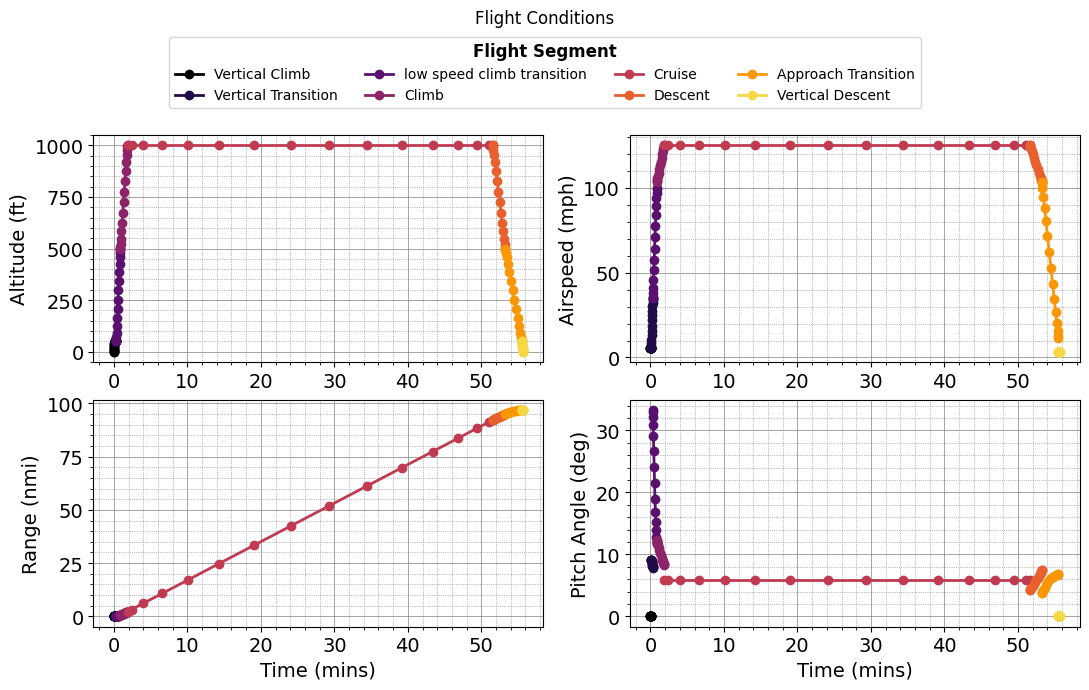

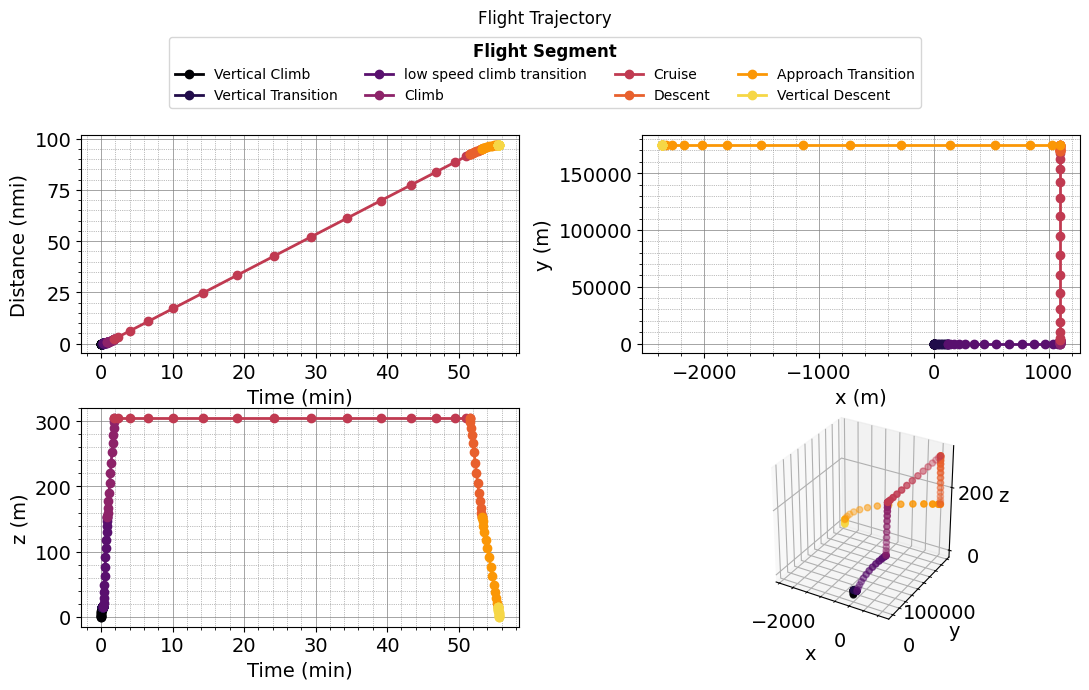

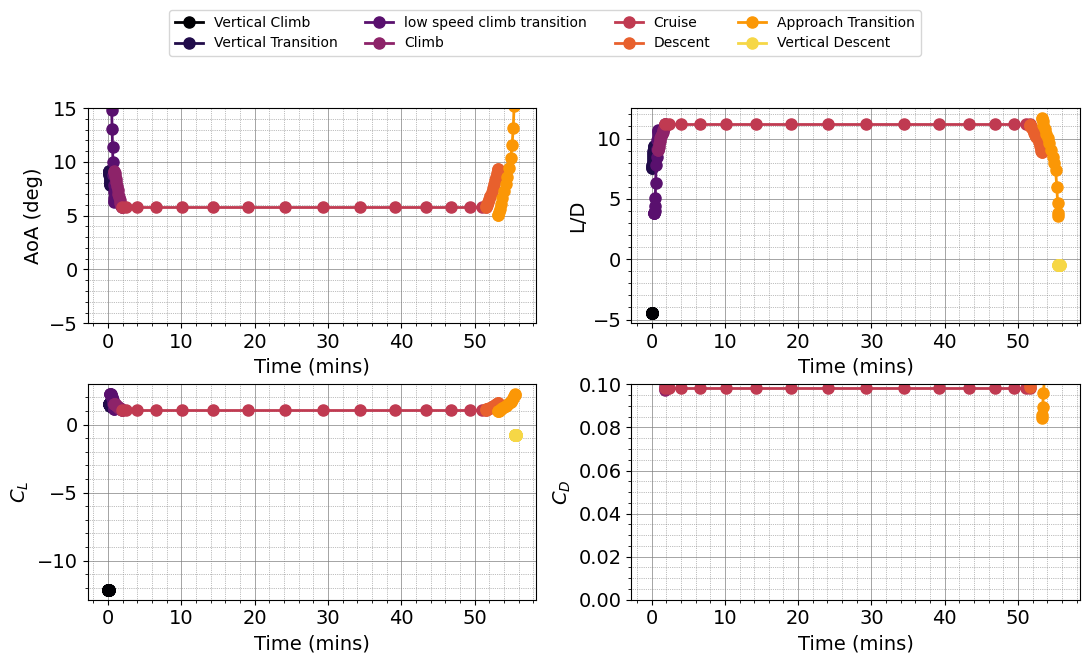

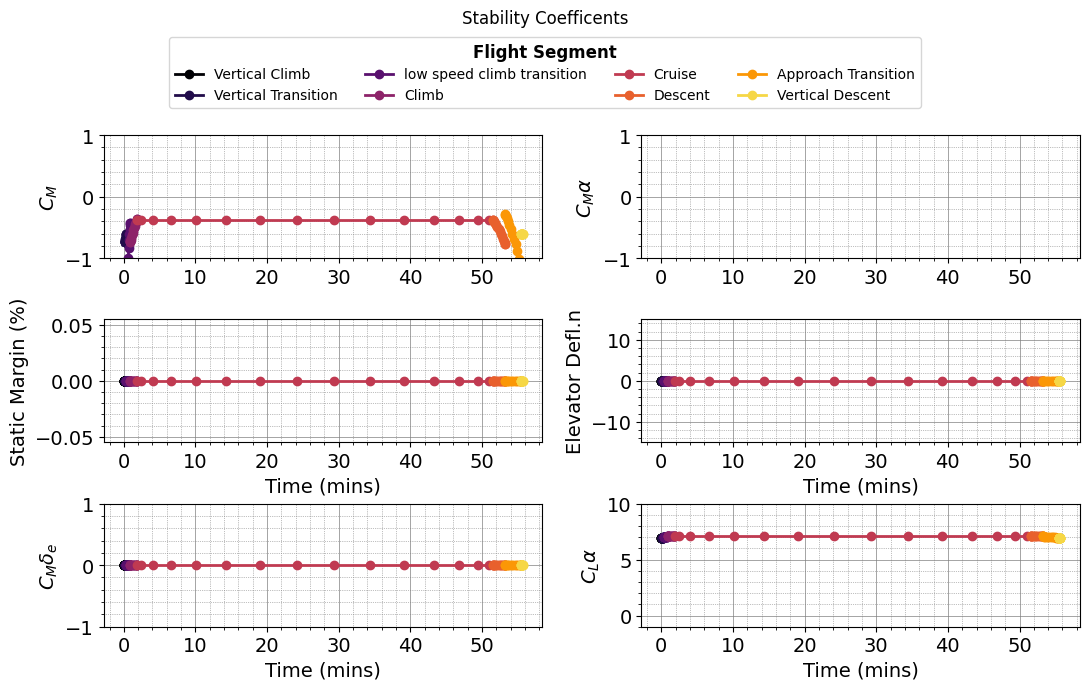

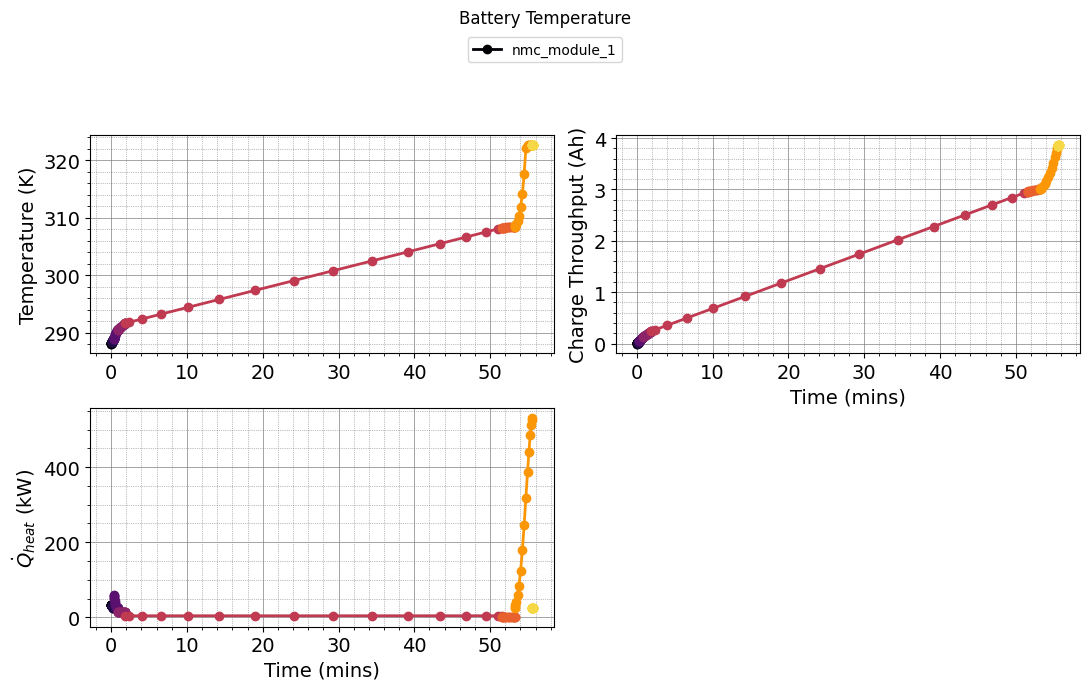

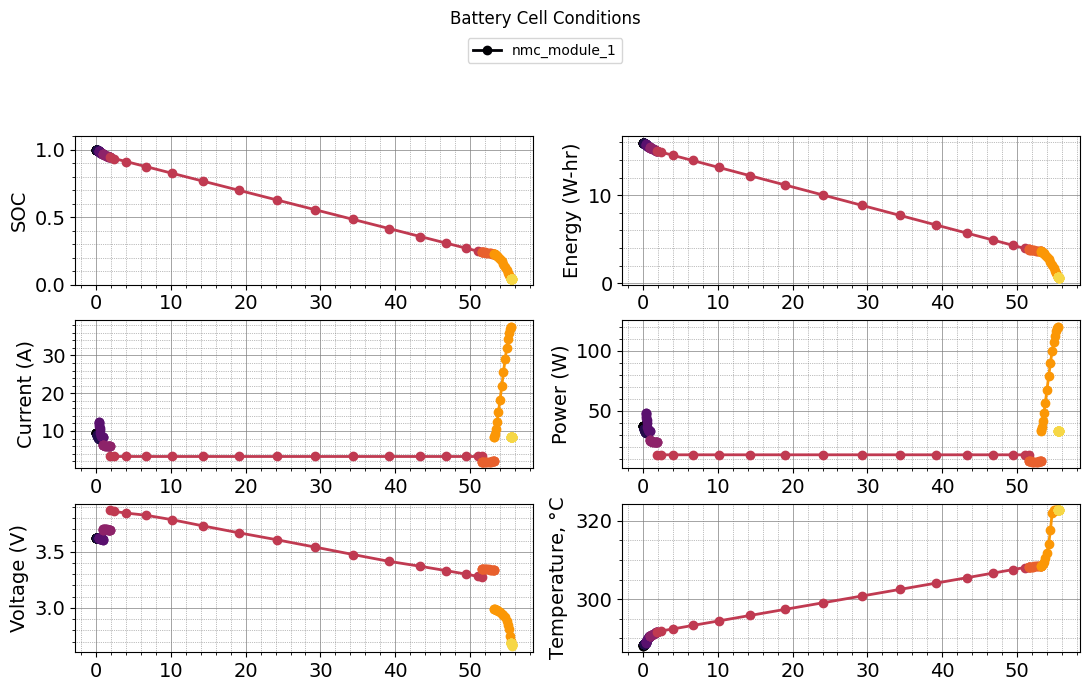

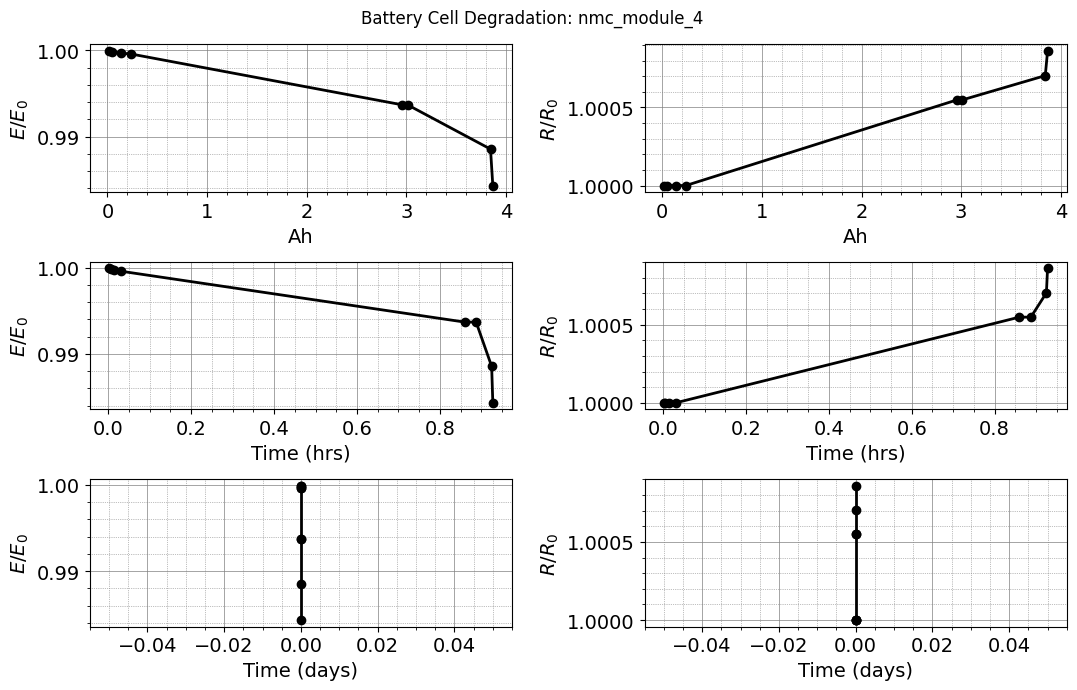

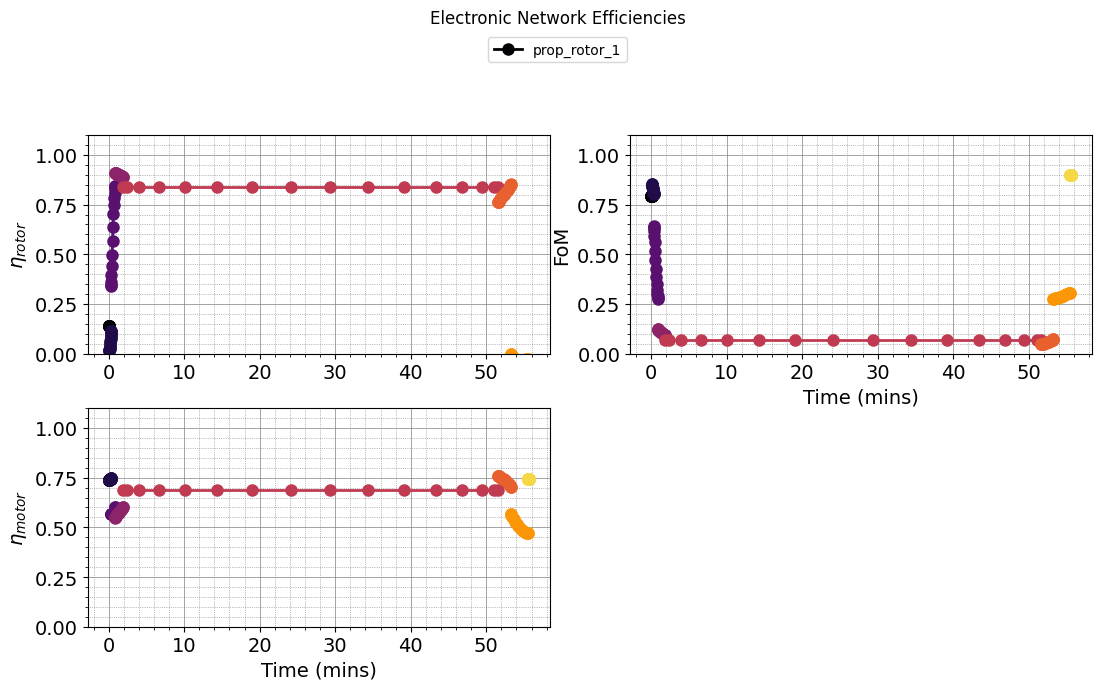

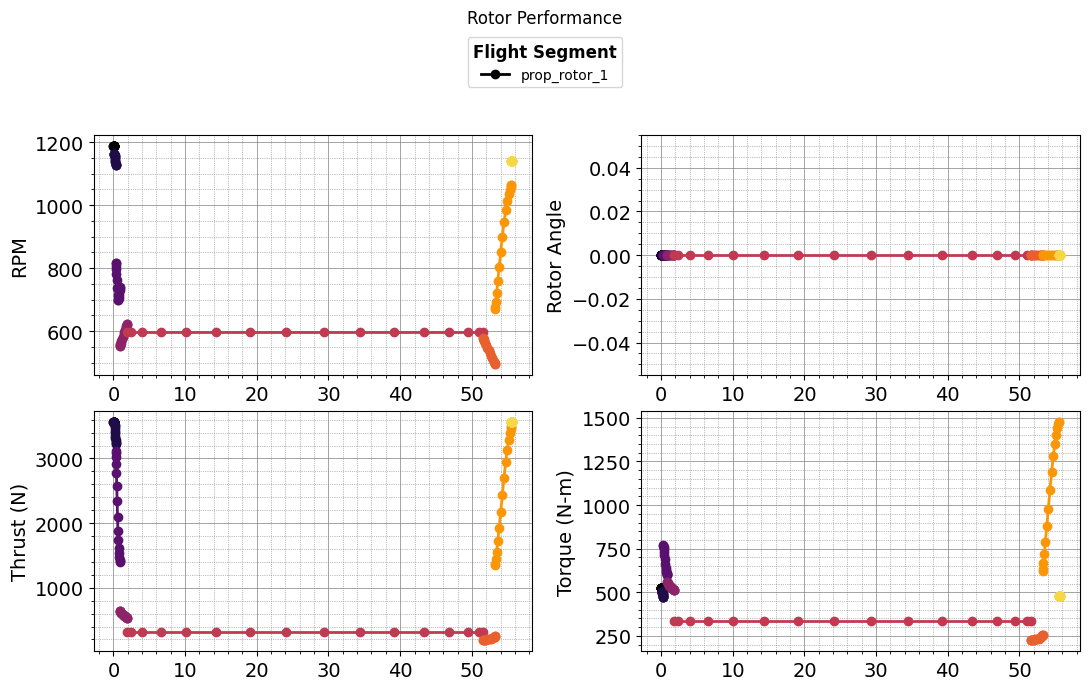

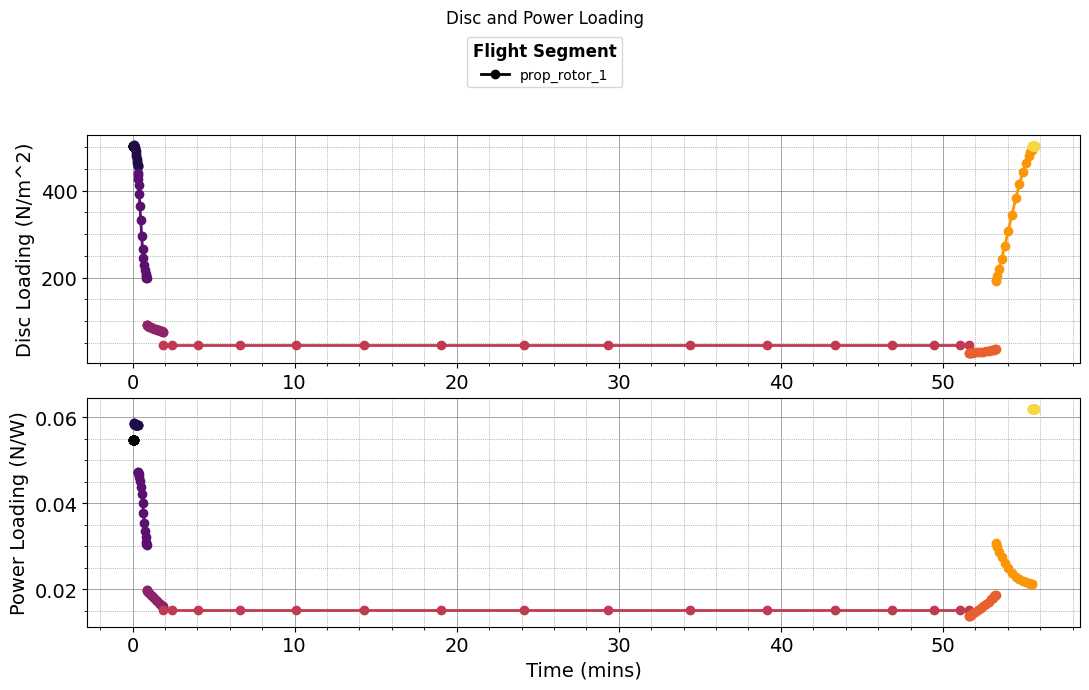

In [13]:
# vehicle data  
vehicle  = vehicle_setup() 

# Set up configs
configs  = configs_setup(vehicle)

# vehicle analyses
analyses = analyses_setup(configs)

# mission analyses
mission  = mission_setup(analyses) 
missions = missions_setup(mission) 
    
results = missions.base_mission.evaluate() 
    
# plot the results 
plot_results(results) 

## plot vehicle 
#plot_3d_vehicle(vehicle, 
                #min_x_axis_limit            = -5,
                #max_x_axis_limit            = 15,
                #min_y_axis_limit            = -10,
                #max_y_axis_limit            = 10,
                #min_z_axis_limit            = -10,
                #max_z_axis_limit            = 10,
                #show_figure                 = False 
                #) 